In [1]:
from itertools import chain
import numpy as np
import matplotlib.pyplot as plt

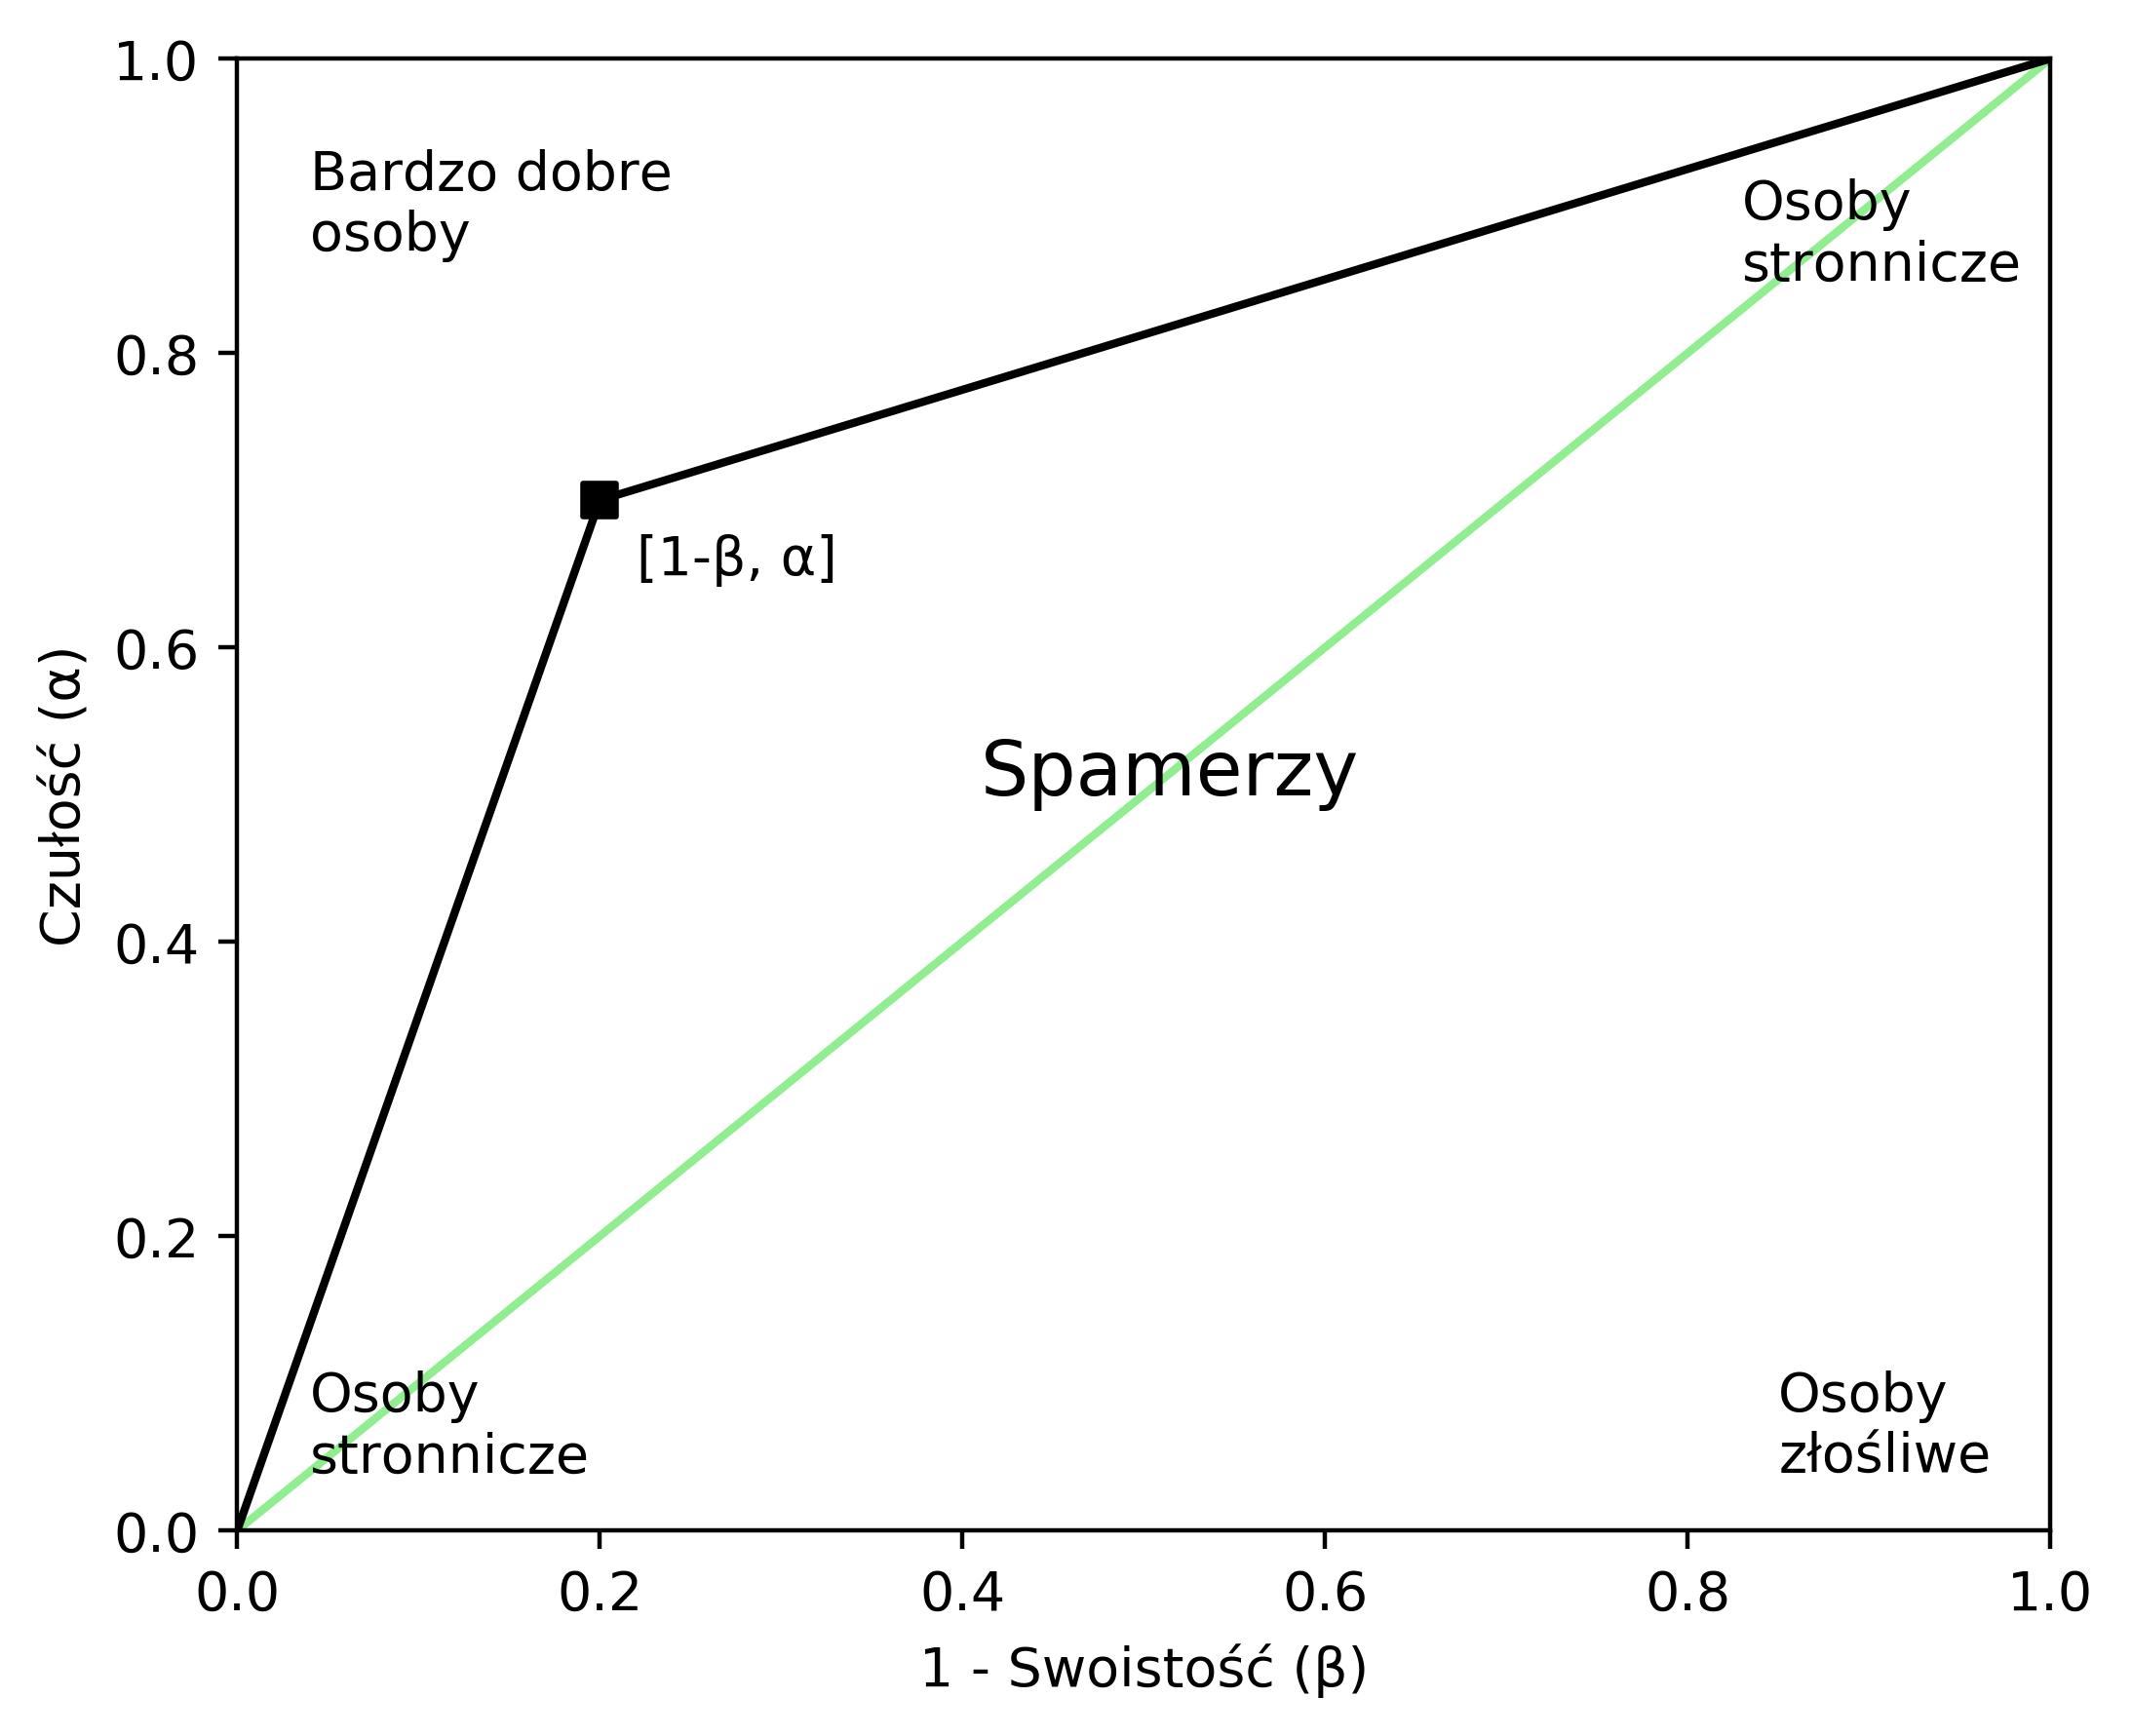

In [2]:
plt.figure(figsize=[6, 5], dpi=400)

ax = plt.subplot(111)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('1 - Swoistość (β)')
ax.set_ylabel('Czułość (α)')

ax.plot([0, 1], [0, 1], color='lightgreen')

ax.plot([0, 0.2], [0.0, 0.7], color='black')
ax.plot([0.2, 1.0], [0.7, 1.0], color='black')
ax.scatter([0.2], [0.7], color='black', marker='s')
ax.text(0.22, 0.65, '[1-β, α]')

ax.text(0.04, 0.87, 'Bardzo dobre\nosoby')
ax.text(0.41, 0.5, 'Spamerzy', fontsize=14)
ax.text(0.83, 0.85, 'Osoby\nstronnicze')
ax.text(0.04, 0.04, 'Osoby\nstronnicze')
ax.text(0.85, 0.04, 'Osoby\nzłośliwe')

plt.show()

# Toolbox

In [3]:
def plot_jaccard_index(Y, E, legend, groups=3, colors=['tab:blue', 'tab:orange', 'tab:green'],
                       figsize=[6, 5], height=0.45,
                       title='IoU - Dataset vs. Expert annotations', save=None):
    plt.figure(figsize=figsize, dpi=400)
    plt.title(title, y=1.02)
    
    ax = plt.subplot(111)

    X = [i*0.5 + 0.5*(i//groups) for i in range(groups * 4)]
    for i in range(groups):
        ax.barh(X[i::groups], Y[i::groups], xerr=E[i::groups], color=colors[i],
                height=height, align='center')

    ax.set_yticks([i*(groups+1)*0.5 + (groups/2)*0.5 - 0.25 for i in range(4)])
    ax.set_yticklabels(['M. Voting', 'GMM', 'K-Means', 'DBSCAN'])
    ax.invert_yaxis()
    ax.set_xlabel('IoU [%]')
    ax.set_xlim((0, 100))
    
    ax.xaxis.grid(True)
    ax.set_axisbelow(True)

    lgd = ax.legend(legend, ncol=3, loc='center', bbox_to_anchor=(0.5, -0.2))

    if save is not None:
        plt.savefig(save, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

In [4]:
def plot_mean_average_precision(Y, E, legend, groups=3, height=0.45,
                                title='Precision - Dataset vs. Expert annotations', save=None):
    plt.figure(figsize=[6, 5], dpi=400)
    plt.title(title, y=1.02)

    ax = plt.subplot(111)

    X = [i*0.5 + 0.5*(i//groups) for i in range(groups * 4)]
    for i in range(groups):
        ax.barh(X[i::groups], Y[i::groups], xerr=E[i::groups], height=height, align='center')

    ax.set_yticks([i*(groups+1)*0.5 + (groups/2)*0.5 - 0.25 for i in range(4)])
    ax.set_yticklabels(['M. Voting', 'GMM', 'K-Means', 'DBSCAN'])
    ax.invert_yaxis()
    ax.set_xlabel('mAP@0.75 [%]')
    ax.set_xlim((0, 100))

    ax.xaxis.grid(True)
    ax.set_axisbelow(True)

    lgd = ax.legend(legend, ncol=3, loc='center', bbox_to_anchor=(0.5, -0.2))

    if save is not None:
        plt.savefig(save, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

In [5]:
def plot_sensitivity_specificity(eti_specificity, gumed_specificity, title, legend, save=None):
    plt.figure(figsize=[6, 6], dpi=400)
    plt.title(title, y=1.02)
    
    ax = plt.subplot(111)

    ax.scatter(1 - np.array(eti_specificity), np.array(eti_sensitivity))
    ax.scatter(1 - np.array(gumed_specificity), np.array(gumed_sensitivity))
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel('1 - Specificity')
    ax.set_ylabel('Sensitivity')
    
    lgd = ax.legend(legend, ncol=3, loc='center', bbox_to_anchor=(0.5, -0.15))

    ax.plot([0, 1], [0, 1], color='lightgreen')
    
    ax.text(0.04, 0.89, 'Good\nAnnotators')
    ax.text(0.8, 0.89, 'Biased\nAnnotators')
    ax.text(0.04, 0.04, 'Biased\nAnnotators')
    ax.text(0.8, 0.04, 'Malicious\nAnnotators')
    ax.text(0.41, 0.5, 'Spammers', fontsize=14)
    
    if save is not None:
        plt.savefig(save, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

In [6]:
from sqlalchemy import func
from sklearn import linear_model

def plot_mean_labeling_time_vs_score(label_elements, eti_score, gumed_score, title, legend, save=None):
    scans_ids = {label_element.label.scan_id for label_element in label_elements}
    query = models.Label.query.with_entities(models.Label.owner_id, func.avg(models.Label.labeling_time))
    query = query.filter(models.Label.scan_id.in_(scans_ids))
    query = query.group_by(models.Label.owner_id)
    labeling_time_for_user_id = dict(query.all())

    eti_score = {user_id: eti_score[user_id] for user_id in eti_score}
    gumed_score = {user_id: gumed_score[user_id] for user_id in gumed_score}
    
    user_ids = list(eti_score.keys())
    eti_scores = [eti_score.get(user_id, 0) for user_id in user_ids]
    eti_labeling_time = [labeling_time_for_user_id.get(user_id, 0) for user_id in user_ids]
    eti_linear_regression = linear_model.LinearRegression().fit(np.array(eti_labeling_time)[:, None], eti_scores)

    user_ids = list(gumed_score.keys())
    gumed_scores = [gumed_score.get(user_id, 0) for user_id in user_ids]
    gumed_labeling_time = [labeling_time_for_user_id.get(user_id, 0) for user_id in user_ids]
    gumed_linear_regression = linear_model.LinearRegression().fit(np.array(gumed_labeling_time)[:, None], gumed_scores)

    x = np.arange(min(eti_labeling_time + gumed_labeling_time), max(eti_labeling_time + gumed_labeling_time), 1)
    
    plt.figure(figsize=[6, 5], dpi=400)
    ax = plt.subplot(111)
    
    ax.plot(x, x * eti_linear_regression.coef_[0] + eti_linear_regression.intercept_, "r--", color='tab:blue')
    ax.plot(x, x * gumed_linear_regression.coef_[0] + gumed_linear_regression.intercept_, "r--", color='tab:orange')

    ax.scatter(eti_labeling_time, eti_scores)
    ax.scatter(gumed_labeling_time, gumed_scores)

    ax.set_title(title, y=1.02)
    ax.set_xlabel('Mean labelling time [s]')
    ax.set_ylabel('Quality')
    ax.set_ylim(0, 1)
    
    lgd = ax.legend(legend, ncol=3, loc='center', bbox_to_anchor=(0.5, -0.2))
    
    if save is not None:
        plt.savefig(save, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

# 5.1.1. Analiza pokrycia wygenerowanego zbioru danych

## Prostokąty

In [7]:
all_people = [
    (66.652, 11.848),  # Majority Voting
    (64.878, 12.158),  # GMM
    (66.389, 11.984),  # KMeans
    (64.786, 12.112),  # DBSCAN
]
fifty_percent_people = [
    (71.975, 4.078),  # Majority Voting
    (70.053, 4.840),  # GMM
    (70.709, 4.108),  # KMeans
    (70.113, 4.846),  # DBSCAN
]
twentyfive_percent_people = [
    (74.254, 4.294),  # Majority Voting
    (71.905, 4.399),  # GMM
    (72.825, 5.458),  # KMeans
    (71.736, 4.212),  # DBSCAN
]

In [8]:
Y = np.array(list(chain(*[[all_people[i][0], fifty_percent_people[i][0], twentyfive_percent_people[i][0]] for i in range(4)])))
E = np.array(list(chain(*[[all_people[i][1], fifty_percent_people[i][1], twentyfive_percent_people[i][1]] for i in range(4)])))

/Users/jakubpowierza/Projects/MedTagger/backend/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


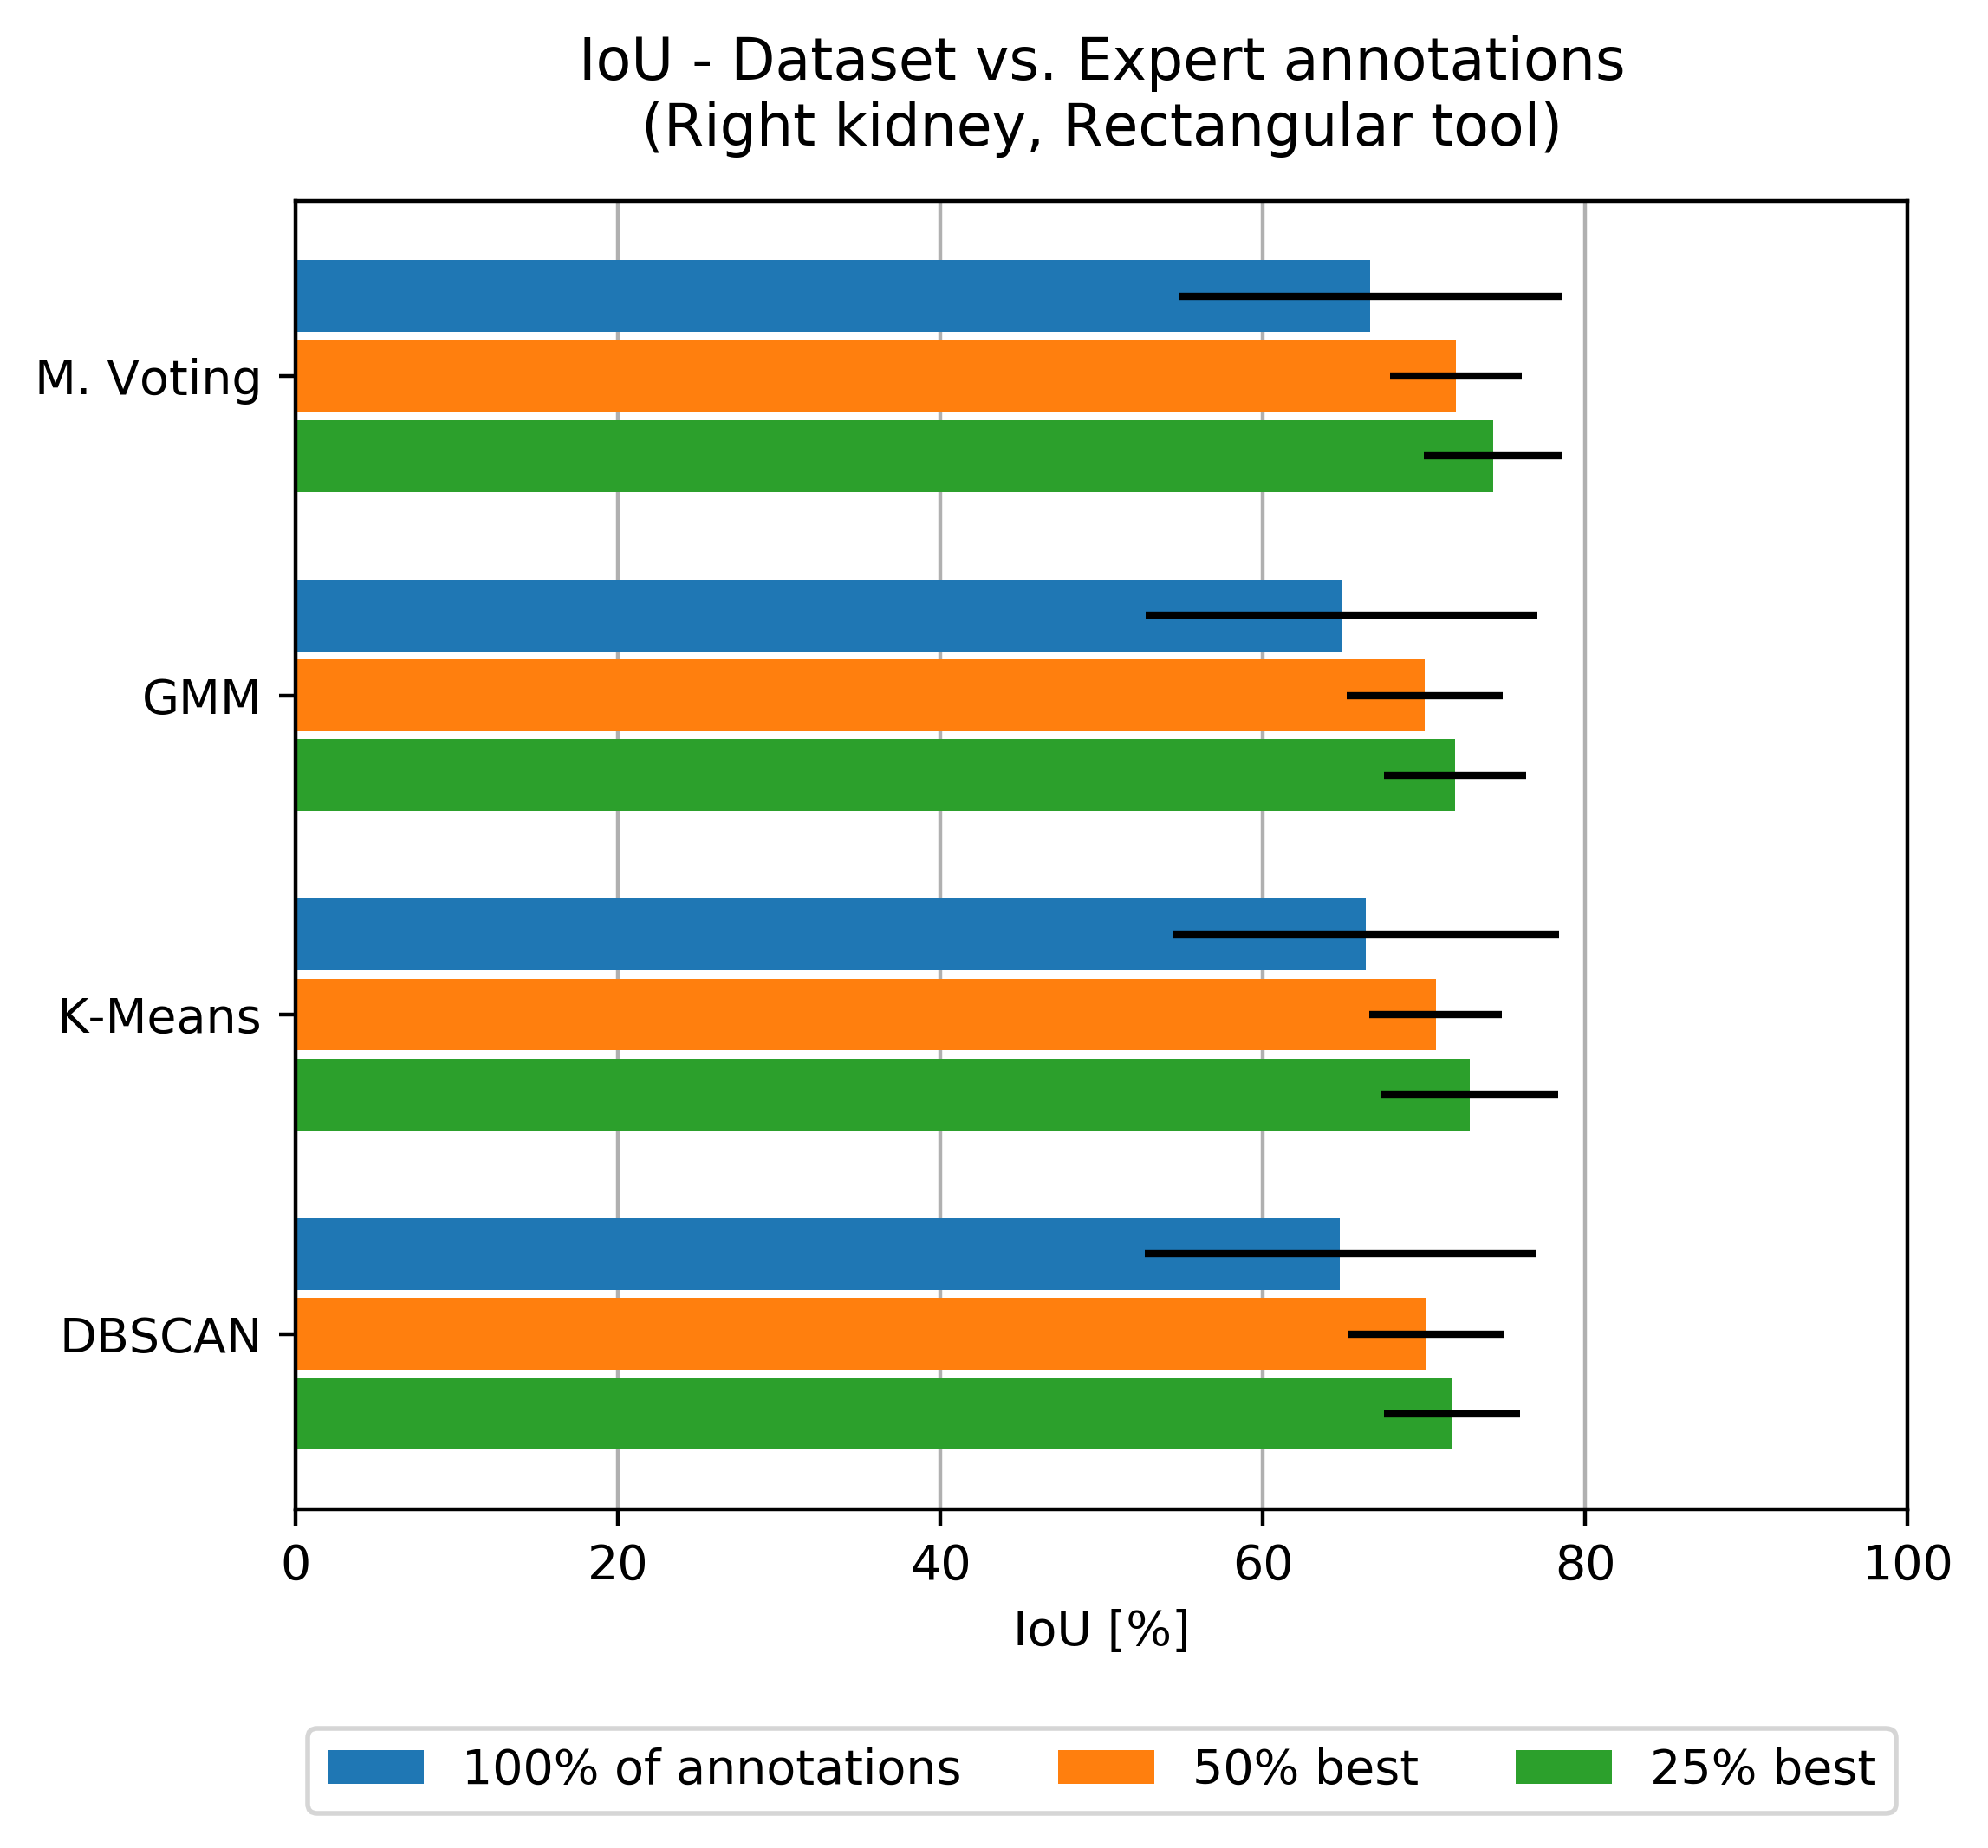

In [9]:
plot_jaccard_index(Y, E,
                   title='IoU - Dataset vs. Expert annotations\n(Right kidney, Rectangular tool)',
                   legend=['100% of annotations', '50% best', '25% best'],
                   save='/Users/jakubpowierza/Downloads/poster_images/1.png')

## Wielokąty

In [10]:
all_people = [
    (82.876, 7.106),  # Majority Voting
    (59.859, 12.164),  # GMM
    (60.899, 12.893),  # KMeans
    (56.271, 8.732),  # DBSCAN
]
fifty_percent_people = [
    (68.908, 7.502),  # Majority Voting
    (65.069, 7.578),  # GMM
    (66.715, 7.131),  # KMeans
    (58.982, 6.672),  # DBSCAN
]
twentyfive_percent_people = [
    (69.176, 7.774),  # Majority Voting
    (66.435, 7.673),  # GMM
    (67.115, 7.478),  # KMeans
    (62.376, 8.600),  # DBSCAN
]

In [11]:
Y = np.array(list(chain(*[[all_people[i][0], fifty_percent_people[i][0], twentyfive_percent_people[i][0]] for i in range(4)])))
E = np.array(list(chain(*[[all_people[i][1], fifty_percent_people[i][1], twentyfive_percent_people[i][1]] for i in range(4)])))

/Users/jakubpowierza/Projects/MedTagger/backend/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


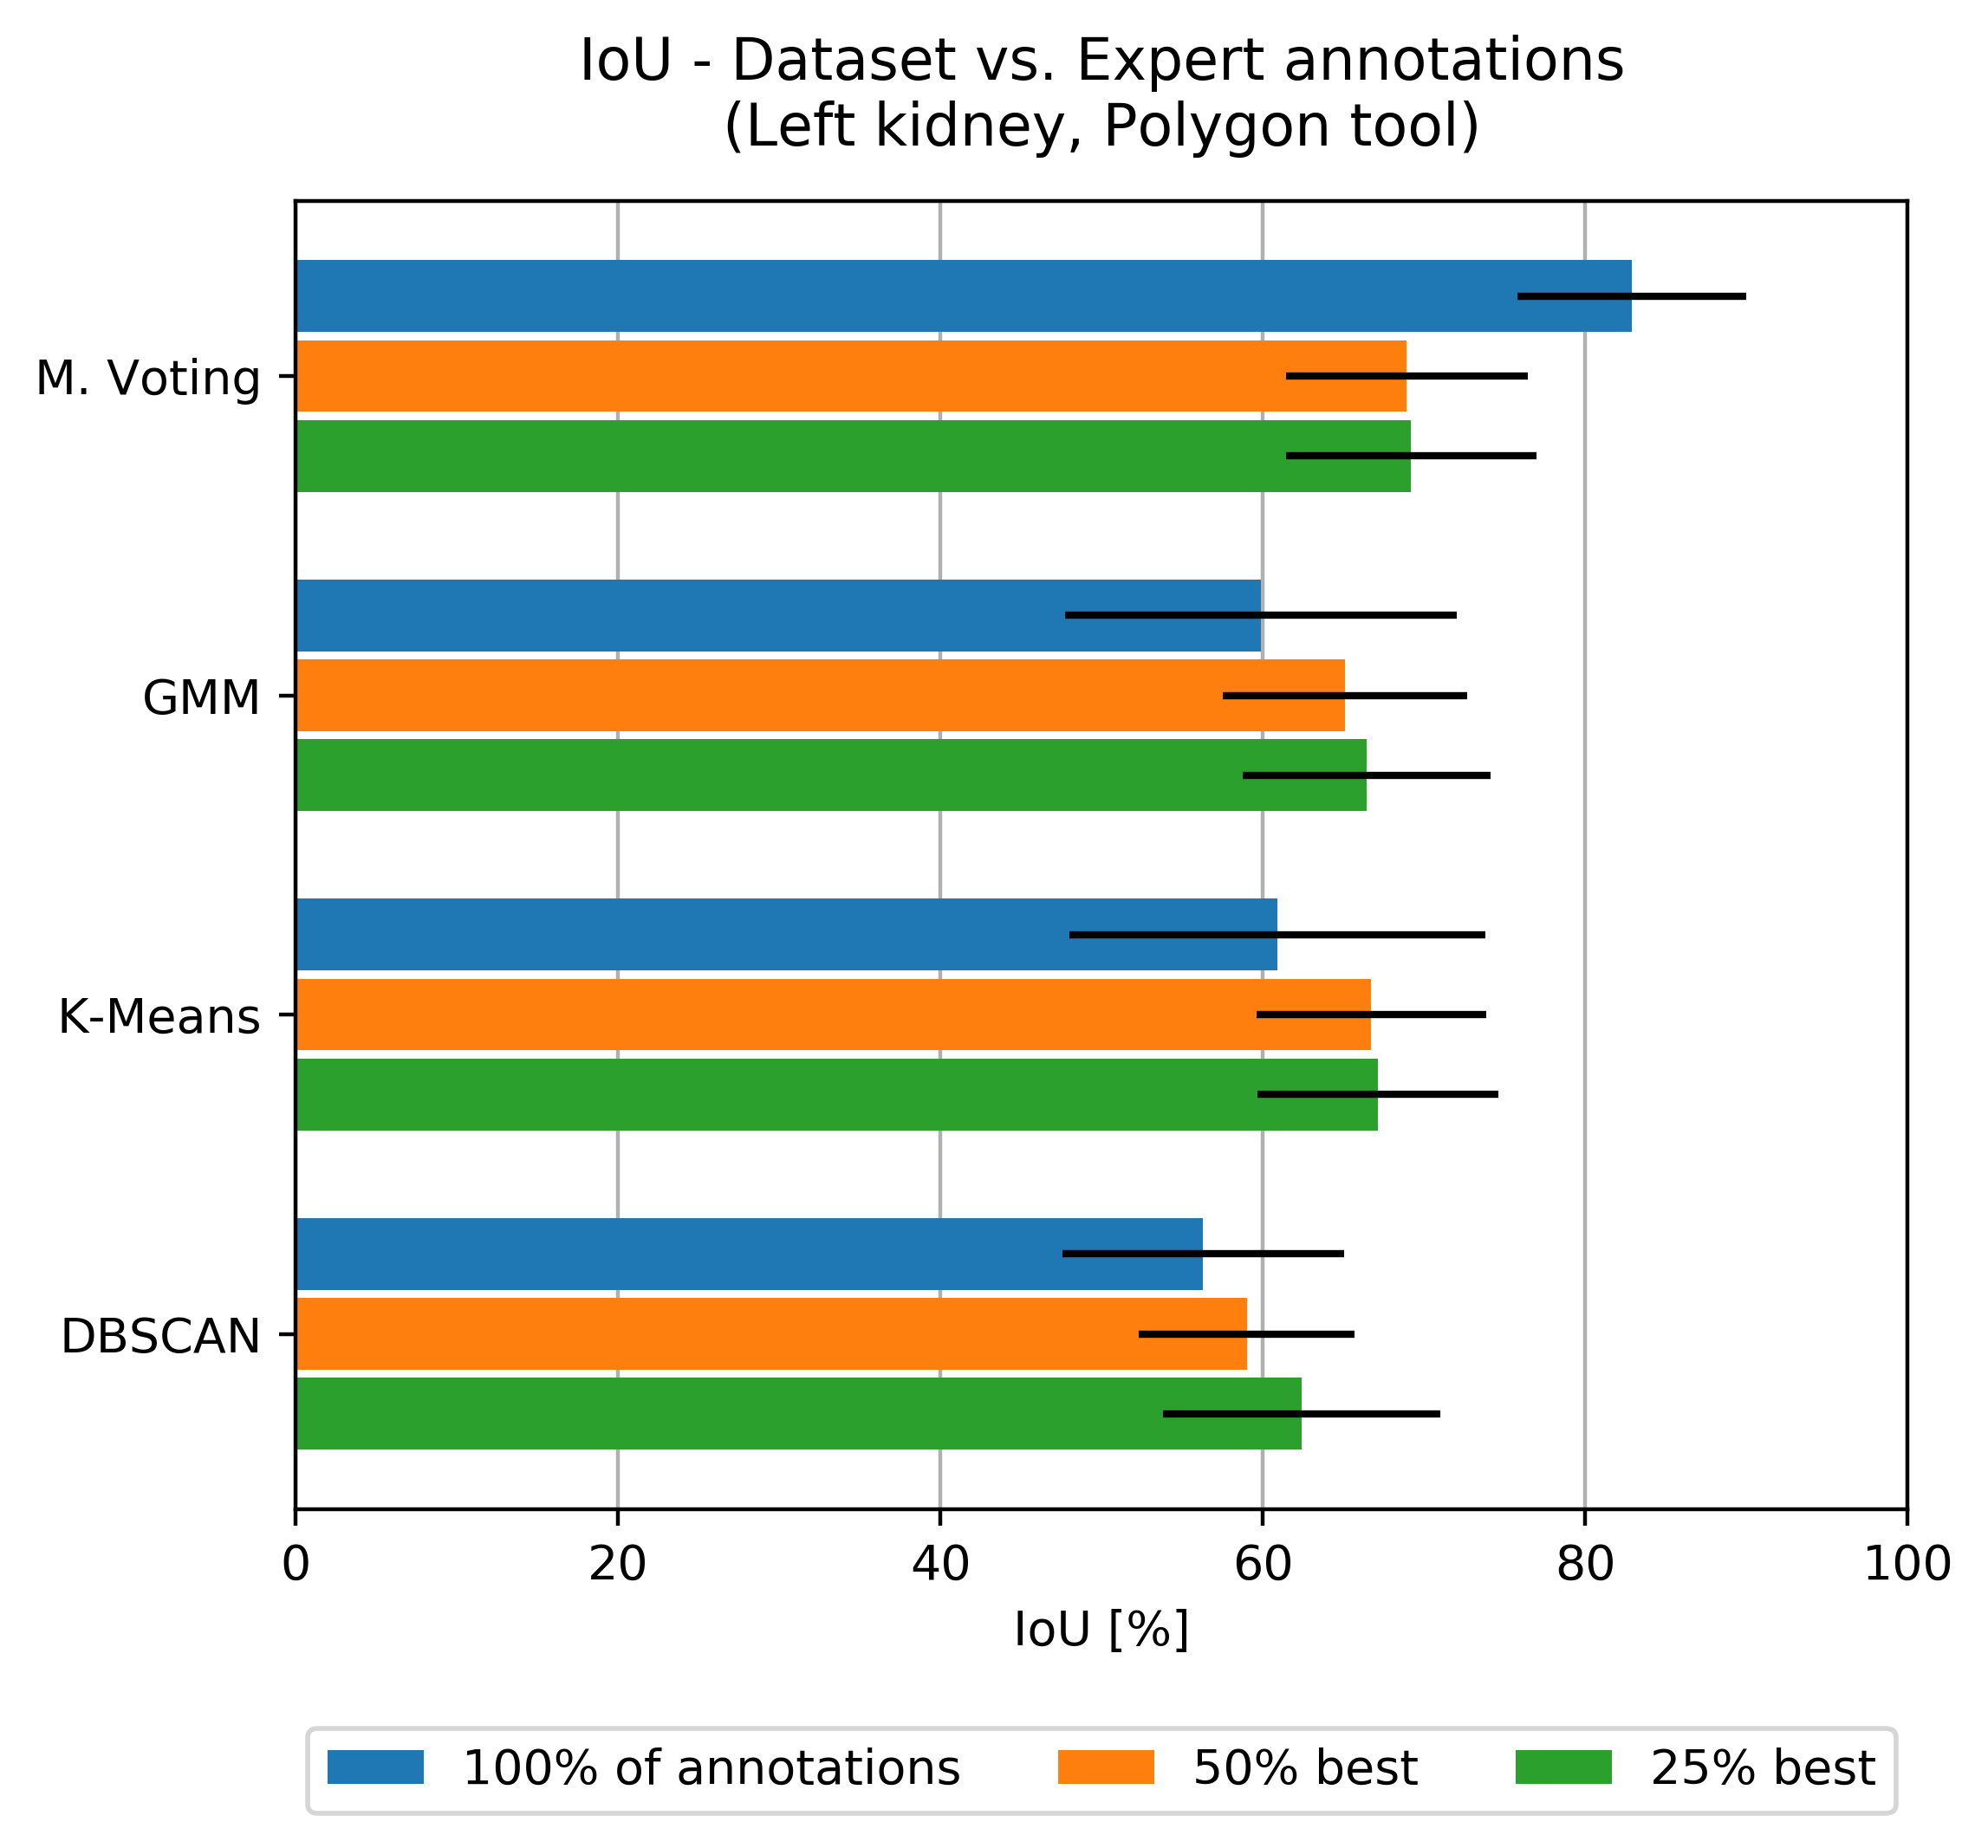

In [12]:
plot_jaccard_index(Y, E,
                   legend=['100% of annotations', '50% best', '25% best'],
                   title='IoU - Dataset vs. Expert annotations\n(Left kidney, Polygon tool)',
                   save='/Users/jakubpowierza/Downloads/poster_images/2.png')

# 5.1.2. Analiza precyzji wygenerowanego zbioru danych

## Prostokąty

In [13]:
all_people = [
    (83.922, 10.006),  # Majority Voting
    (82.094, 9.719),  # GMM
    (83.522, 10.240),  # KMeans
    (81.694, 9.968),  # DBSCAN
]
fifty_percent_people = [
    (88.673, 4.616),  # Majority Voting
    (87.959, 4.049),  # GMM
    (86.130, 5.214),  # KMeans
    (87.959, 4.049),  # DBSCAN
]
twentyfive_percent_people = [
    (89.582, 4.494),  # Majority Voting
    (88.868, 4.111),  # GMM
    (88.468, 6.109),  # KMeans
    (88.868, 4.111),  # DBSCAN
]

In [14]:
Y = np.array(list(chain(*[[all_people[i][0], fifty_percent_people[i][0], twentyfive_percent_people[i][0]] for i in range(4)])))
E = np.array(list(chain(*[[all_people[i][1], fifty_percent_people[i][1], twentyfive_percent_people[i][1]] for i in range(4)])))

/Users/jakubpowierza/Projects/MedTagger/backend/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


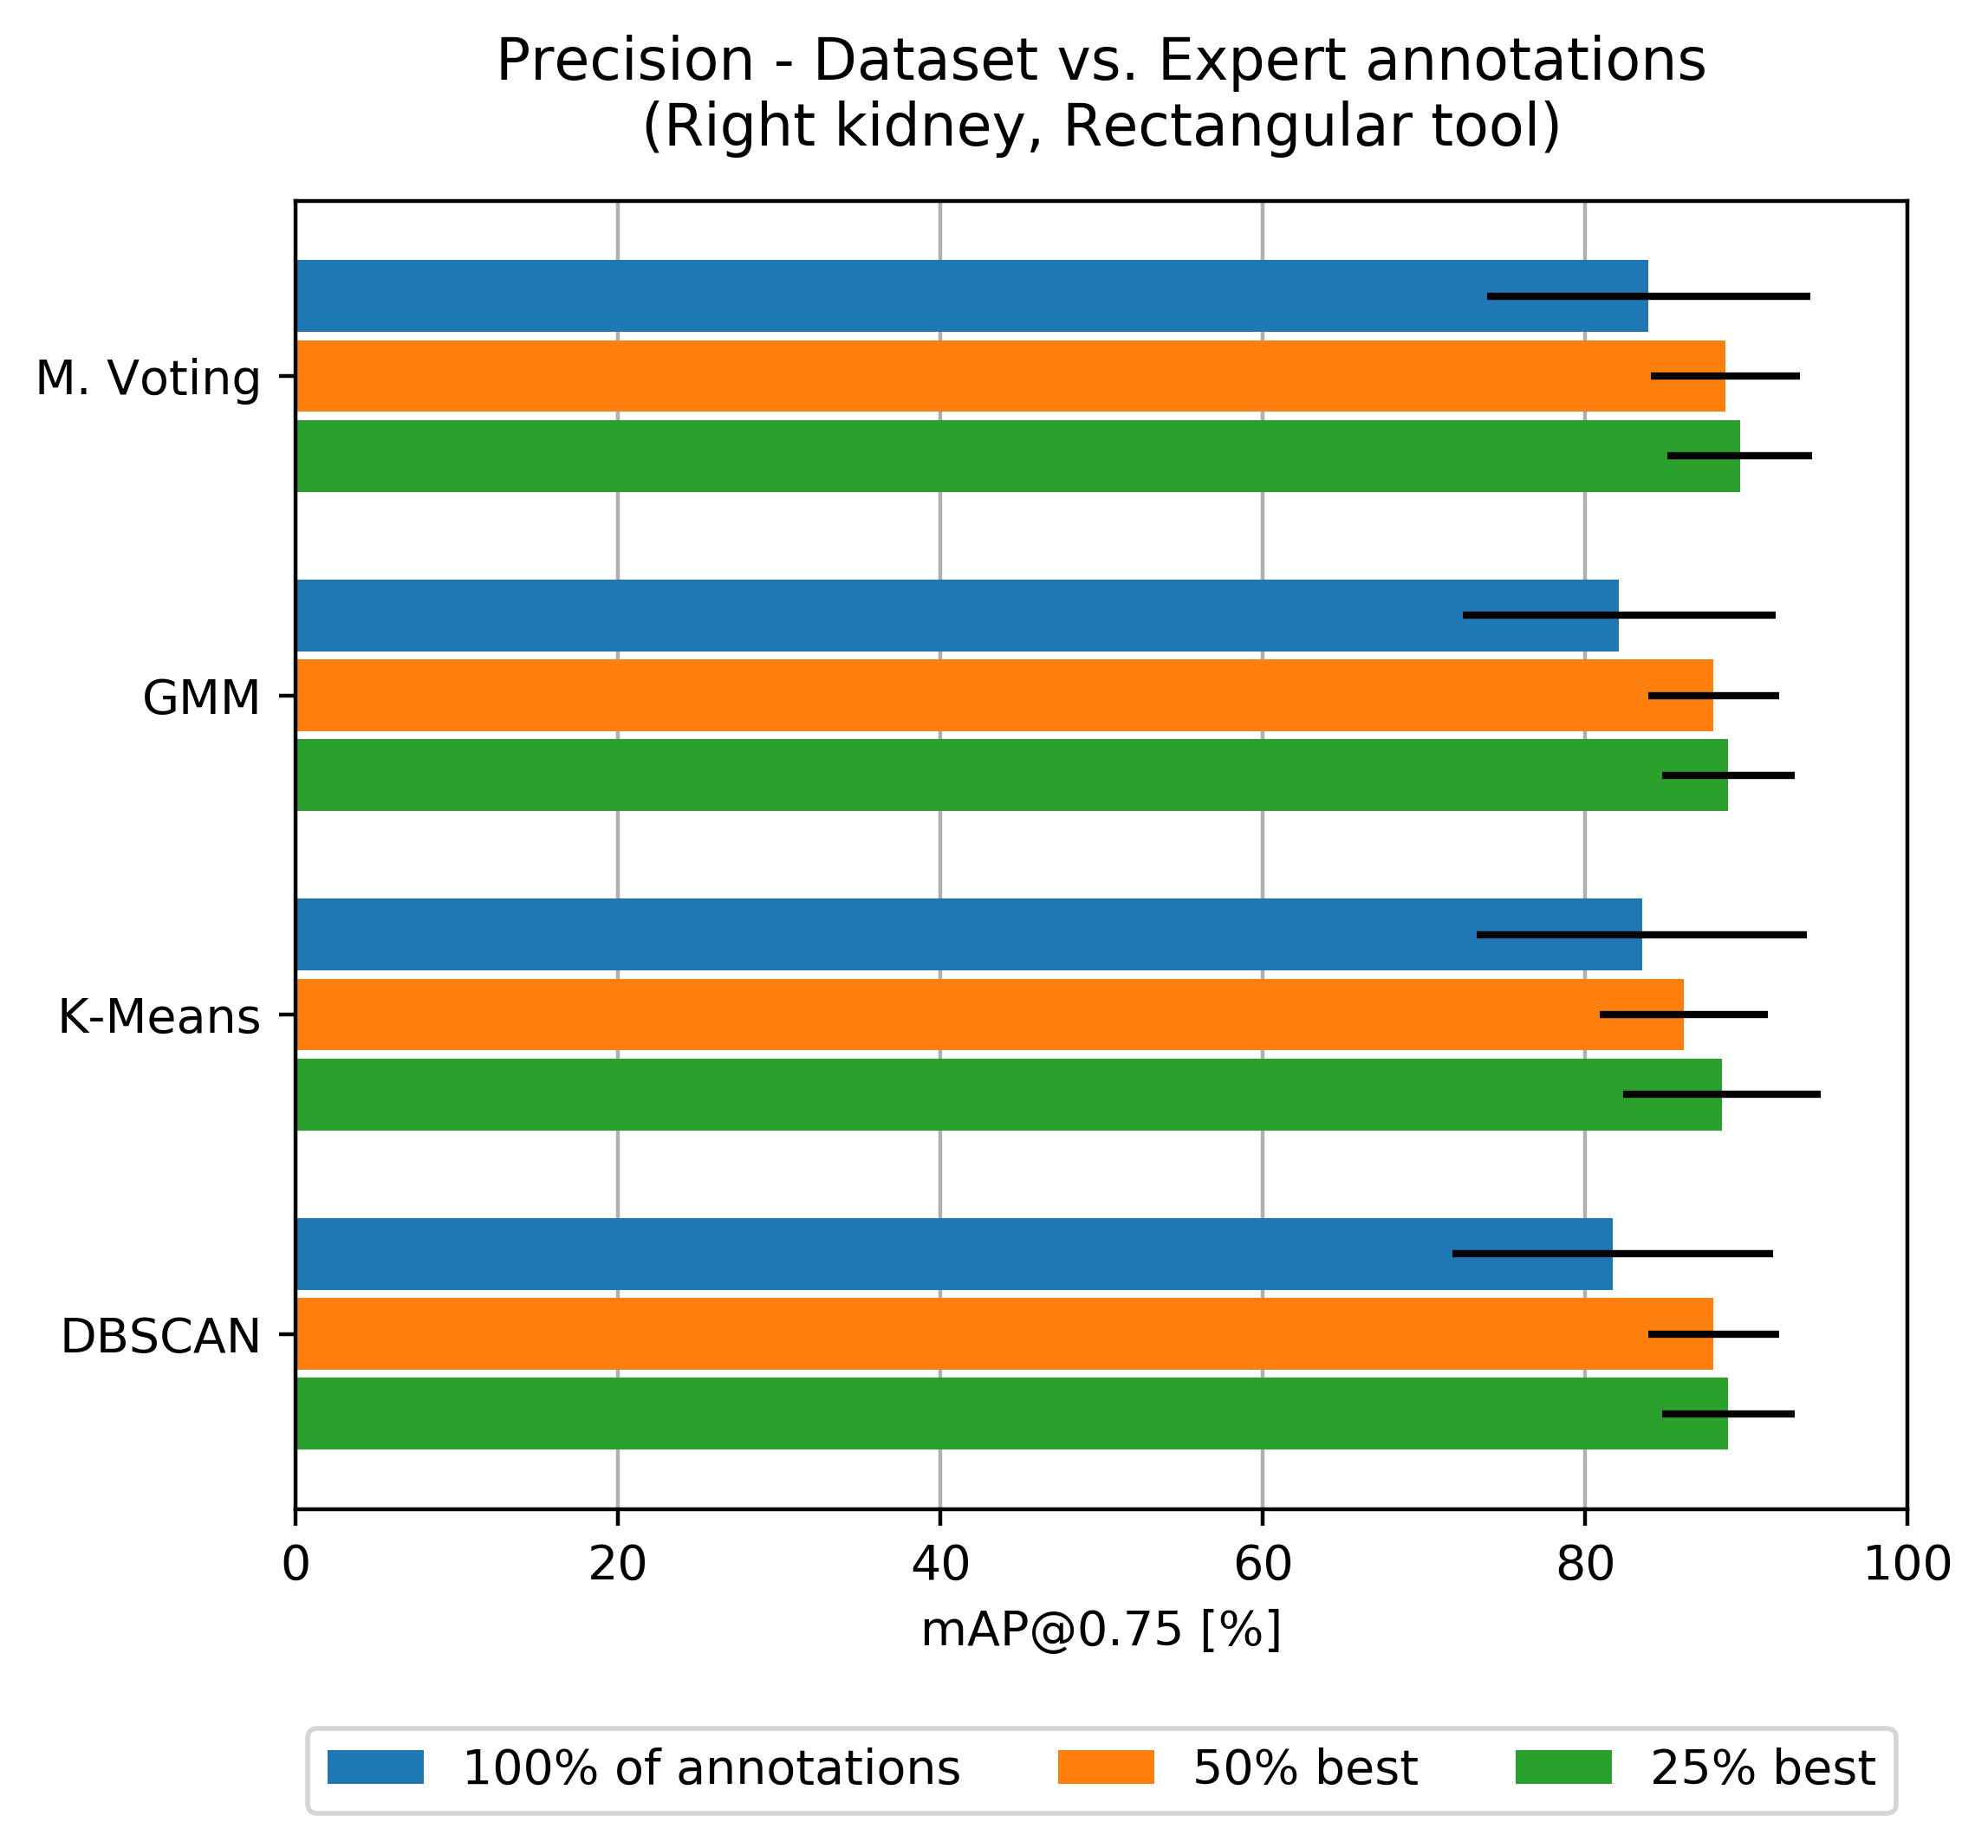

In [15]:
plot_mean_average_precision(Y, E,
                            legend=['100% of annotations', '50% best', '25% best'],
                            title='Precision - Dataset vs. Expert annotations\n(Right kidney, Rectangular tool)',
                   save='/Users/jakubpowierza/Downloads/poster_images/9.png')

## Wielokąty

In [16]:
all_people = [
    (81.431, 7.458),  # Majority Voting
    (76.488, 5.241),  # GMM
    (80.231, 6.566),  # KMeans
    (75.603, 6.826),  # DBSCAN
]
fifty_percent_people = [
    (86.387, 4.357),  # Majority Voting
    (83.130, 7.546),  # GMM
    (85.273, 4.857),  # KMeans
    (79.444, 6.967),  # DBSCAN
]
twentyfive_percent_people = [
    (87.101, 3.736),  # Majority Voting
    (85.587, 2.140),  # GMM
    (85.987, 3.764),  # KMeans
    (81.067, 8.611),  # DBSCAN
]

In [17]:
Y = np.array(list(chain(*[[all_people[i][0], fifty_percent_people[i][0], twentyfive_percent_people[i][0]] for i in range(4)])))
E = np.array(list(chain(*[[all_people[i][1], fifty_percent_people[i][1], twentyfive_percent_people[i][1]] for i in range(4)])))

/Users/jakubpowierza/Projects/MedTagger/backend/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


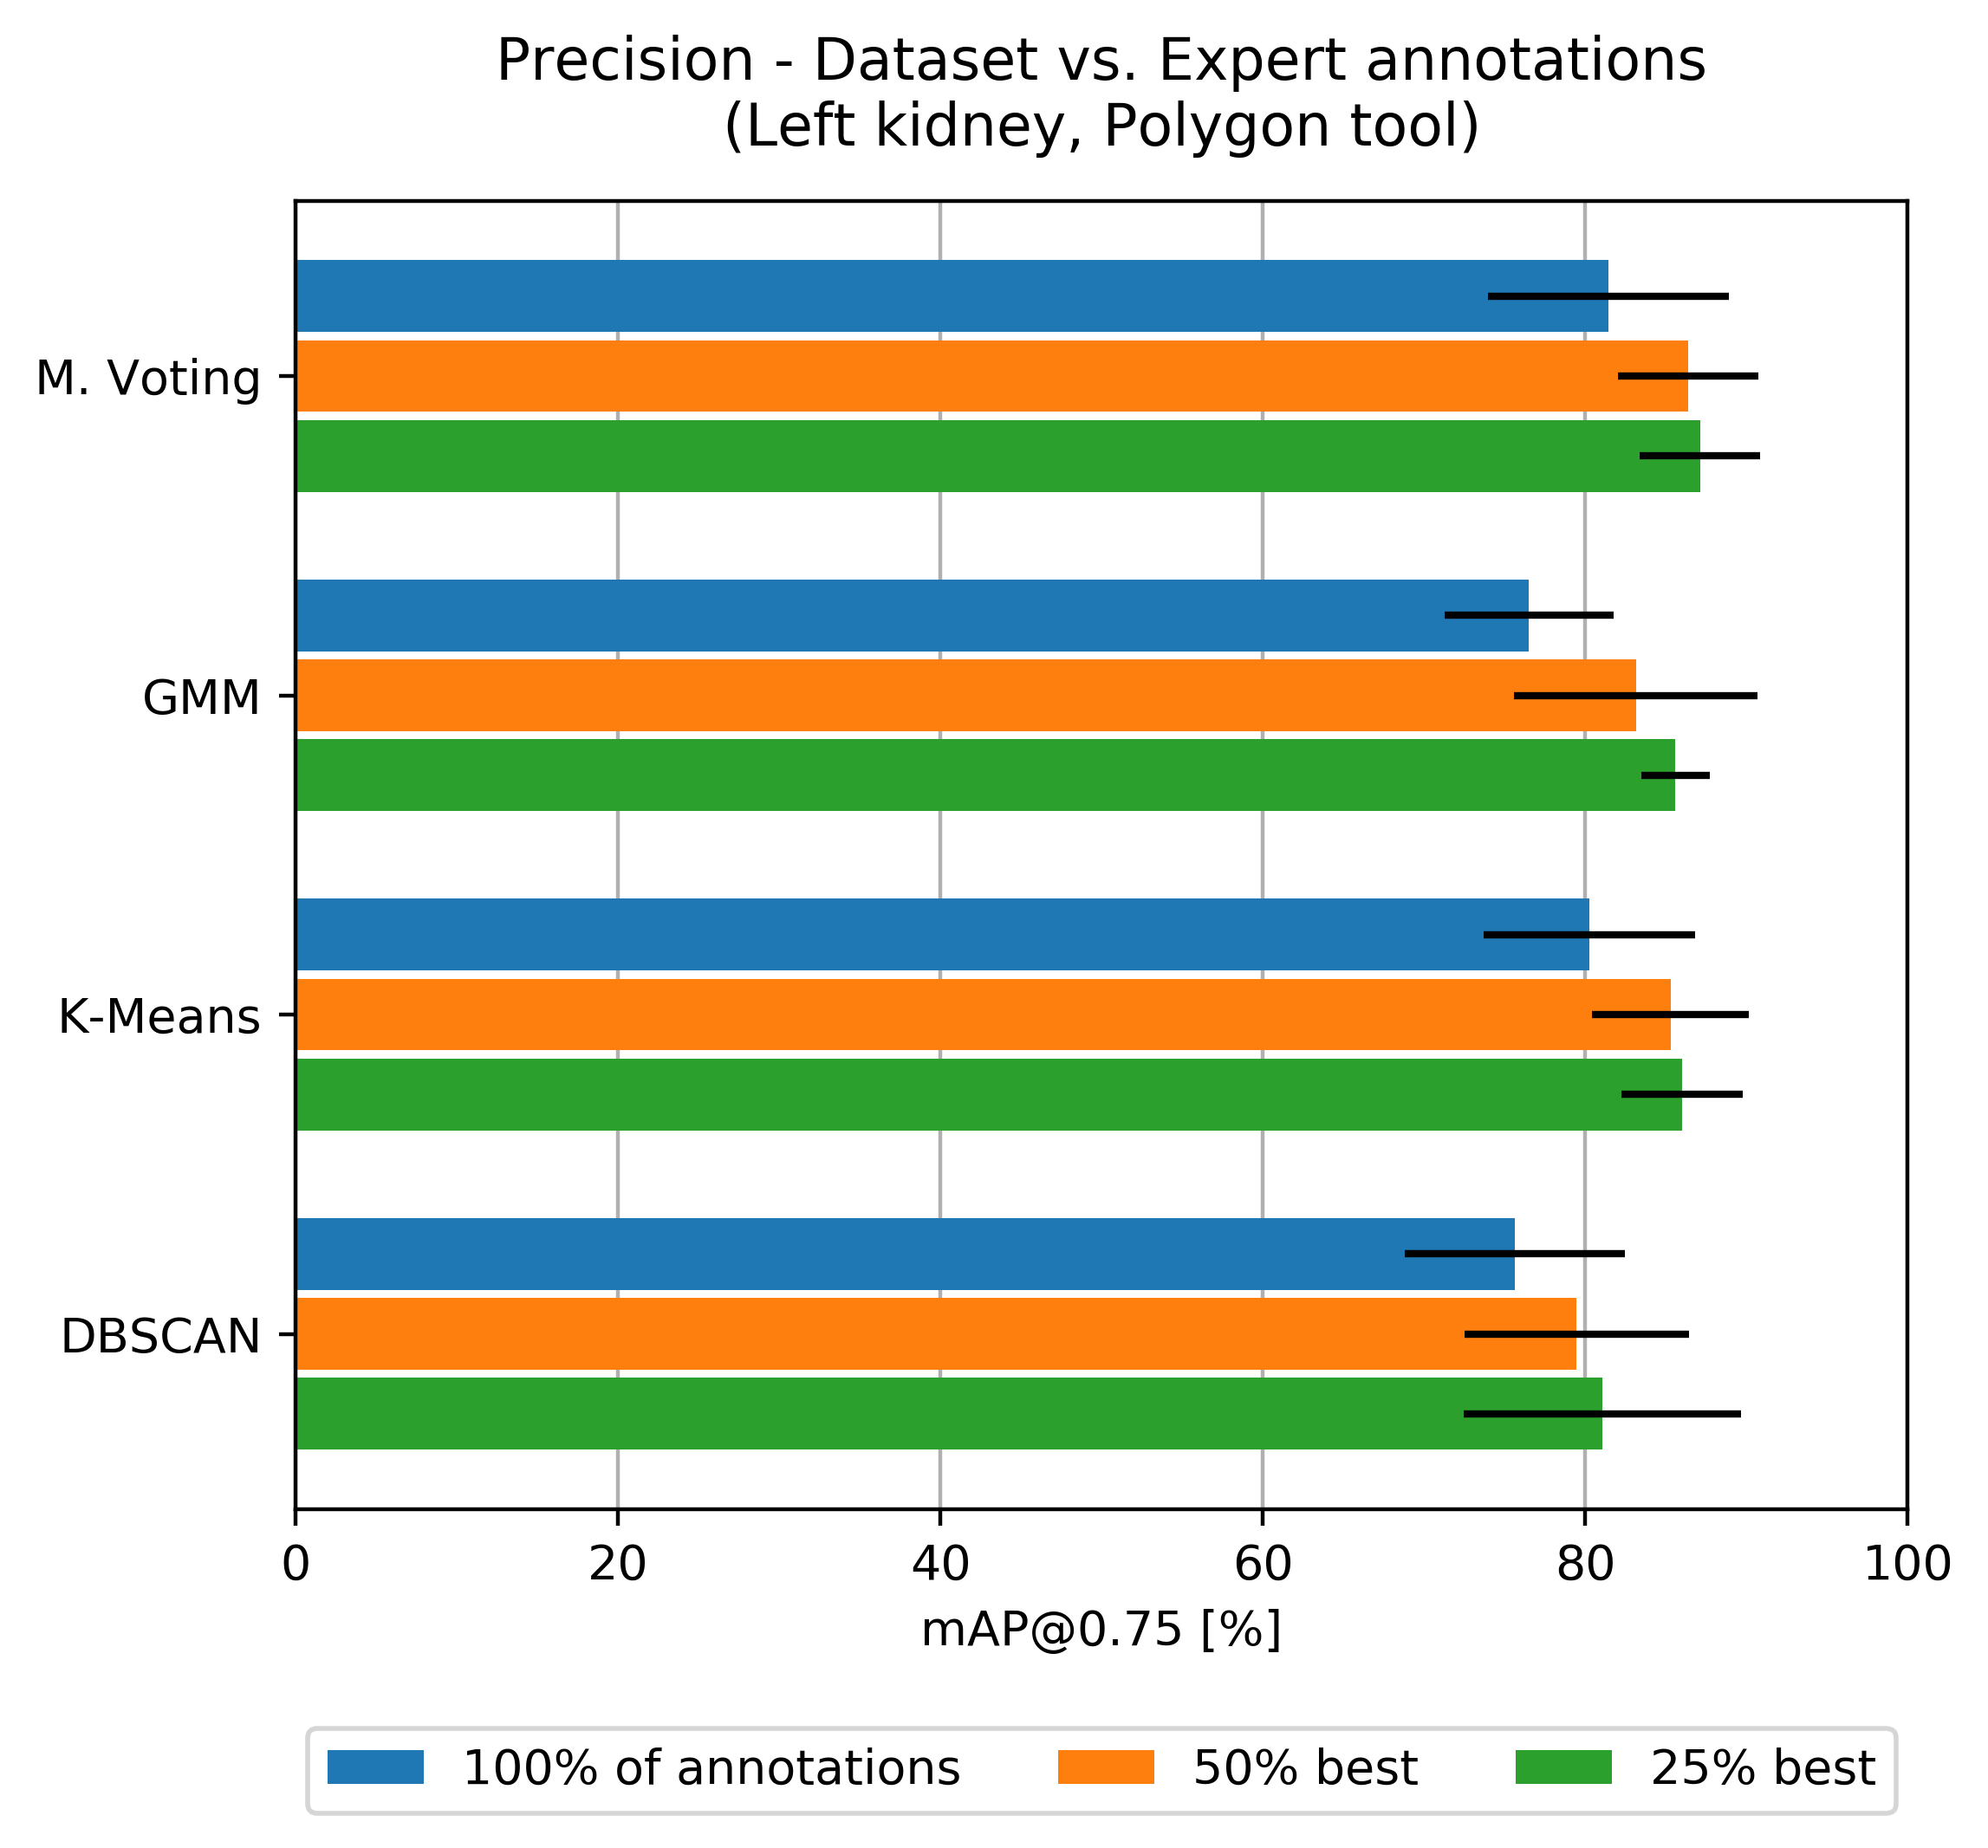

In [18]:
plot_mean_average_precision(Y, E,
                            legend=['100% of annotations', '50% best', '25% best'],
                            title='Precision - Dataset vs. Expert annotations\n(Left kidney, Polygon tool)',
                   save='/Users/jakubpowierza/Downloads/poster_images/10.png')

# 5.1.3. Analiza wpływu grup osób na jakość zbiorów danych

## Prostokąty

In [19]:
# all_people = [
#     (67.645, 10.663, 80.286, 5.180),  # Majority Voting
#     (67.008, 11.128, 77.448, 6.059),  # GMM
#     (67.199, 10.433, 79.118, 5.832),  # KMeans
#     (66.805, 11.074, 77.302, 6.230),  # DBSCAN
# ]
# fifty_percent_people = [
#     (71.705, 3.328, 81.520, 4.916),  # Majority Voting
#     (71.519, 2.601, 78.725, 5.113),  # GMM
#     (70.145, 2.820, 79.892, 5.311),  # KMeans
#     (70.908, 3.216, 78.702, 5.148),  # DBSCAN
# ]
# twentyfive_percent_people = [
#     (74.519, 6.091, 82.030, 4.897),  # Majority Voting
#     (74.160, 4.478, 78.791, 6.130),  # GMM
#     (74.685, 5.823, 81.370, 5.228),  # KMeans
#     (74.161, 4.478, 78.793, 6.129),  # DBSCAN
# ]

# Y = np.array(list(chain(*[[all_people[i][0], all_people[i][2],
#                            fifty_percent_people[i][0], fifty_percent_people[i][2],
#                            twentyfive_percent_people[i][0], twentyfive_percent_people[i][2]]
#                           for i in range(4)])))
# E = np.array(list(chain(*[[all_people[i][1], all_people[i][3],
#                            fifty_percent_people[i][1], fifty_percent_people[i][3],
#                            twentyfive_percent_people[i][1], twentyfive_percent_people[i][3]]
#                           for i in range(4)])))

# legend = ['Wszystkie osoby spoza dziedziny', 'Wszystkie osoby z dziedziny',
#           '50% najbardziej zgodnych osób spoza dziedziny', '50% najbardziej zgodnych osób z dziedziny',
#           '25% najbardziej zgodnych osób spoza dziedziny', '25% najbardziej zgodnych osób z dziedziny']
# plot_jaccard_index(Y, E, groups=6, figsize=[6, 6],
#                    legend=legend,
#                    title='Indeks Jaccarda wygenerowanego zbioru',
#                    colors=['tab:blue', 'steelblue', 'tab:orange', 'chocolate', 'tab:green', 'darkgreen'])

### Wszyscy ludzie

In [20]:
all_people = [
    (67.645, 10.663, 80.286, 5.180),  # Majority Voting
    (67.008, 11.128, 77.448, 6.059),  # GMM
    (67.199, 10.433, 79.118, 5.832),  # KMeans
    (66.805, 11.074, 77.302, 6.230),  # DBSCAN
]

In [21]:
Y = np.array(list(chain(*[[all_people[i][0], all_people[i][2]]
                          for i in range(4)])))
E = np.array(list(chain(*[[all_people[i][1], all_people[i][3]]
                          for i in range(4)])))

/Users/jakubpowierza/Projects/MedTagger/backend/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


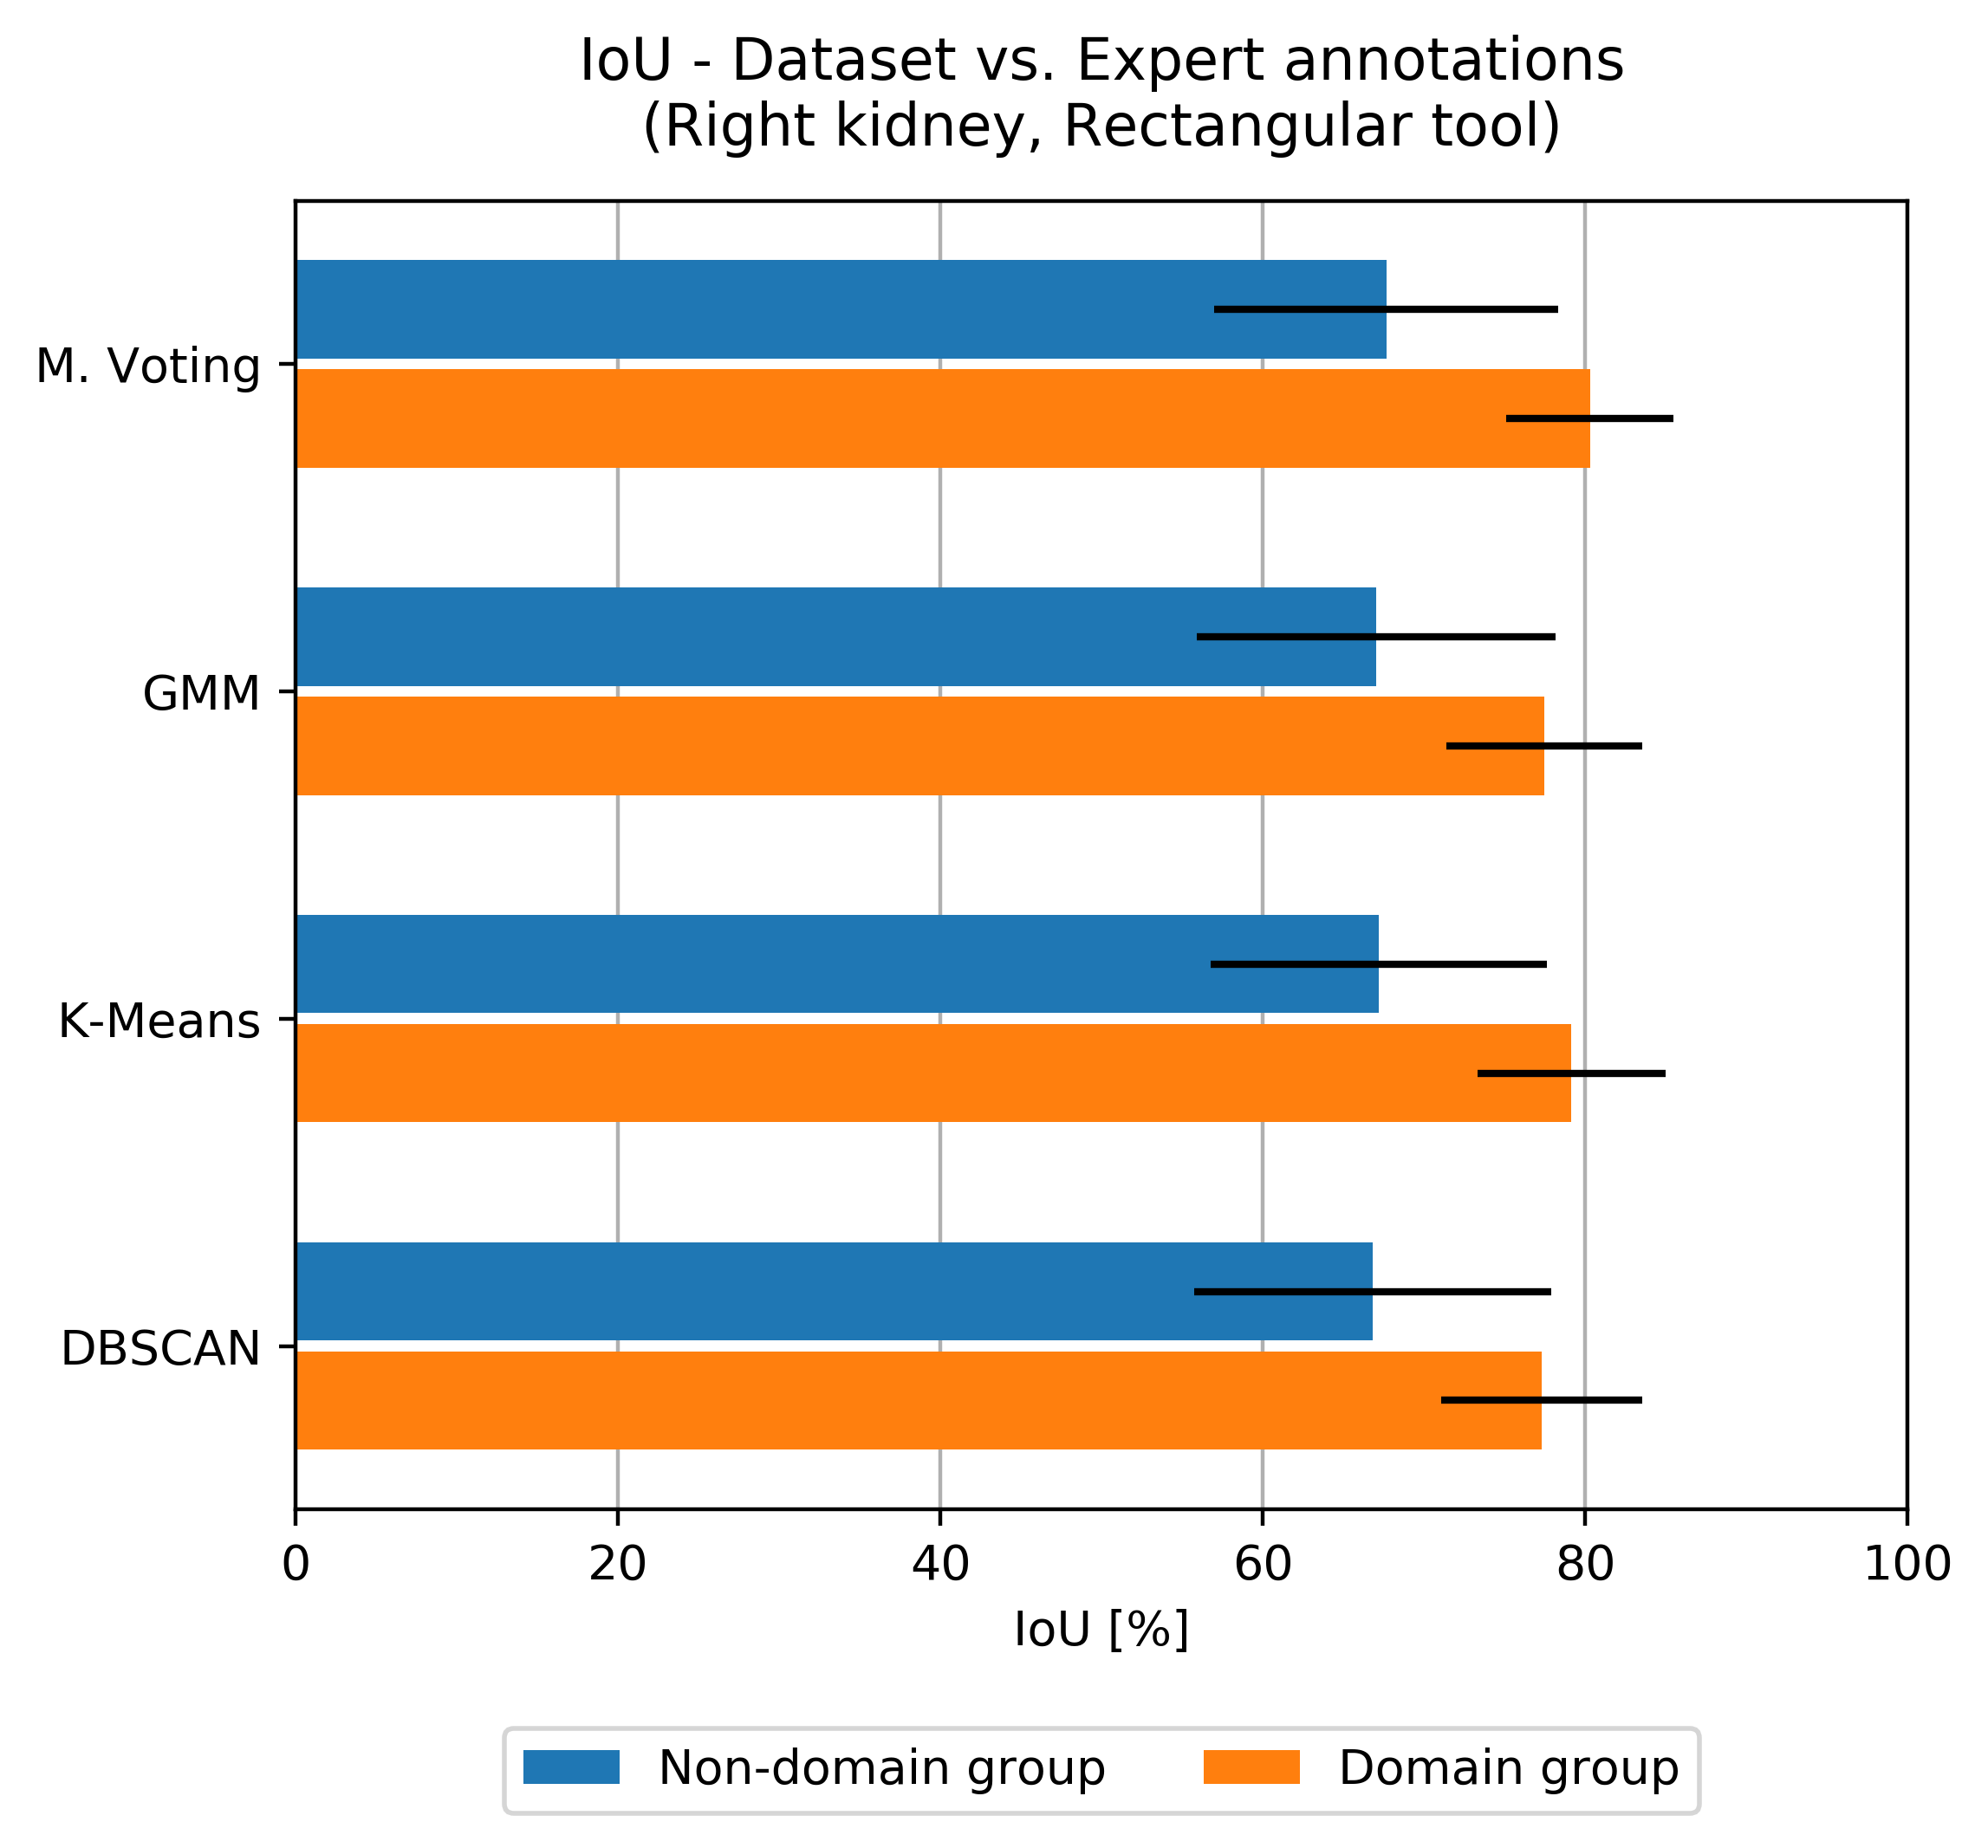

In [22]:
legend = ['Non-domain group', 'Domain group']
plot_jaccard_index(Y, E, groups=2, legend=legend,
                   title='IoU - Dataset vs. Expert annotations\n(Right kidney, Rectangular tool)',
                   save='/Users/jakubpowierza/Downloads/poster_images/3.png')

In [23]:
all_people = [
    (83.231, 10.031, 93.953, 5.508),  # Majority Voting
    (82.917, 9.090, 89.691, 7.764),  # GMM
    (84.117, 7.943, 92.125, 6.247),  # KMeans
    (82.517, 9.610, 89.291, 8.531),  # DBSCAN
]

In [24]:
Y = np.array(list(chain(*[[all_people[i][0], all_people[i][2]]
                          for i in range(4)])))
E = np.array(list(chain(*[[all_people[i][1], all_people[i][3]]
                          for i in range(4)])))

/Users/jakubpowierza/Projects/MedTagger/backend/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


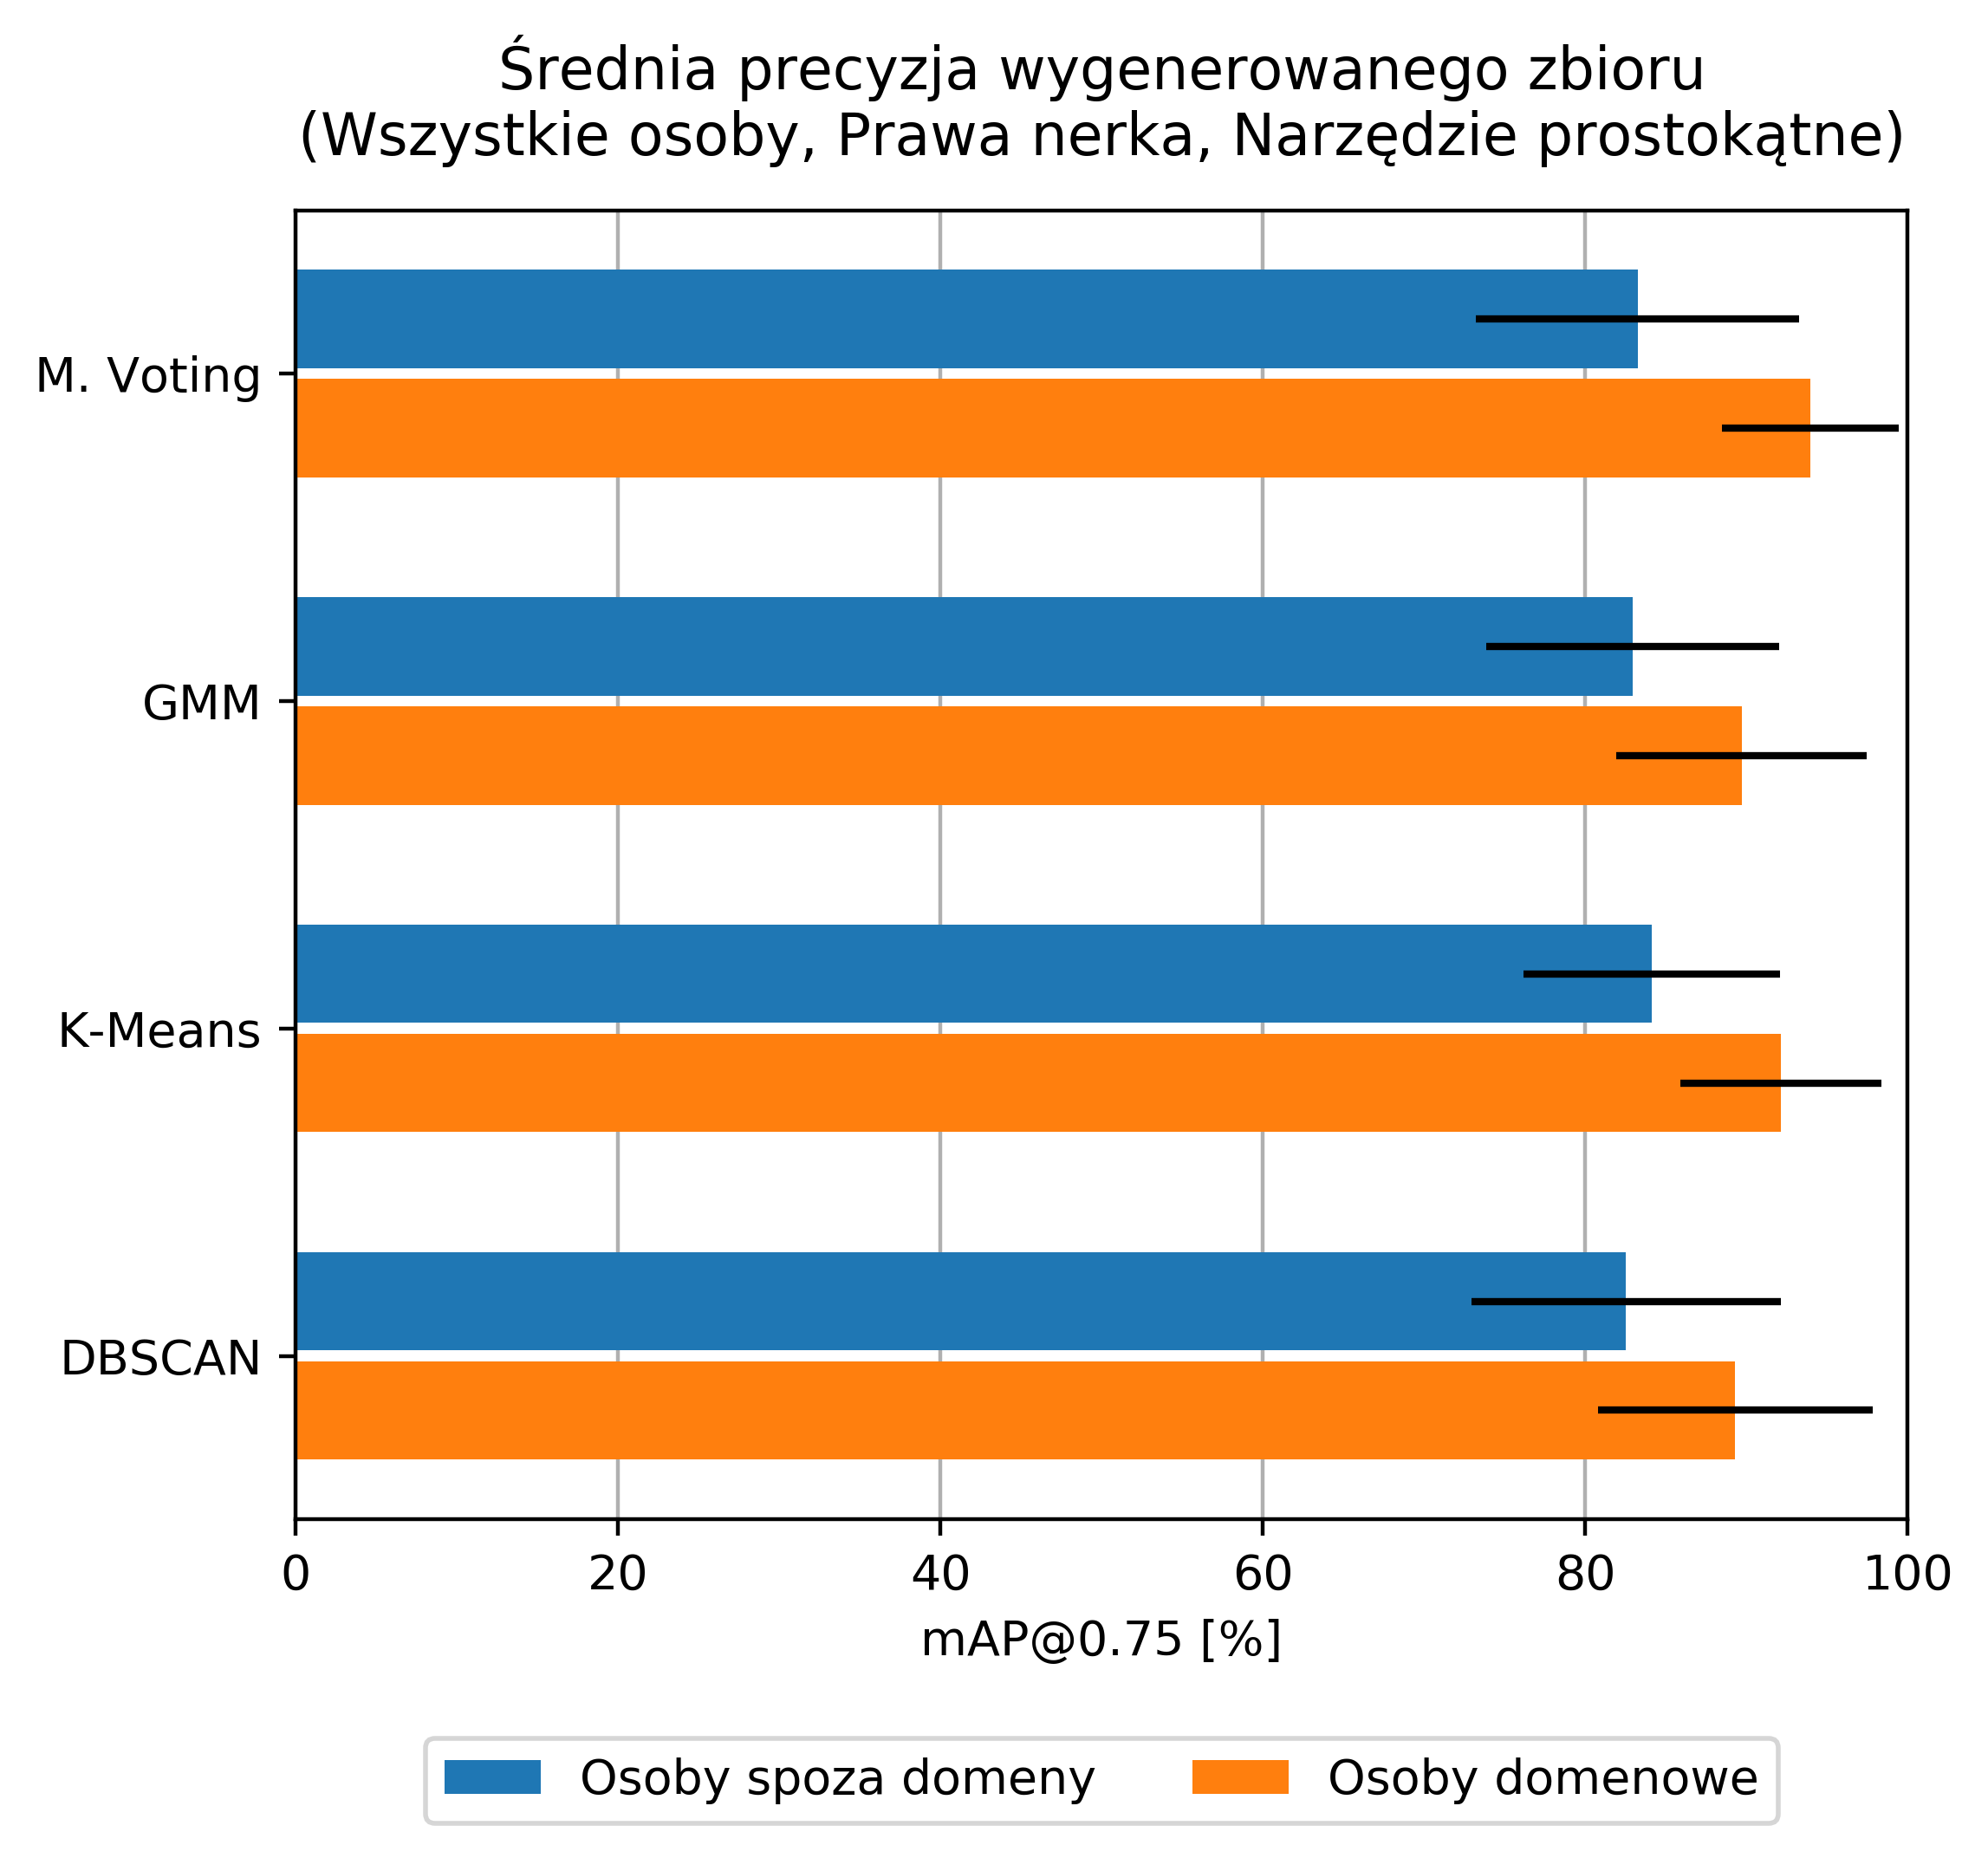

In [25]:
legend = ['Osoby spoza domeny', 'Osoby domenowe']
plot_mean_average_precision(Y, E, groups=2, legend=legend,
                           title='Średnia precyzja wygenerowanego zbioru\n(Wszystkie osoby, Prawa nerka, Narzędzie prostokątne)')

### 50% najbardziej zgodnych osób

In [26]:
fifty_percent_people = [
    (71.705, 3.328, 81.520, 4.916),  # Majority Voting
    (71.519, 2.601, 78.725, 5.113),  # GMM
    (70.145, 2.820, 79.892, 5.311),  # KMeans
    (70.908, 3.216, 78.702, 5.148),  # DBSCAN
]

In [27]:
Y = np.array(list(chain(*[[fifty_percent_people[i][0], fifty_percent_people[i][2]]
                          for i in range(4)])))
E = np.array(list(chain(*[[fifty_percent_people[i][1], fifty_percent_people[i][3]]
                          for i in range(4)])))

/Users/jakubpowierza/Projects/MedTagger/backend/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


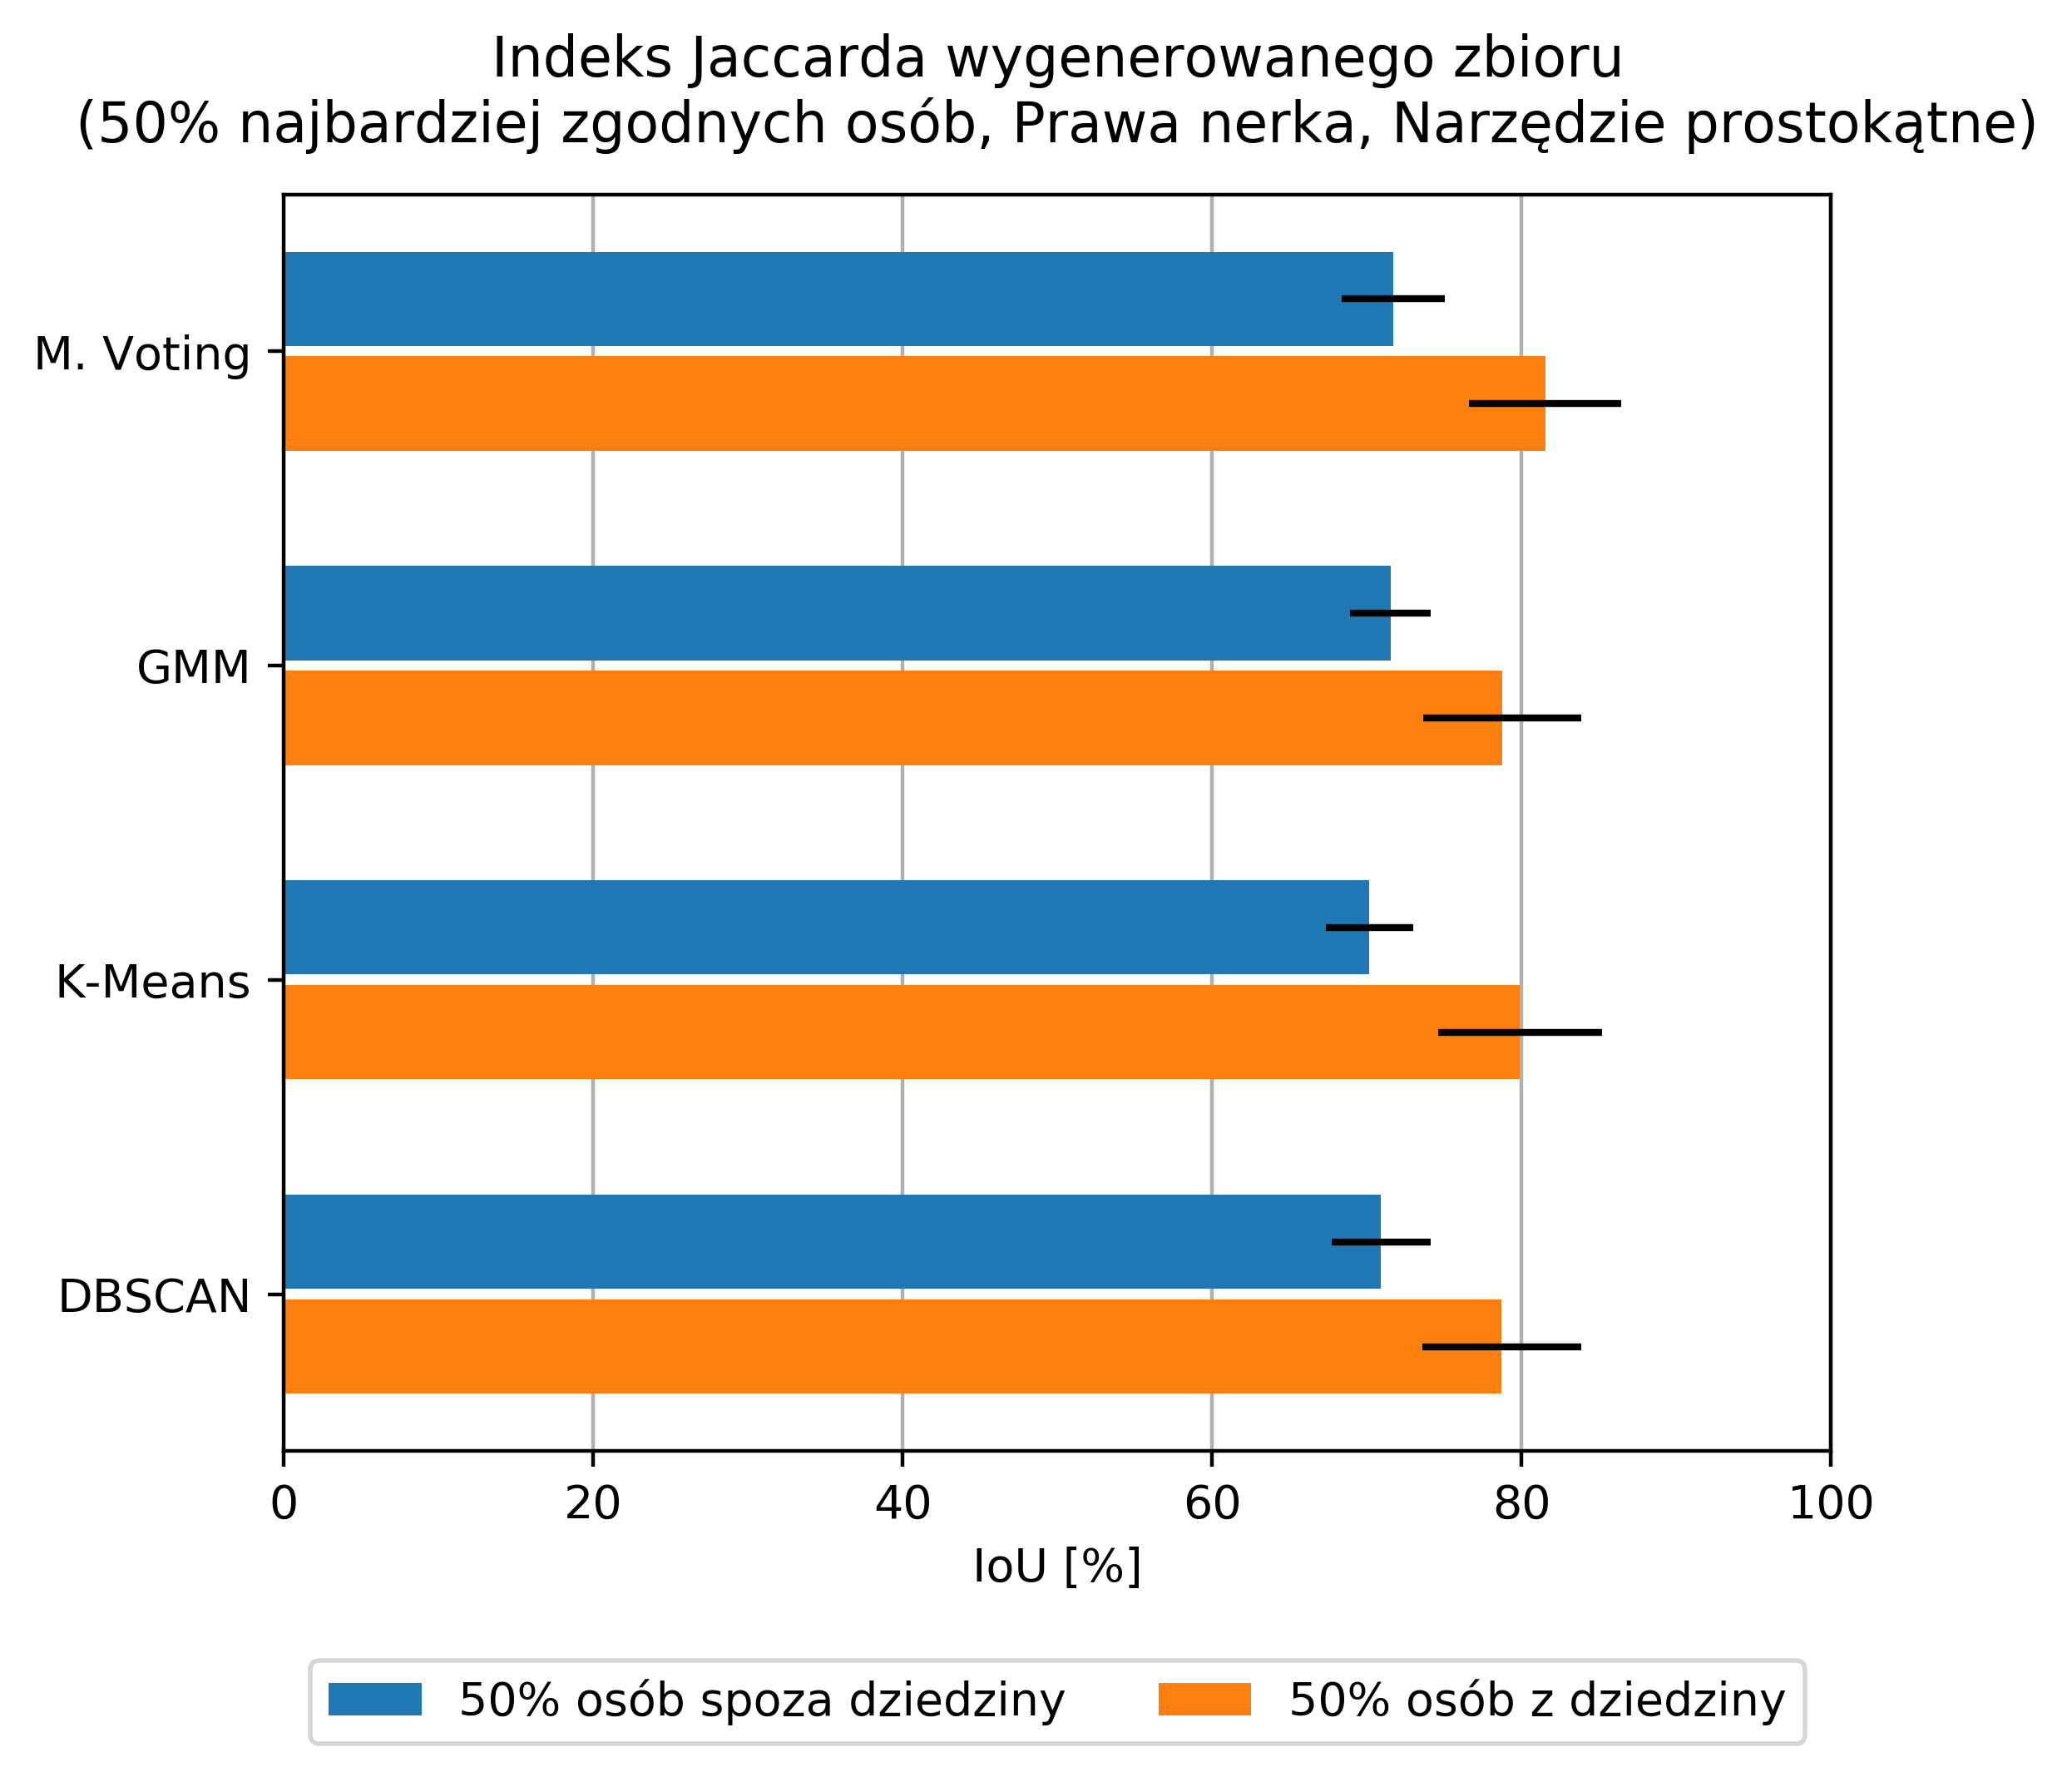

In [28]:
legend = ['50% osób spoza dziedziny', '50% osób z dziedziny']
plot_jaccard_index(Y, E, groups=2, legend=legend,
                   title='Indeks Jaccarda wygenerowanego zbioru\n(50% najbardziej zgodnych osób, Prawa nerka, Narzędzie prostokątne)')

In [29]:
all_people = [
    (87.582, 8.838, 93.953, 5.508),  # Majority Voting
    (86.553, 7.491, 91.120, 7.502),  # GMM
    (85.925, 5.580, 91.410, 5.821),  # KMeans
    (86.468, 9.322, 91.120, 7.502),  # DBSCAN
]

In [30]:
Y = np.array(list(chain(*[[all_people[i][0], all_people[i][2]]
                          for i in range(4)])))
E = np.array(list(chain(*[[all_people[i][1], all_people[i][3]]
                          for i in range(4)])))

/Users/jakubpowierza/Projects/MedTagger/backend/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


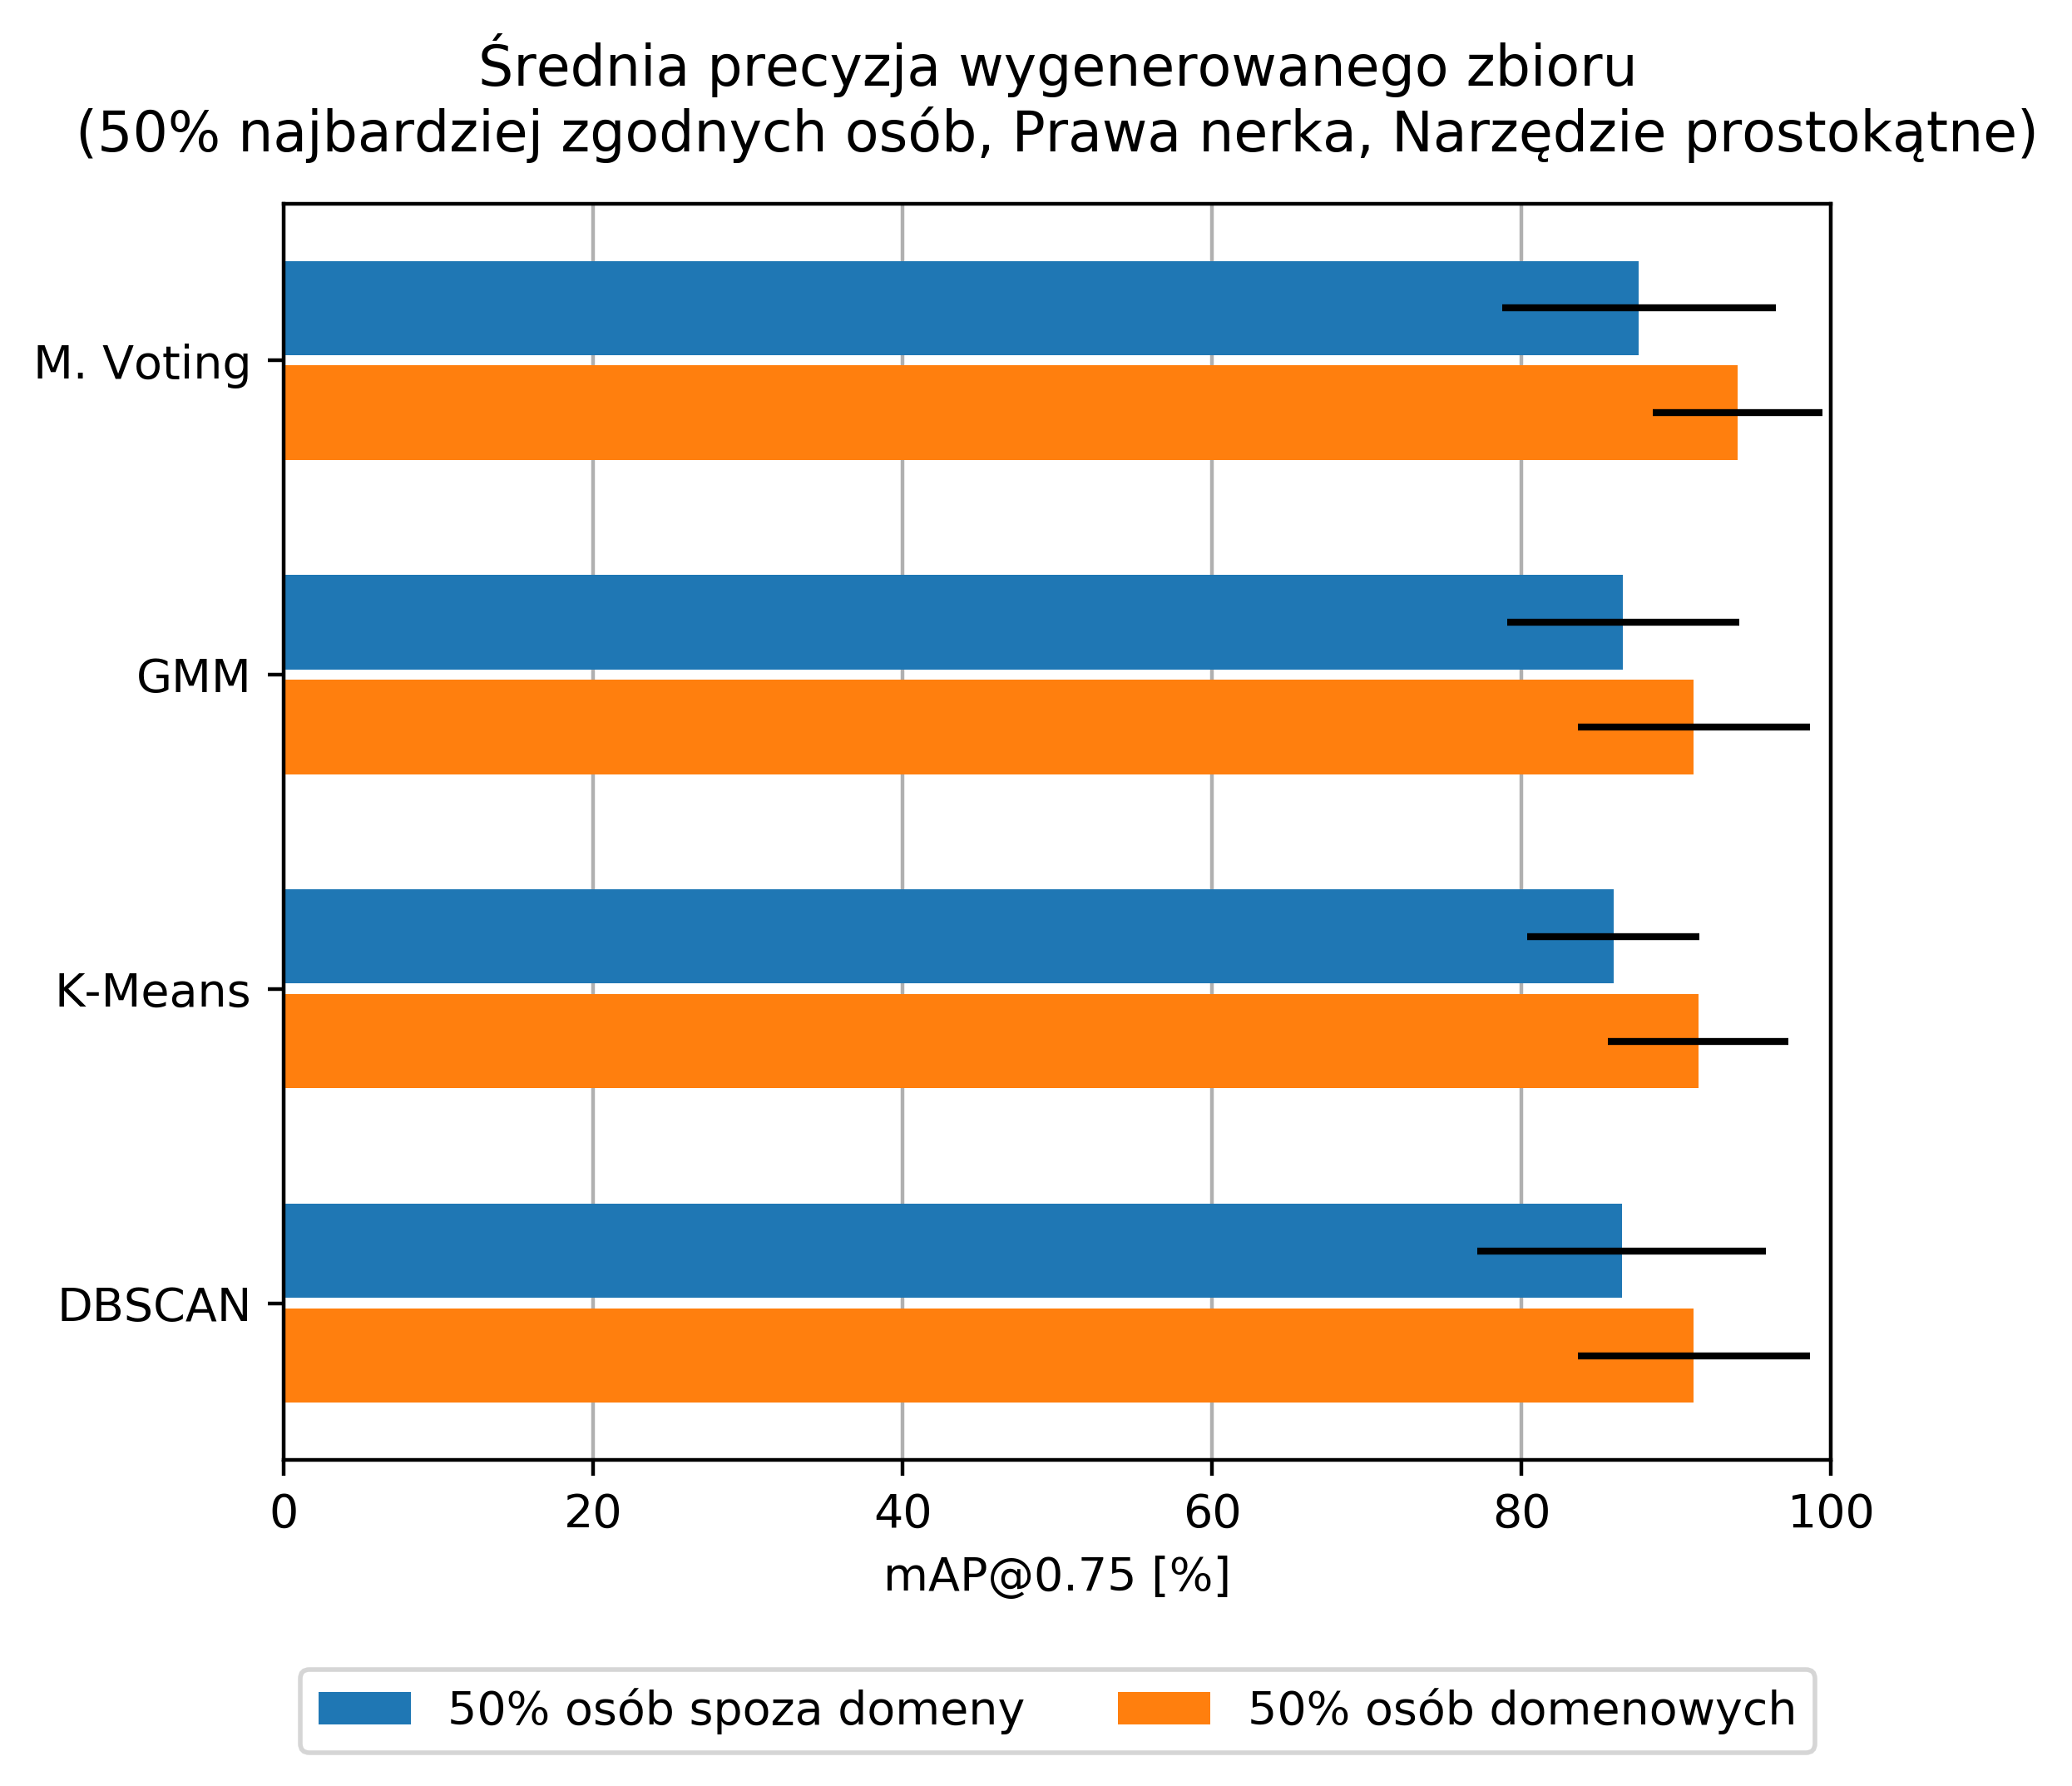

In [31]:
legend = ['50% osób spoza domeny', '50% osób domenowych']
plot_mean_average_precision(Y, E, groups=2, legend=legend,
                            title='Średnia precyzja wygenerowanego zbioru\n(50% najbardziej zgodnych osób, Prawa nerka, Narzędzie prostokątne)')

### 25% najbardziej zgodnych osób

In [32]:
twentyfive_percent_people = [
    (74.519, 6.091, 82.030, 4.897),  # Majority Voting
    (74.160, 4.478, 78.791, 6.130),  # GMM
    (74.685, 5.823, 81.370, 5.228),  # KMeans
    (74.161, 4.478, 78.793, 6.129),  # DBSCAN
]

In [33]:
Y = np.array(list(chain(*[[twentyfive_percent_people[i][0], twentyfive_percent_people[i][2]]
                          for i in range(4)])))
E = np.array(list(chain(*[[twentyfive_percent_people[i][1], twentyfive_percent_people[i][3]]
                          for i in range(4)])))

/Users/jakubpowierza/Projects/MedTagger/backend/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


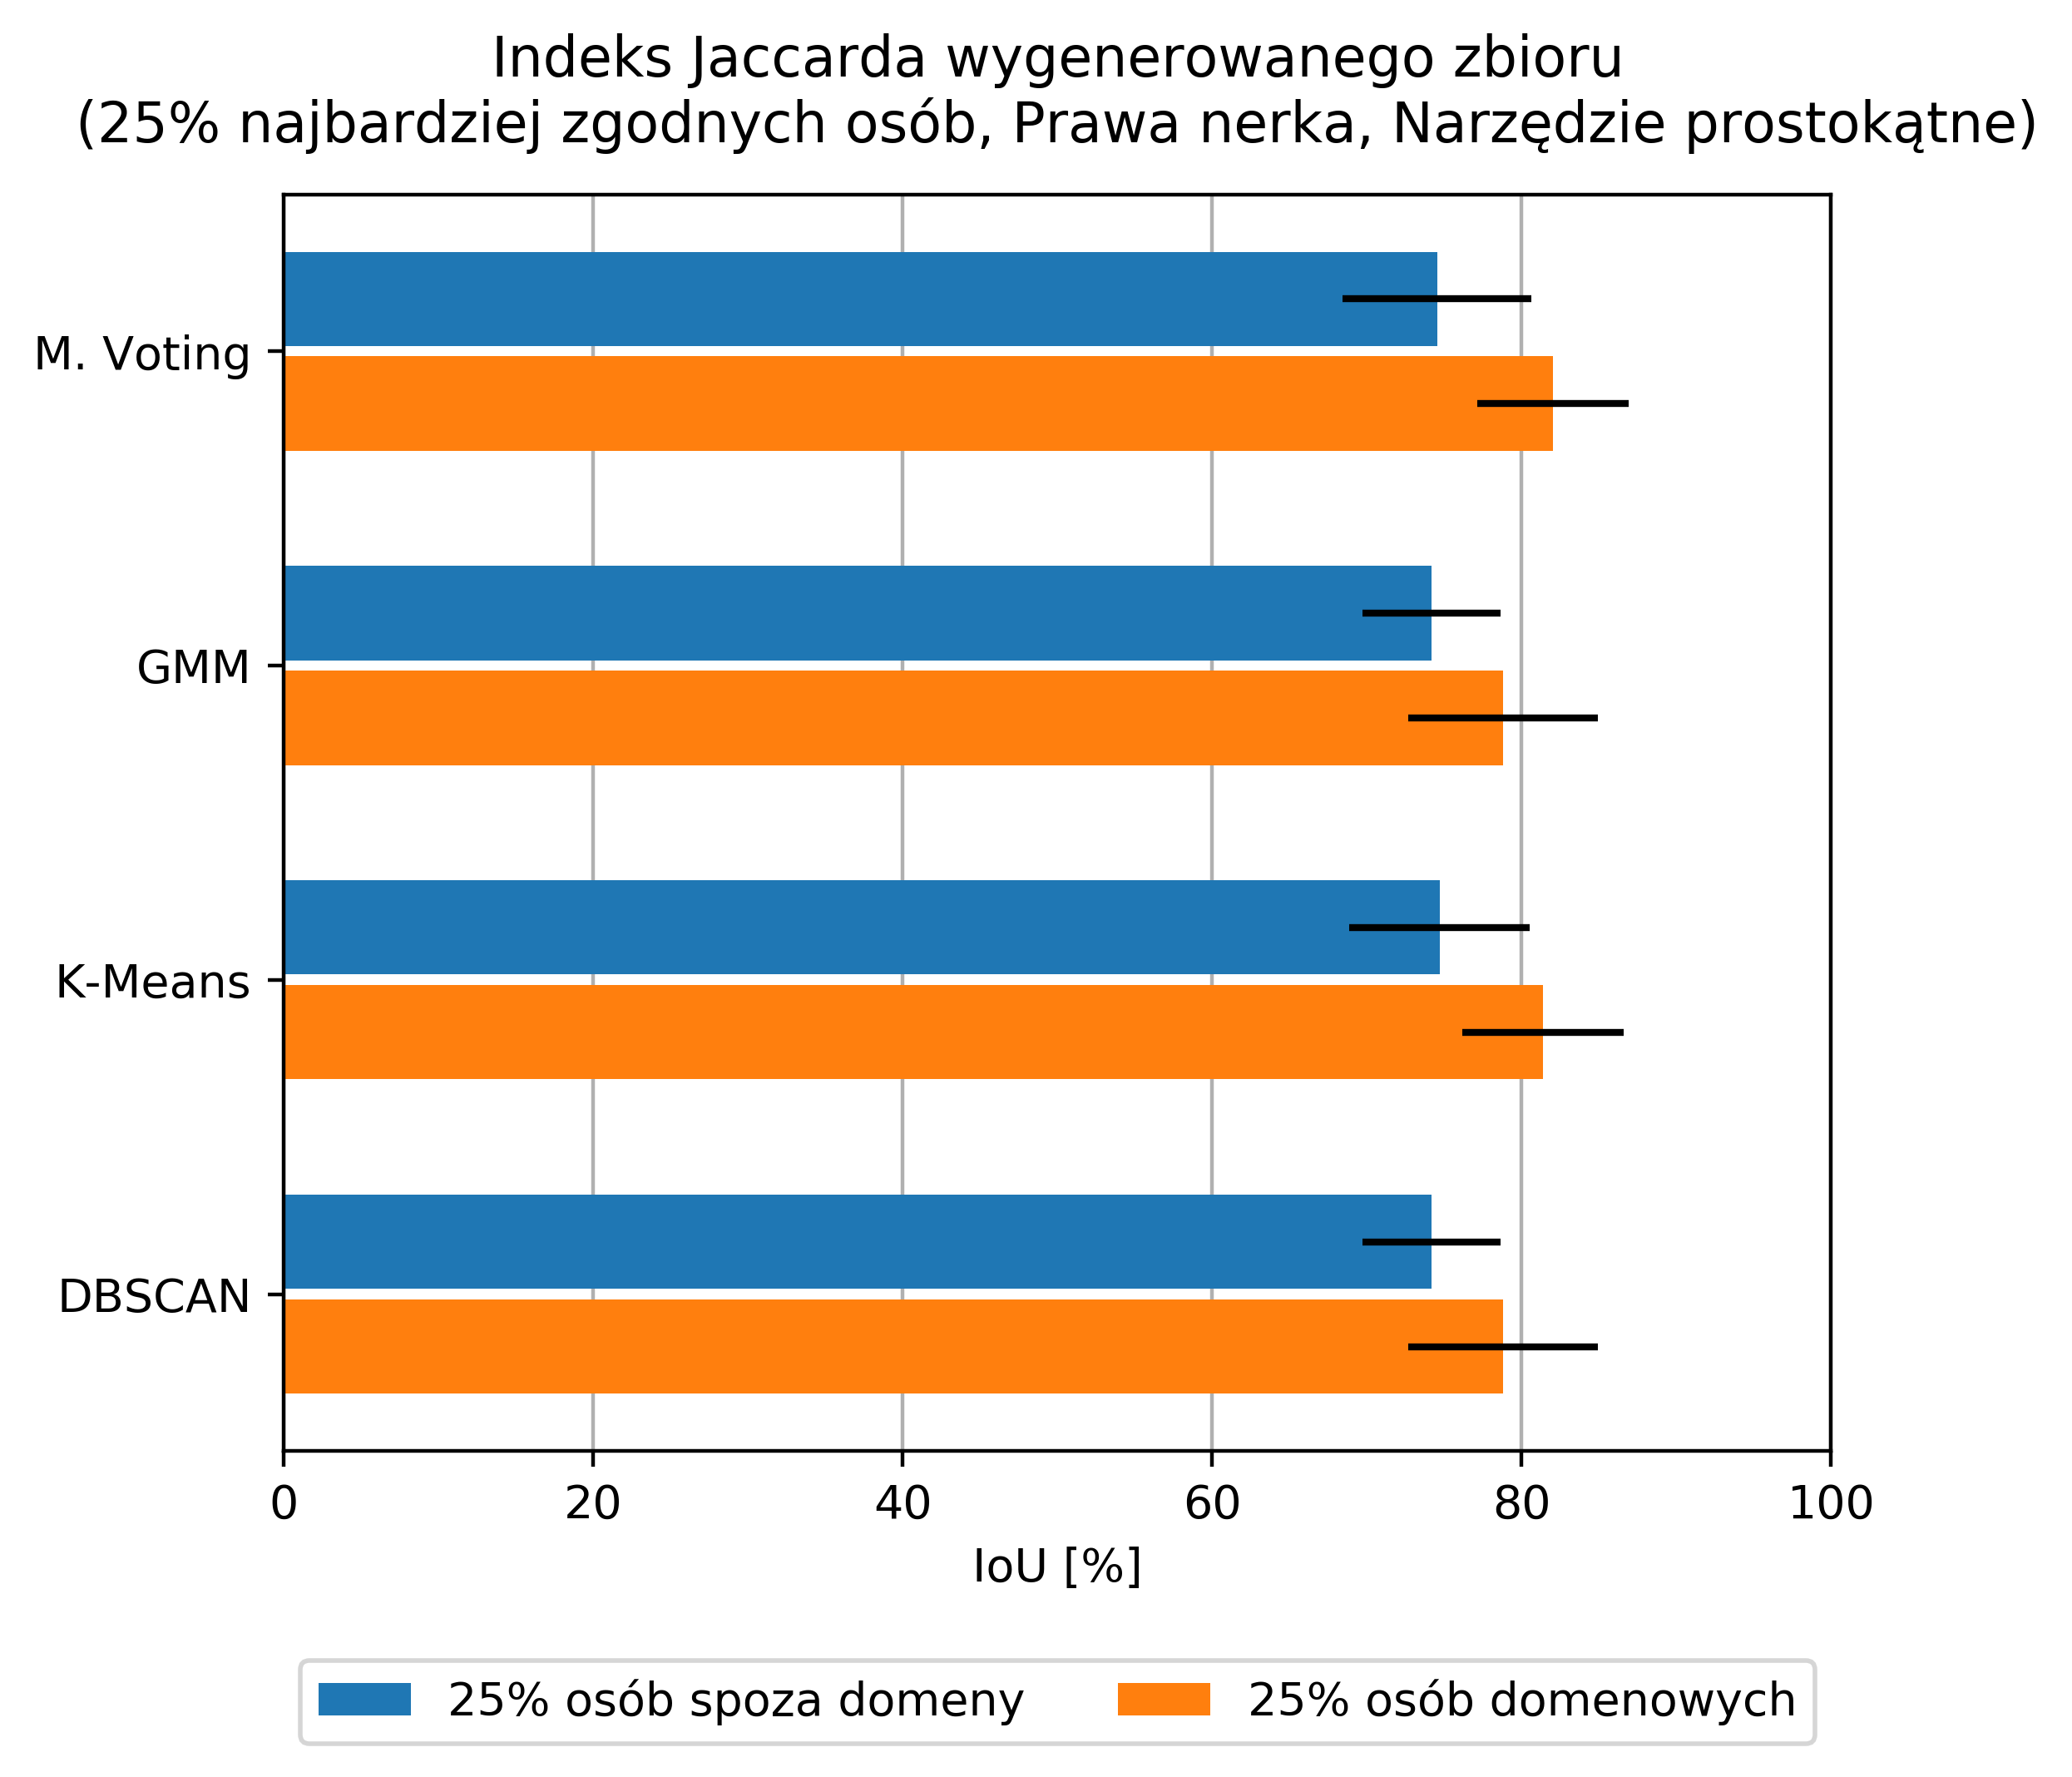

In [34]:
legend = ['25% osób spoza domeny', '25% osób domenowych']
plot_jaccard_index(Y, E, groups=2, legend=legend,
                   title='Indeks Jaccarda wygenerowanego zbioru\n(25% najbardziej zgodnych osób, Prawa nerka, Narzędzie prostokątne)')

In [35]:
all_people = [
    (87.582, 8.838, 93.953, 5.508),  # Majority Voting
    (86.553, 7.491, 91.120, 7.502),  # GMM
    (85.925, 5.580, 91.410, 5.821),  # KMeans
    (86.468, 9.322, 91.120, 7.502),  # DBSCAN
]

In [36]:
Y = np.array(list(chain(*[[all_people[i][0], all_people[i][2]]
                          for i in range(4)])))
E = np.array(list(chain(*[[all_people[i][1], all_people[i][3]]
                          for i in range(4)])))

/Users/jakubpowierza/Projects/MedTagger/backend/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


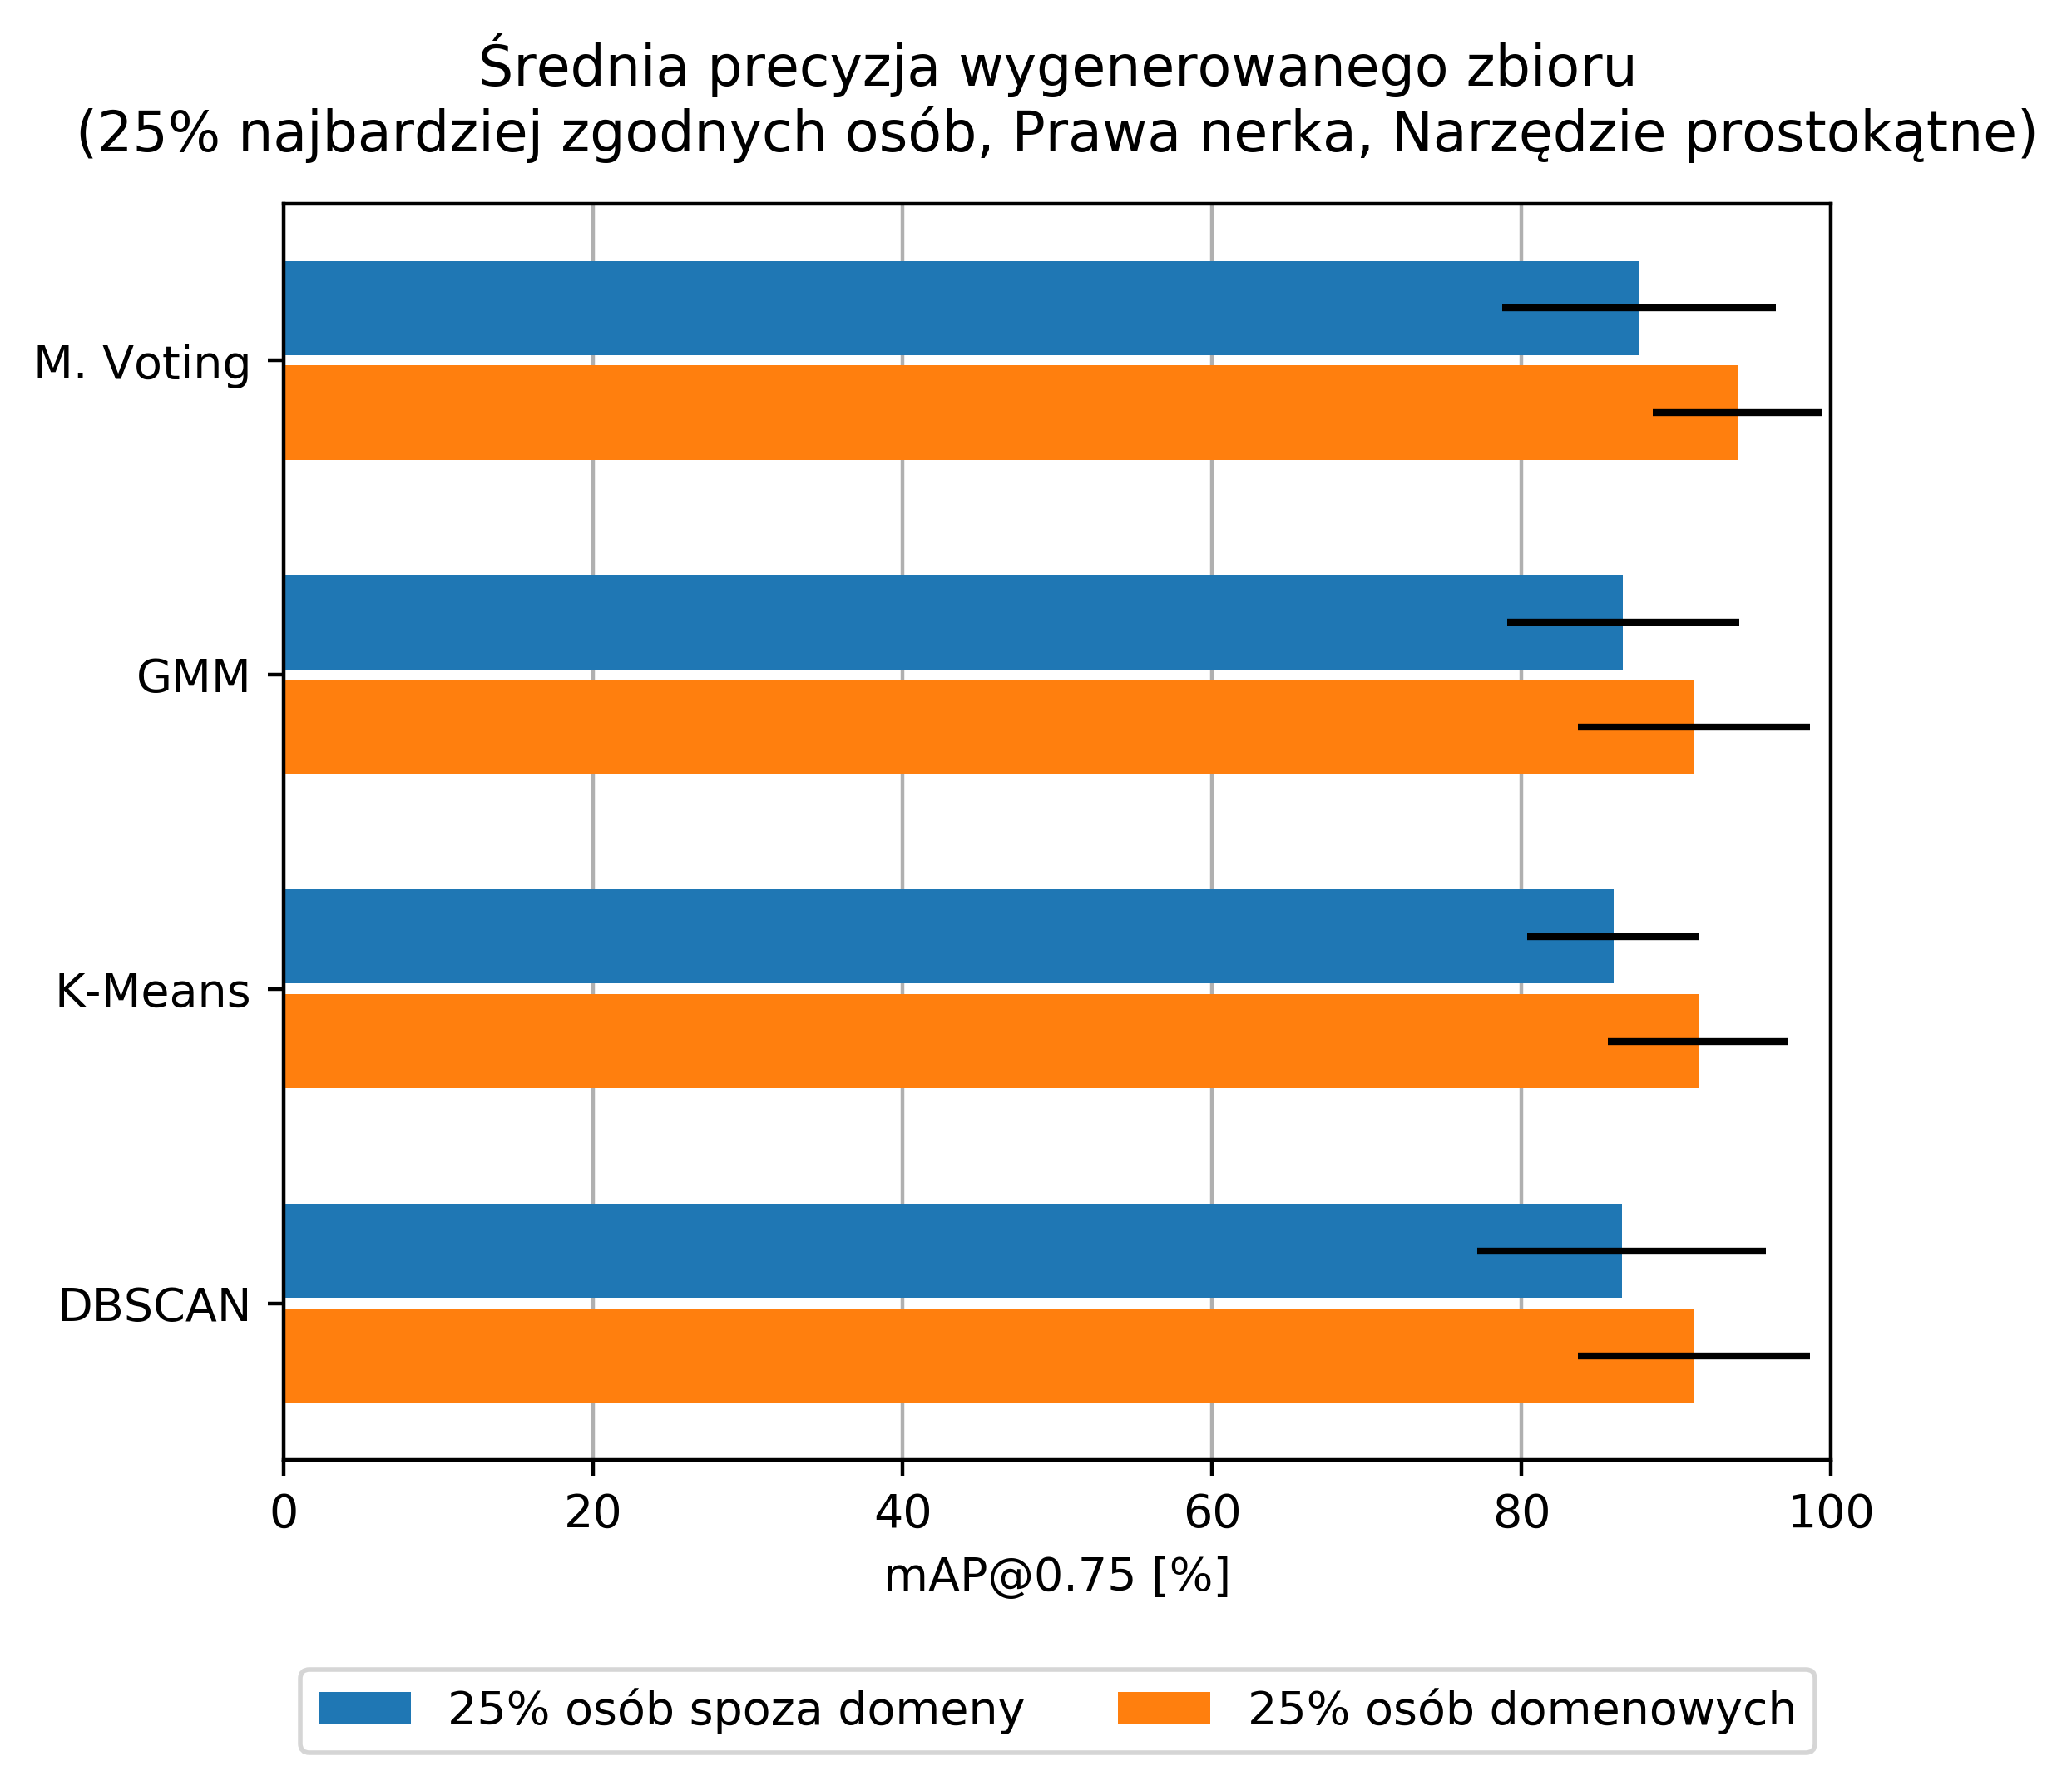

In [37]:
legend = ['25% osób spoza domeny', '25% osób domenowych']
plot_mean_average_precision(Y, E, groups=2, legend=legend,
                           title='Średnia precyzja wygenerowanego zbioru\n(25% najbardziej zgodnych osób, Prawa nerka, Narzędzie prostokątne)')

## Wielokąty

### Wszyscy ludzie

In [38]:
all_people = [
    (81.928, 5.733, 90.526, 1.078),  # Majority Voting
    (58.405, 6.102, 71.841, 4.599),  # GMM
    (58.442, 8.924, 73.748, 5.078),  # KMeans
    (57.714, 7.947, 74.032, 3.230),  # DBSCAN
]

In [39]:
Y = np.array(list(chain(*[[all_people[i][0], all_people[i][2]]
                          for i in range(4)])))
E = np.array(list(chain(*[[all_people[i][1], all_people[i][3]]
                          for i in range(4)])))

/Users/jakubpowierza/Projects/MedTagger/backend/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


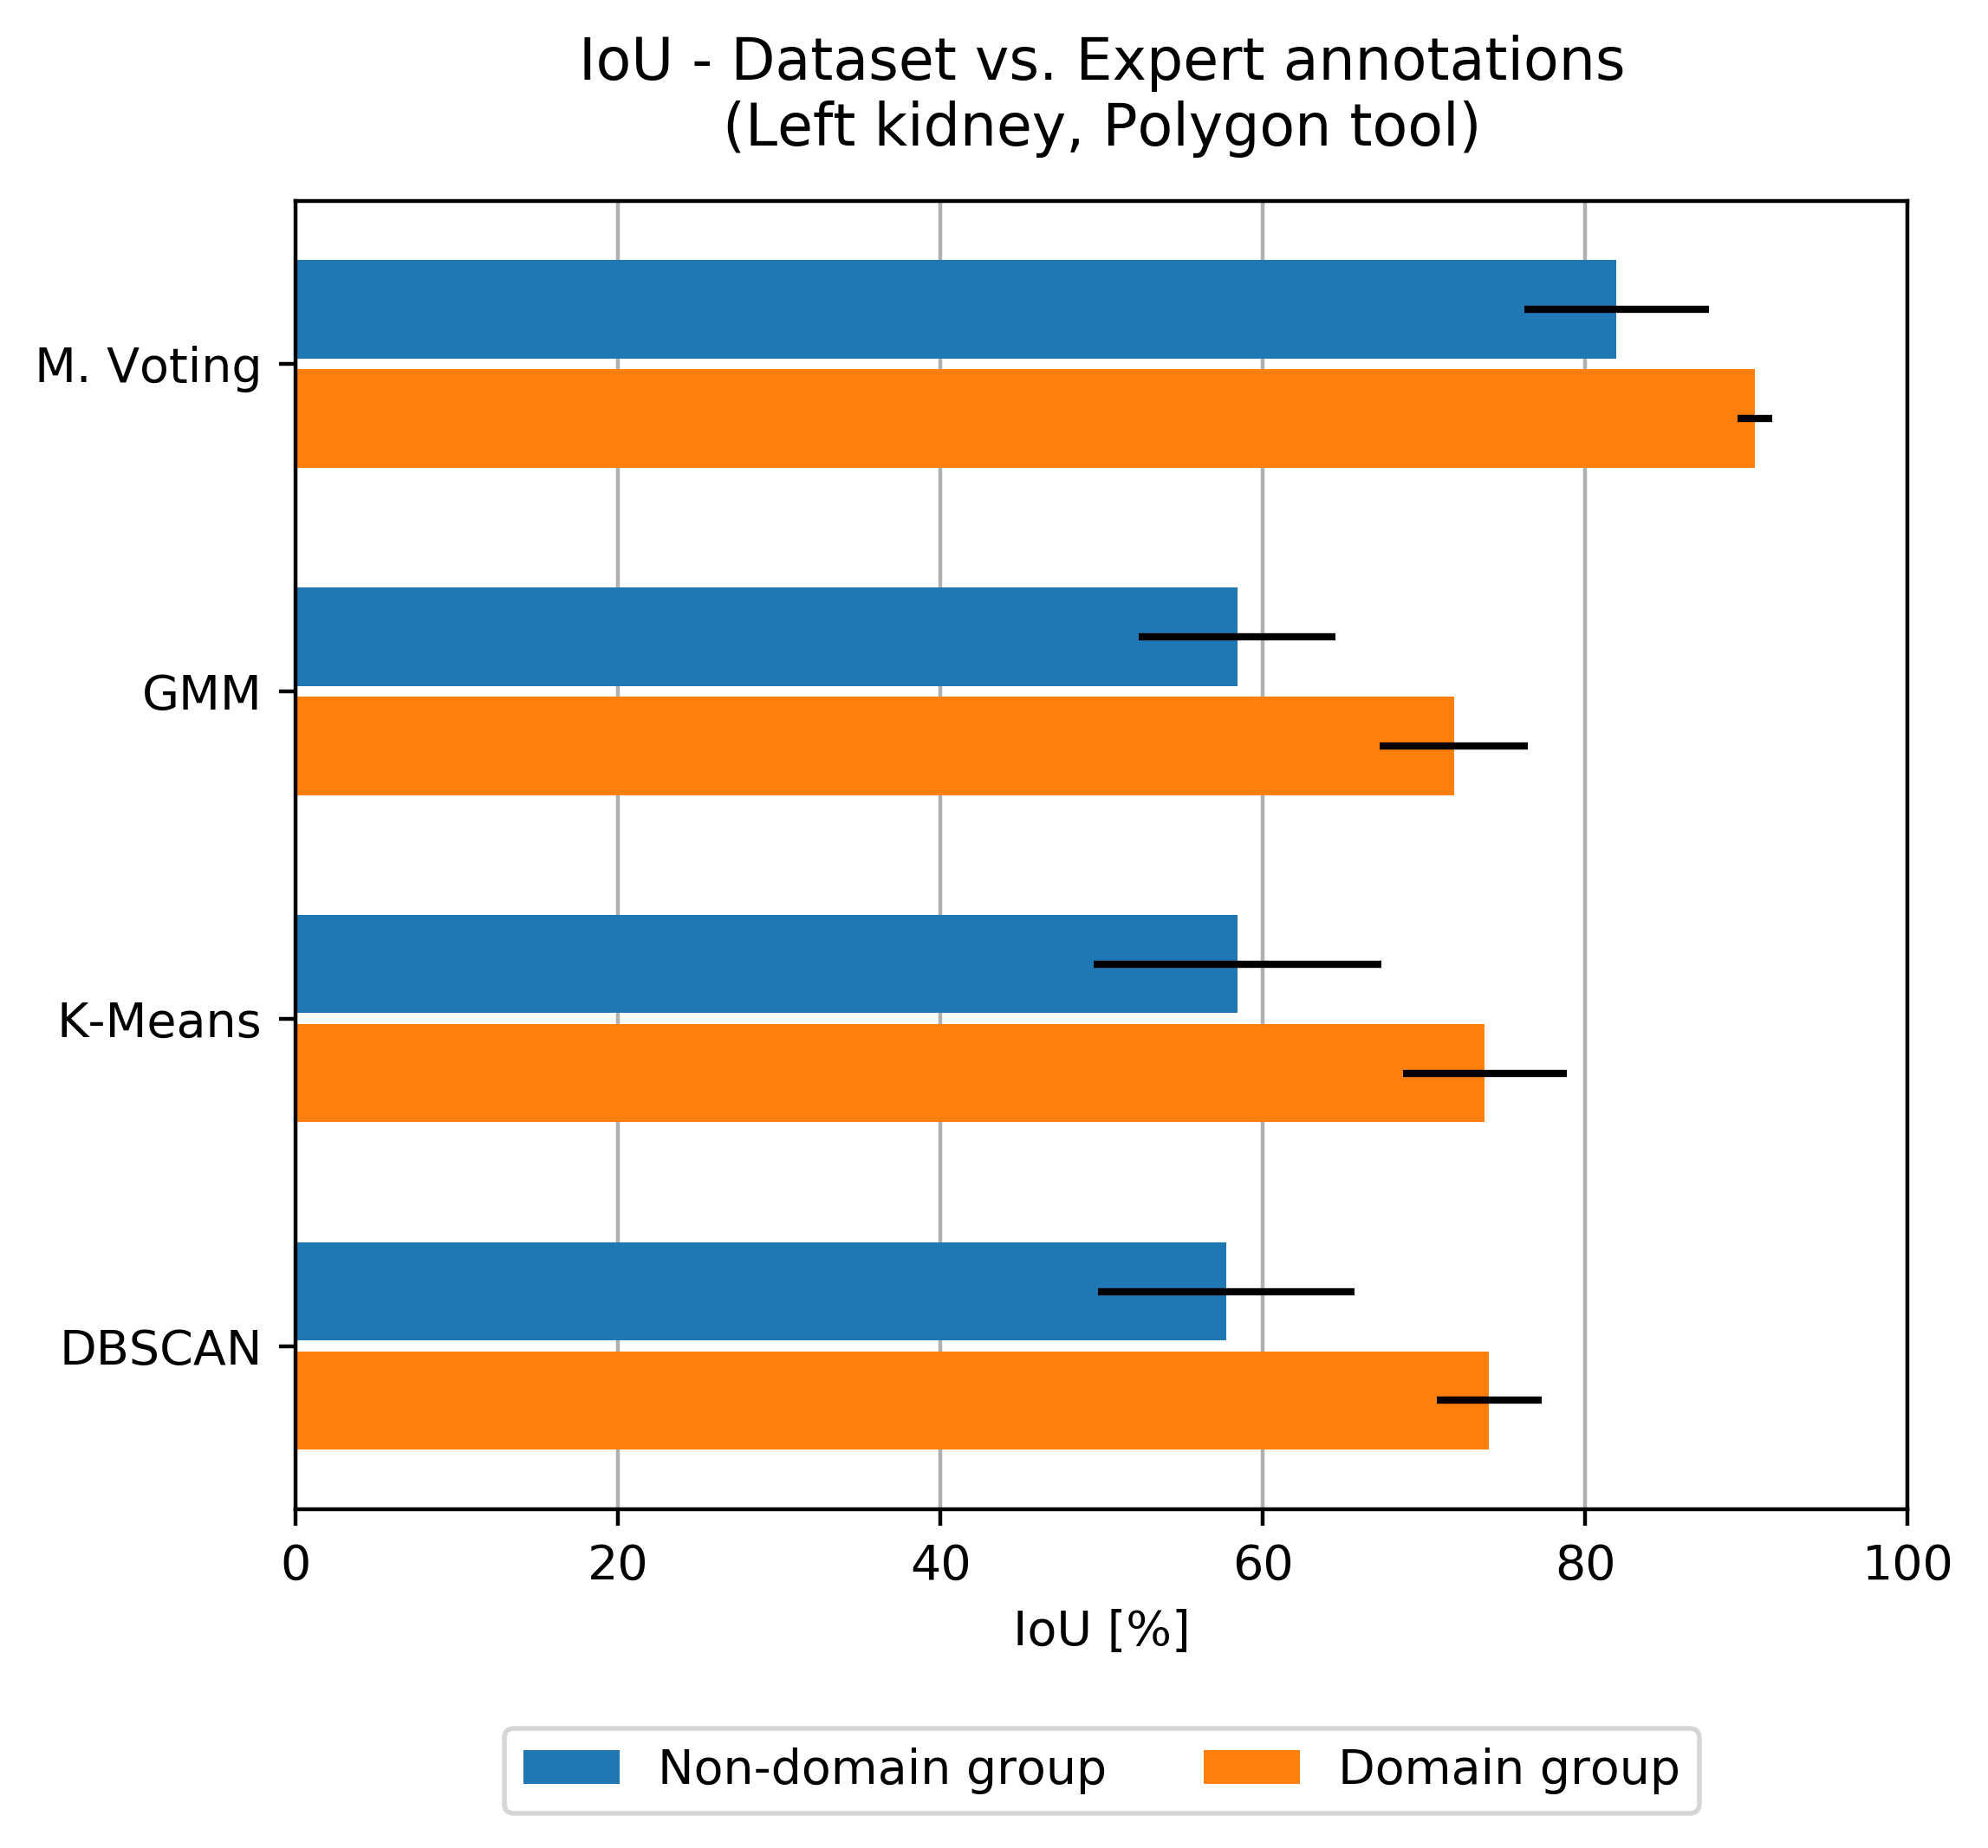

In [40]:
legend = ['Non-domain group', 'Domain group']
plot_jaccard_index(Y, E, groups=2, legend=legend,
                   title='IoU - Dataset vs. Expert annotations\n(Left kidney, Polygon tool)',
                   save='/Users/jakubpowierza/Downloads/poster_images/4.png')

In [41]:
all_people = [
    (79.249, 8.067, 90.468, 3.871),  # Majority Voting
    (75.106, 9.990, 87.039, 5.047),  # GMM
    (78.849, 8.782, 90.468, 3.871),  # KMeans
    (77.021, 7.892, 86.725, 4.986),  # DBSCAN
]

In [42]:
Y = np.array(list(chain(*[[all_people[i][0], all_people[i][2]]
                          for i in range(4)])))
E = np.array(list(chain(*[[all_people[i][1], all_people[i][3]]
                          for i in range(4)])))

/Users/jakubpowierza/Projects/MedTagger/backend/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


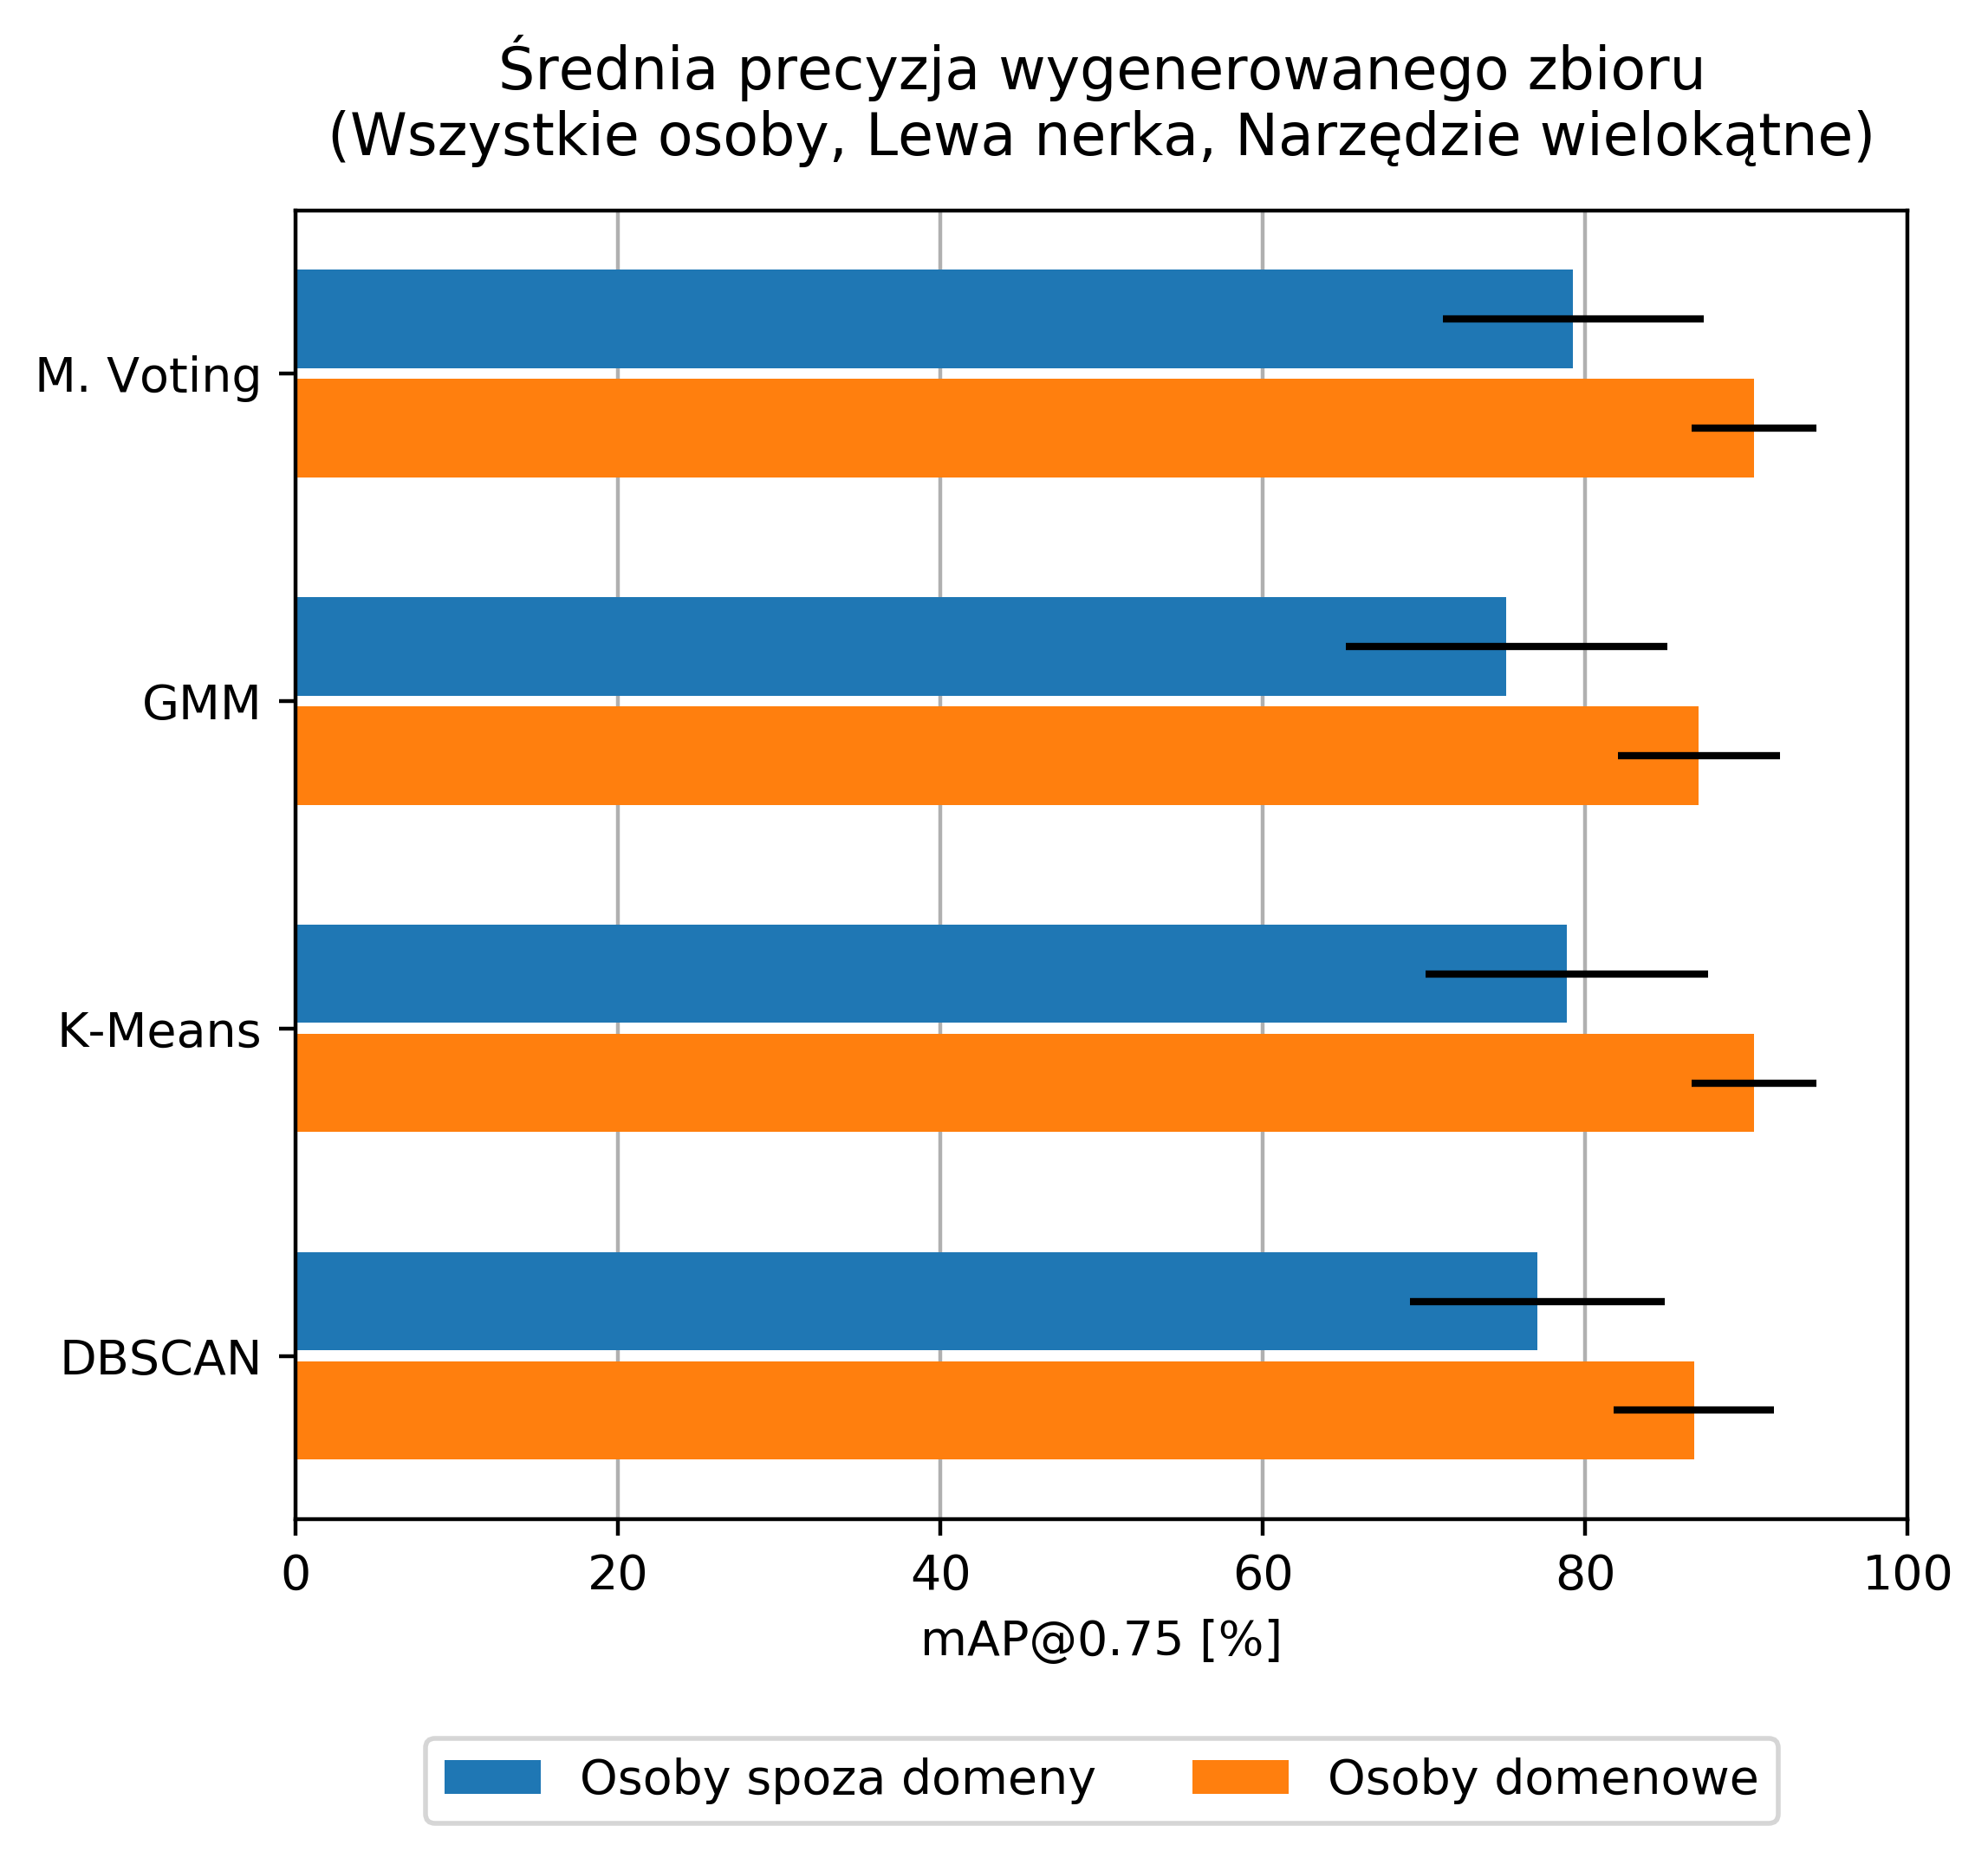

In [43]:
legend = ['Osoby spoza domeny', 'Osoby domenowe']
plot_mean_average_precision(Y, E, groups=2, legend=legend,
                           title='Średnia precyzja wygenerowanego zbioru\n(Wszystkie osoby, Lewa nerka, Narzędzie wielokątne)')

### 50% najbardziej zgodnych osób

In [44]:
fifty_percent_people = [
    (63.229, 9.350, 75.491, 4.087),  # Majority Voting
    (60.741, 7.474, 72.476, 4.418),  # GMM
    (61.581, 9.064, 73.387, 4.780),  # KMeans
    (59.539, 9.306, 74.040, 3.238),  # DBSCAN
]

In [45]:
Y = np.array(list(chain(*[[fifty_percent_people[i][0], fifty_percent_people[i][2]]
                          for i in range(4)])))
E = np.array(list(chain(*[[fifty_percent_people[i][1], fifty_percent_people[i][3]]
                          for i in range(4)])))

/Users/jakubpowierza/Projects/MedTagger/backend/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


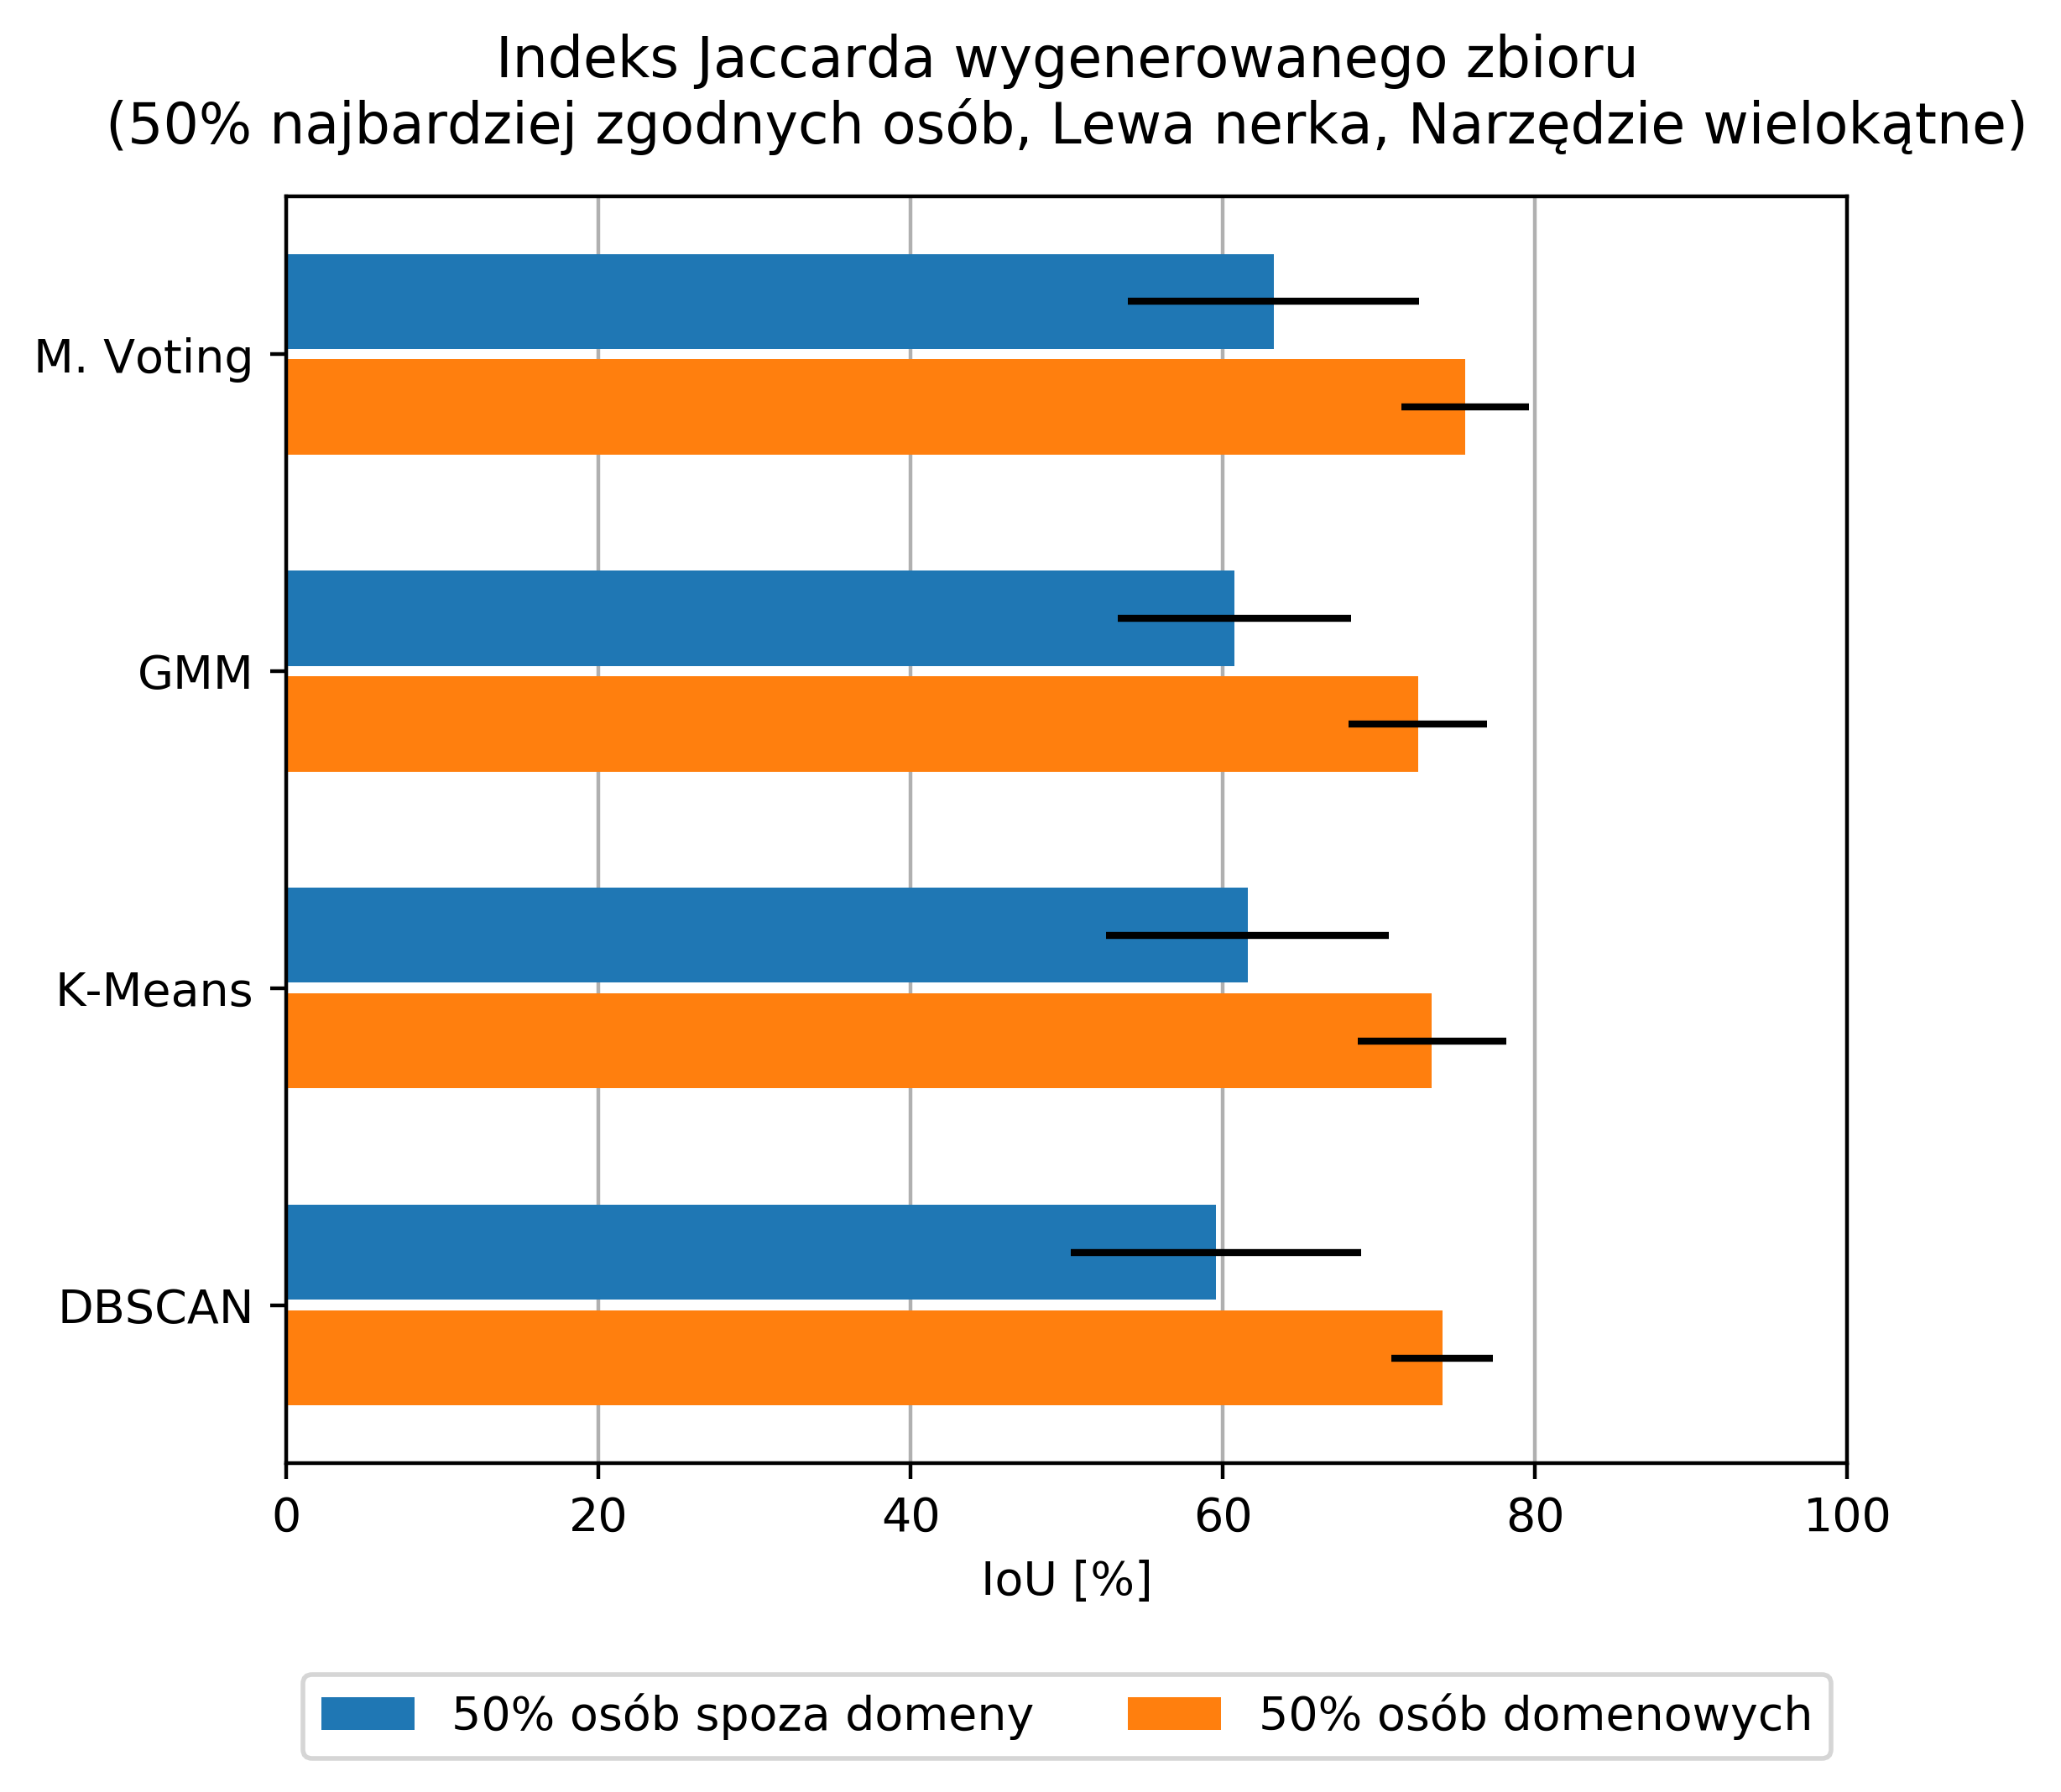

In [46]:
legend = ['50% osób spoza domeny', '50% osób domenowych']
plot_jaccard_index(Y, E, groups=2, legend=legend,
                   title='Indeks Jaccarda wygenerowanego zbioru\n(50% najbardziej zgodnych osób, Lewa nerka, Narzędzie wielokątne)')

In [47]:
all_people = [
    (81.987, 8.554, 88.325, 4.332),  # Majority Voting
    (76.816, 9.956, 87.210, 4.938),  # GMM
    (80.873, 8.270, 89.753, 4.433),  # KMeans
    (79.758, 8.299, 86.725, 4.986),  # DBSCAN
]

In [48]:
Y = np.array(list(chain(*[[all_people[i][0], all_people[i][2]]
                          for i in range(4)])))
E = np.array(list(chain(*[[all_people[i][1], all_people[i][3]]
                          for i in range(4)])))

/Users/jakubpowierza/Projects/MedTagger/backend/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


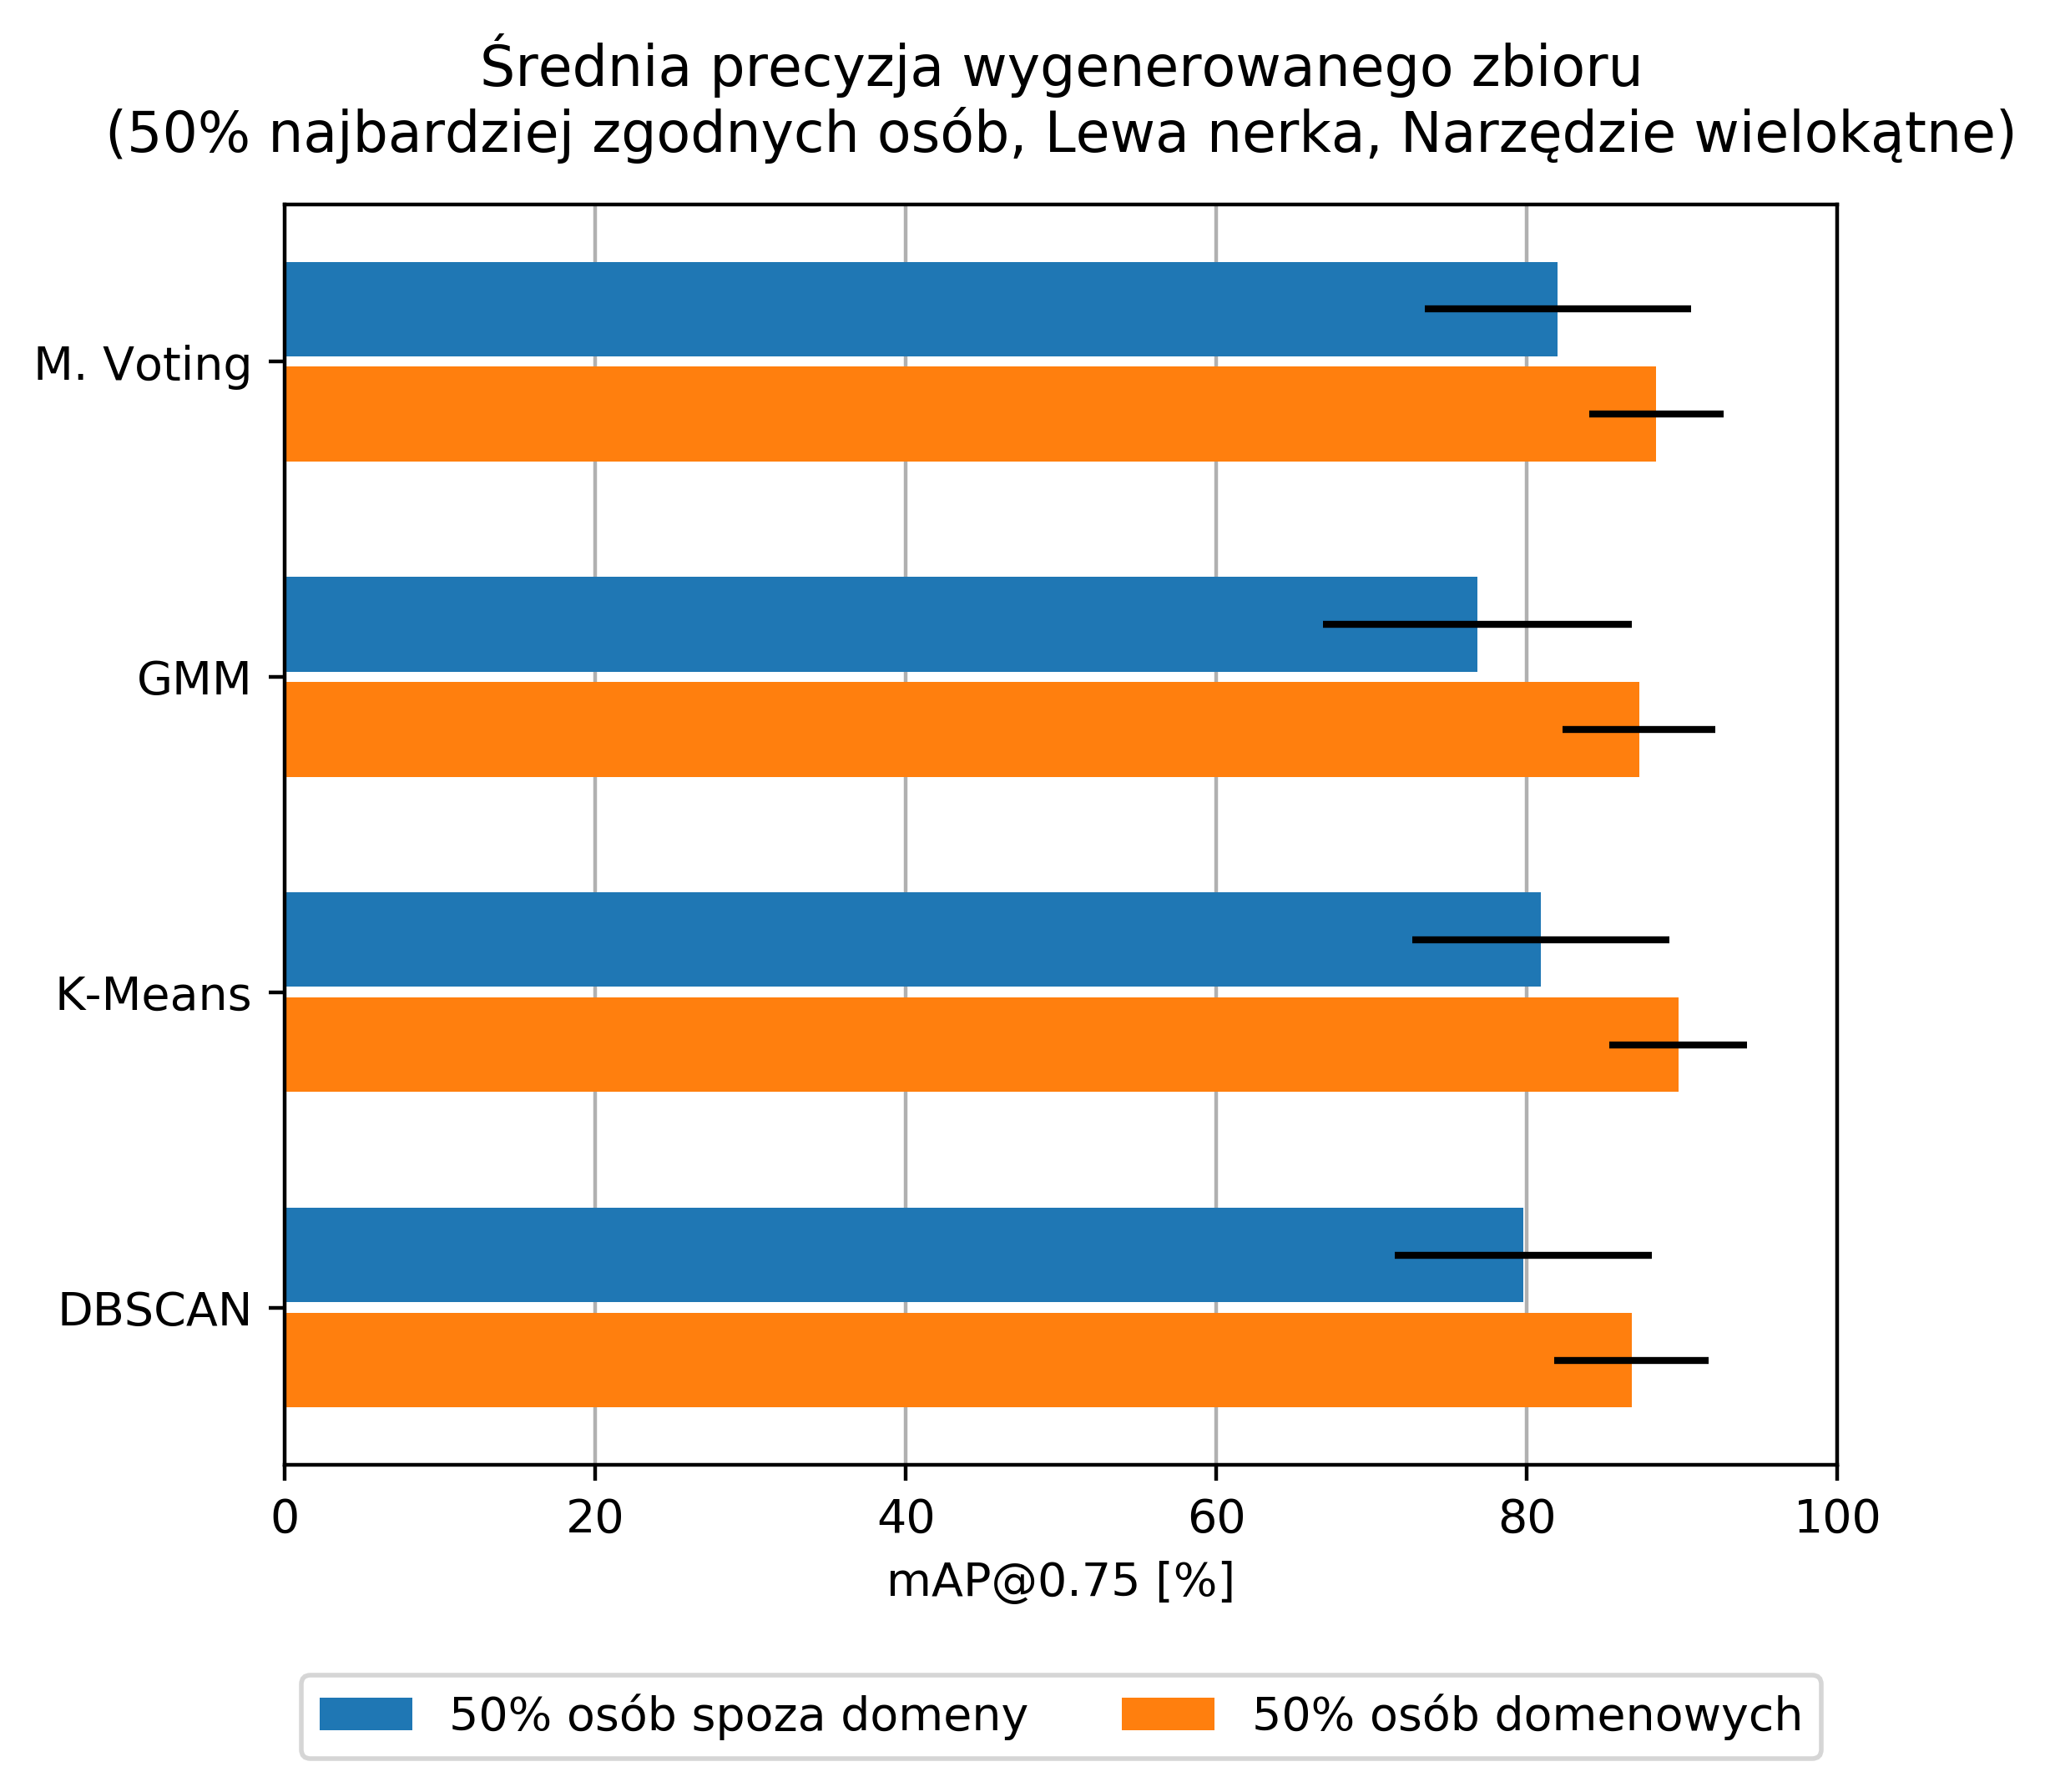

In [49]:
legend = ['50% osób spoza domeny', '50% osób domenowych']
plot_mean_average_precision(Y, E, groups=2, legend=legend,
                            title='Średnia precyzja wygenerowanego zbioru\n(50% najbardziej zgodnych osób, Lewa nerka, Narzędzie wielokątne)')

### 25% najbardziej zgodnych osób

In [50]:
twentyfive_percent_people = [
    (63.280, 9.828, 72.247, 4.218),  # Majority Voting
    (61.317, 9.927, 70.432, 4.472),  # GMM
    (61.121, 9.177, 72.328, 4.639),  # KMeans
    (59.180, 11.165, 66.900, 16.051),  # DBSCAN
]

In [51]:
Y = np.array(list(chain(*[[twentyfive_percent_people[i][0], twentyfive_percent_people[i][2]]
                          for i in range(4)])))
E = np.array(list(chain(*[[twentyfive_percent_people[i][1], twentyfive_percent_people[i][3]]
                          for i in range(4)])))

/Users/jakubpowierza/Projects/MedTagger/backend/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


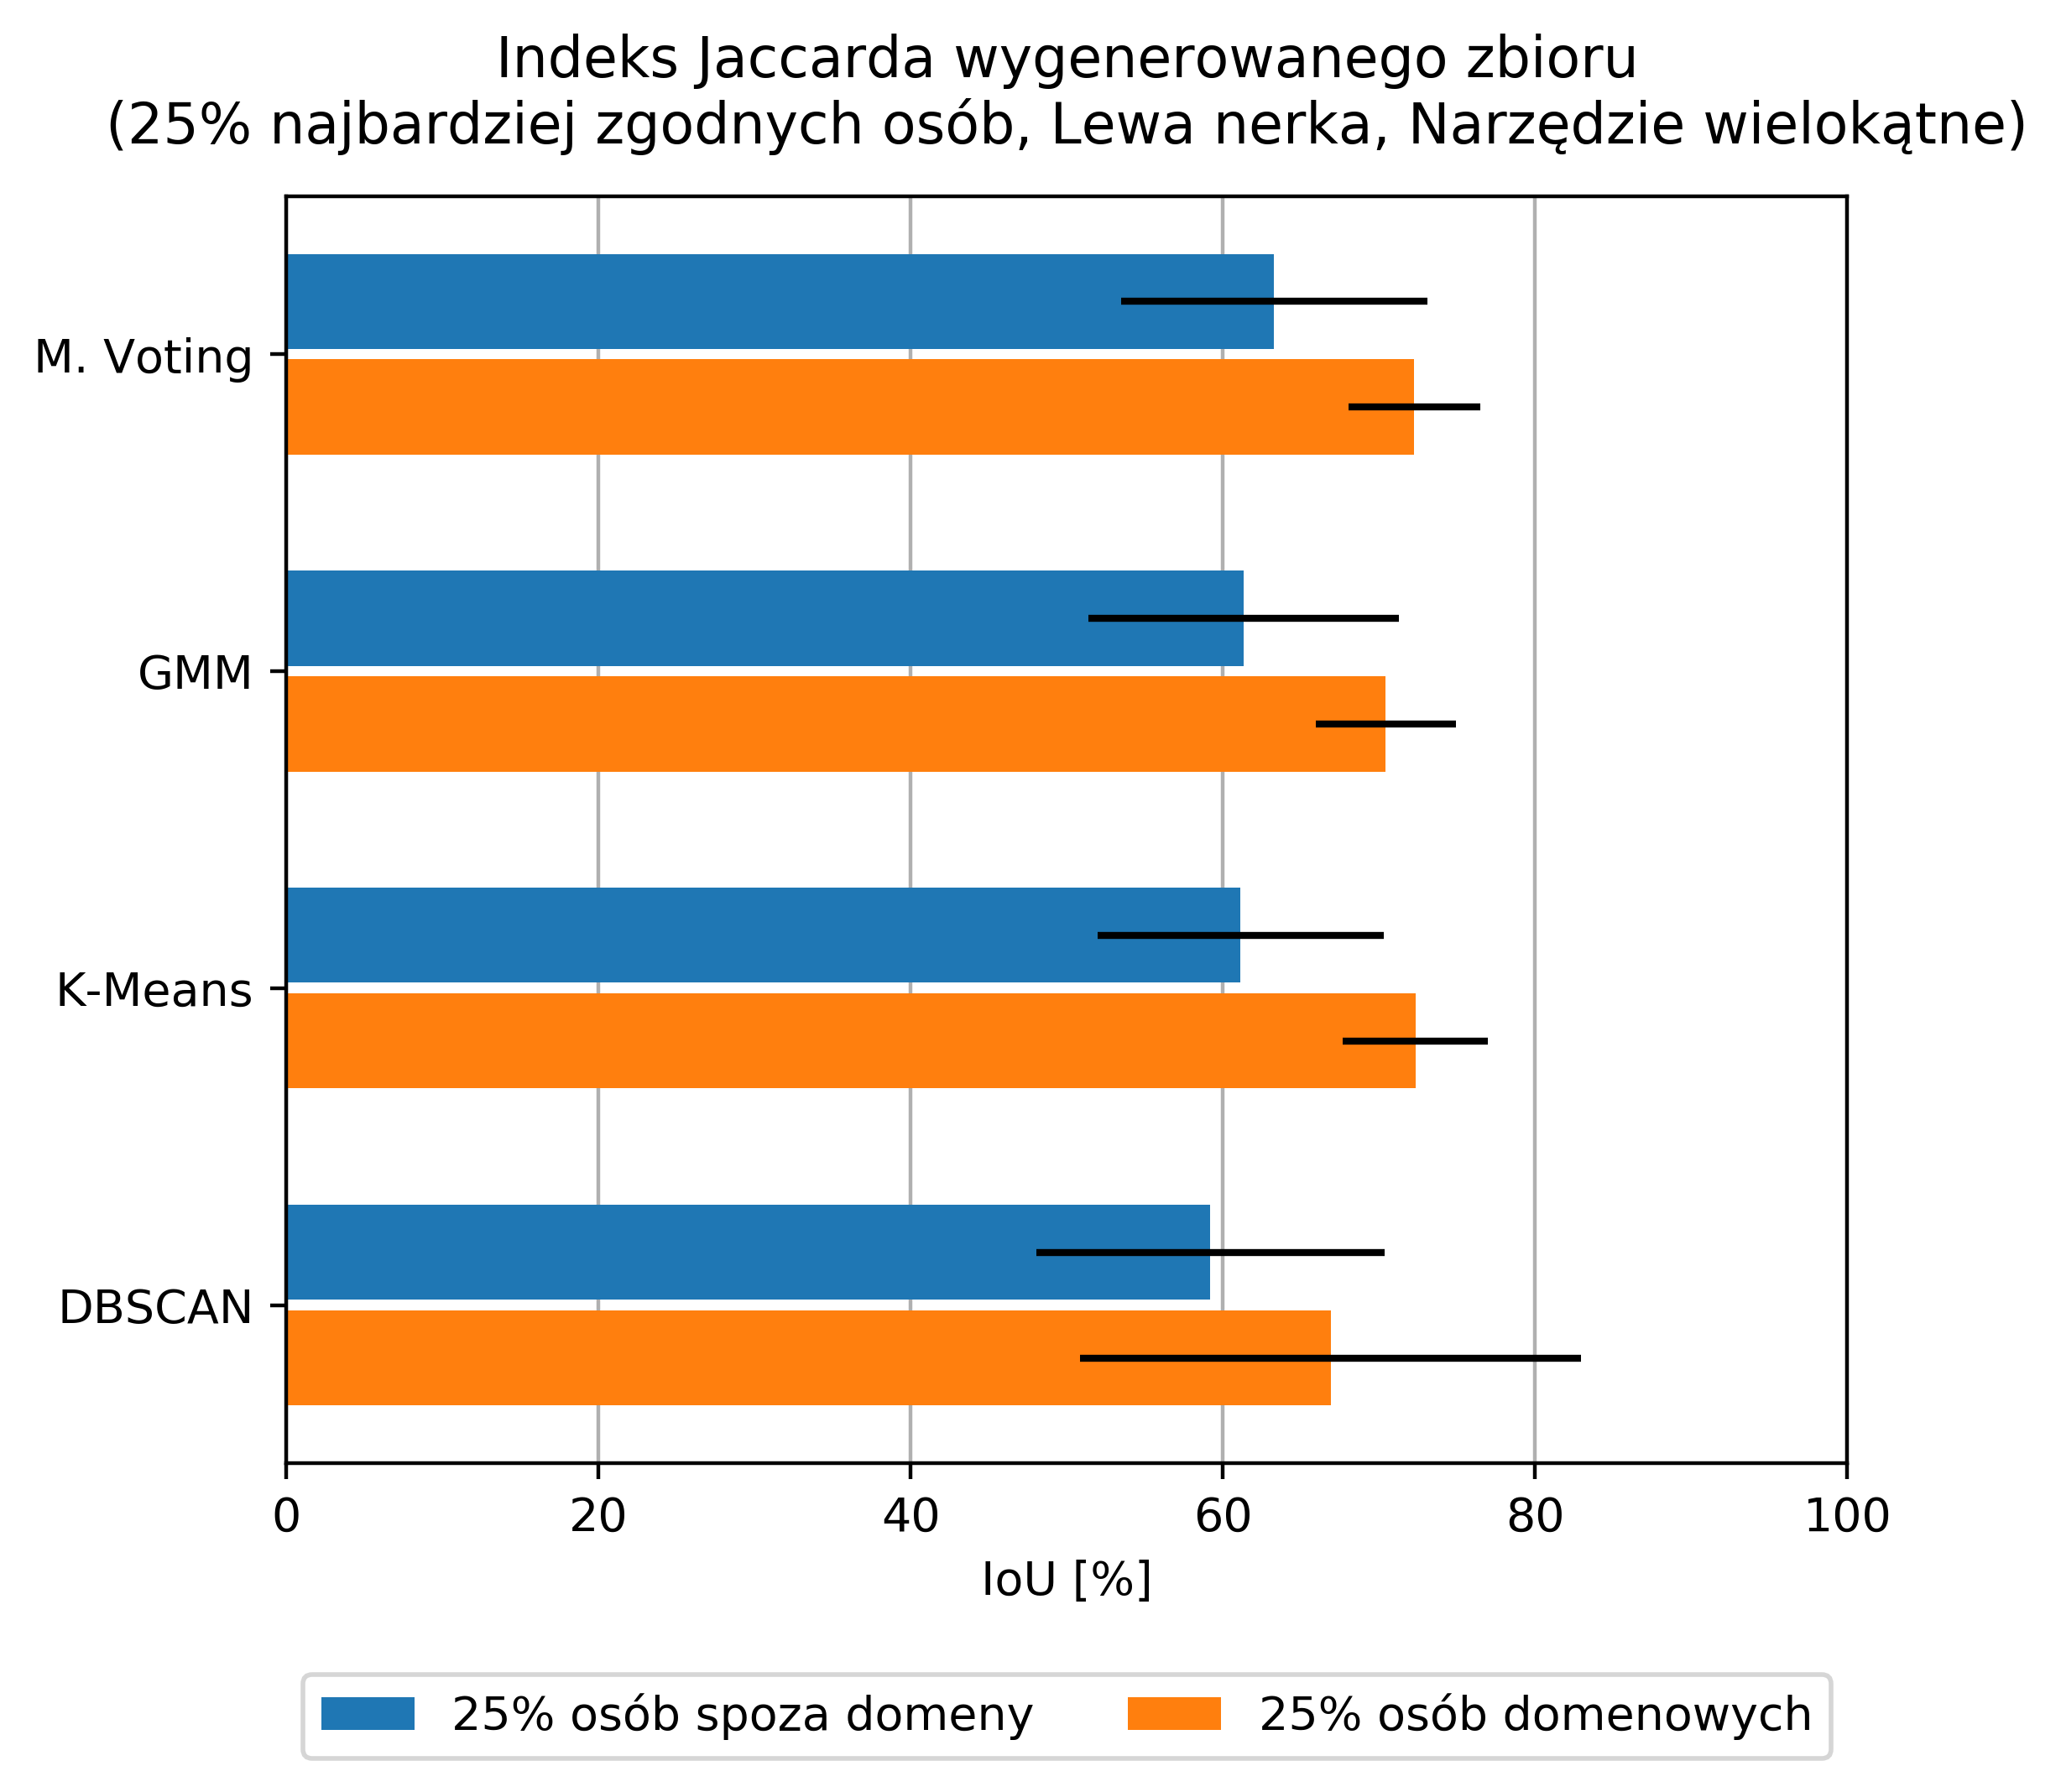

In [52]:
legend = ['25% osób spoza domeny', '25% osób domenowych']
plot_jaccard_index(Y, E, groups=2, legend=legend,
                   title='Indeks Jaccarda wygenerowanego zbioru\n(25% najbardziej zgodnych osób, Lewa nerka, Narzędzie wielokątne)')

In [53]:
all_people = [
    (81.987, 8.554, 87.839, 4.579),  # Majority Voting
    (79.273, 10.951, 86.810, 3.412),  # GMM
    (80.873, 8.270, 87.525, 4.314),  # KMeans
    (79.044, 9.627, 84.753, 11.736),  # DBSCAN
]

In [54]:
Y = np.array(list(chain(*[[all_people[i][0], all_people[i][2]]
                          for i in range(4)])))
E = np.array(list(chain(*[[all_people[i][1], all_people[i][3]]
                          for i in range(4)])))

/Users/jakubpowierza/Projects/MedTagger/backend/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


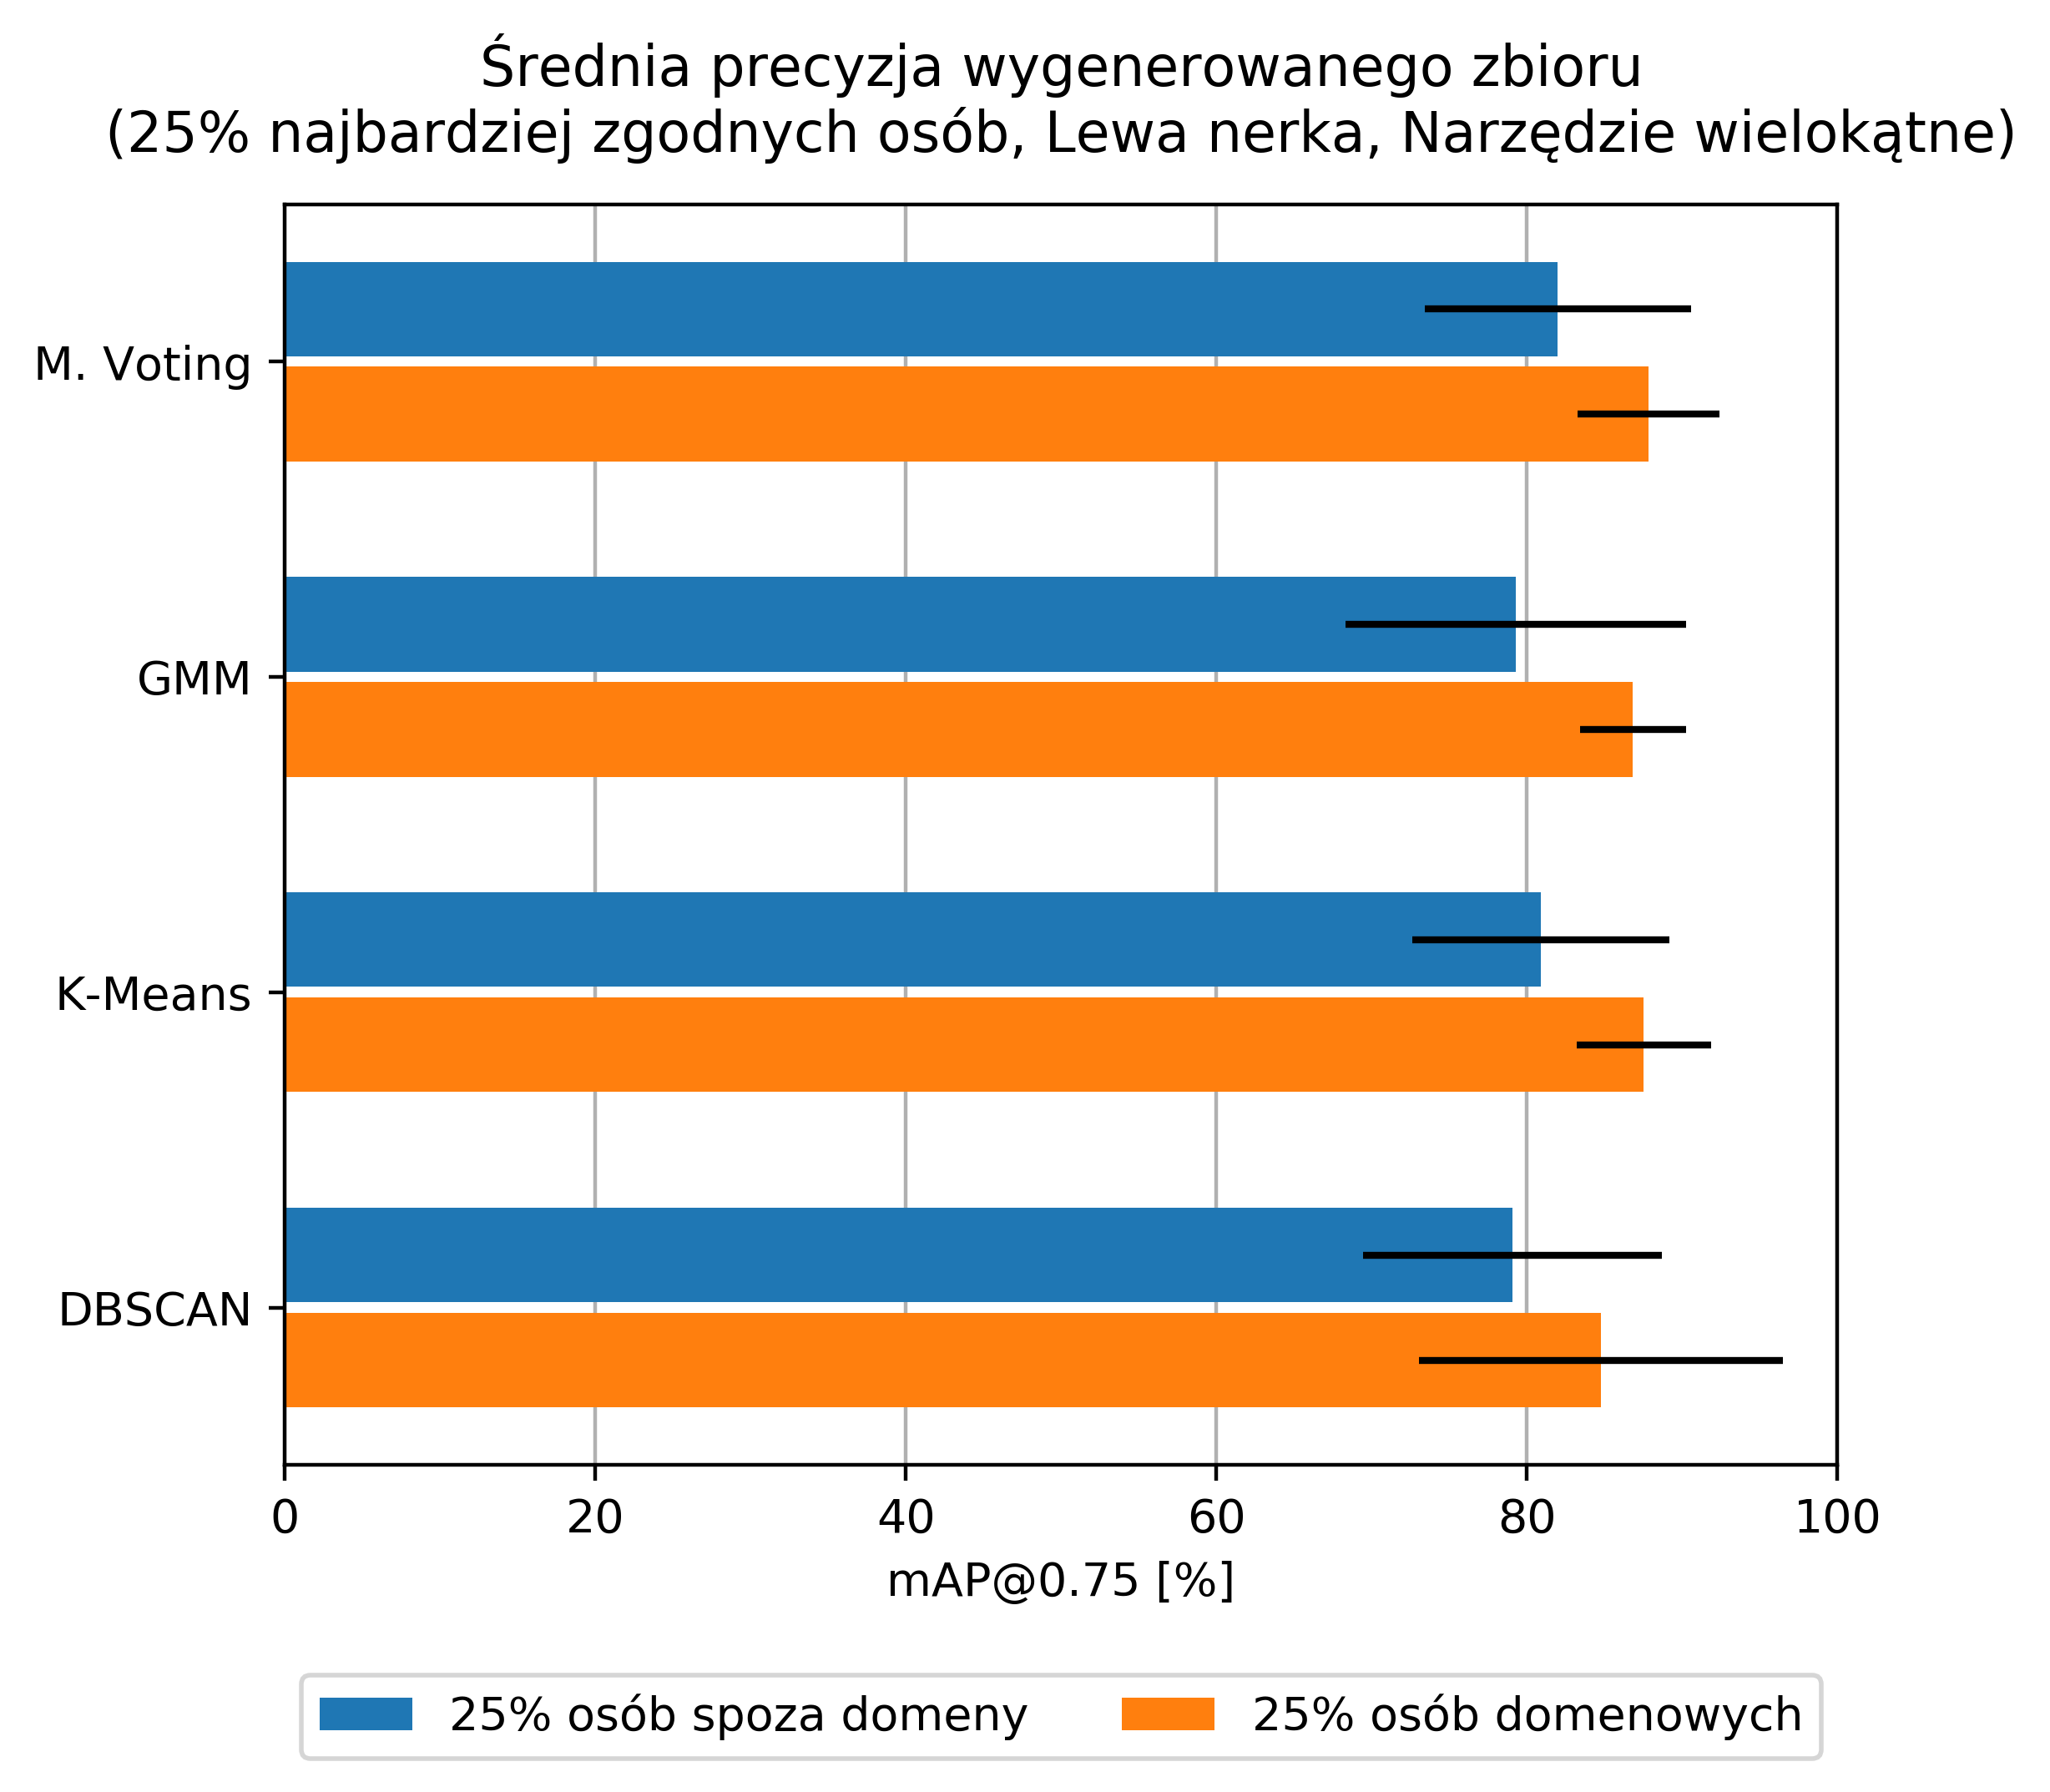

In [55]:
legend = ['25% osób spoza domeny', '25% osób domenowych']
plot_mean_average_precision(Y, E, groups=2, legend=legend,
                            title='Średnia precyzja wygenerowanego zbioru\n(25% najbardziej zgodnych osób, Lewa nerka, Narzędzie wielokątne)')

# 5.1.4. Analiza jakości wprowadzonych etykiet

In [56]:
from medtagger.database import models
from medtagger.ground_truth.algorithms.majority_voting import MajorityVotingAlgorithm
from medtagger.ground_truth.algorithms.gaussian_mixture_models import GaussianMixtureModelsAlgorithm
from medtagger.ground_truth.algorithms.k_means import KMeansAlgorithm
from medtagger.ground_truth.algorithms.dbscan import DBSCANAlgorithm
from medtagger.ground_truth.parsers.rectangle import RectangleLabelElementParser
from medtagger.ground_truth.generator import DataSetGenerator
from medtagger.ground_truth.quality import figures
from medtagger.ground_truth.quality.user_specificity_sensitivity import \
    compute_specificity_and_sensitivity_for_users

In [57]:
SCAN_IDS = [
    '03647f36-d874-480b-aaec-c2c3b9d80092',
    '40761156-99db-4647-9b72-8e449e6cb54c',
    'b750320e-5664-4eff-b4c7-49e4f43ce6ca',
    '8b5d264d-bc2f-458f-ba68-2a987d55deae',
    '7985ea16-d5a4-4bda-92db-43a3cc074216'
]
scans = models.Scan.query.all()
scans_ids = {scan.id for scan in scans}

In [58]:
algorithm = MajorityVotingAlgorithm()
# algorithm = GaussianMixtureModelsAlgorithm()
# algorithm = KMeansAlgorithm()
# algorithm = DBSCANAlgorithm()
generator = DataSetGenerator(algorithm)

## Prostokąty

In [59]:
mv_algorithm = MajorityVotingAlgorithm()
mv_generator = DataSetGenerator(algorithm)
query = models.RectangularLabelElement.query.join(models.Label).join(models.User)
query = query.filter(models.Label.scan_id.in_(scans_ids))
expert_rectangular_label_elements = query.filter(models.User.last_name == 'EXPERT').all()
ground_truth_expert = mv_generator.generate(expert_rectangular_label_elements)

In [60]:
query = models.RectangularLabelElement.query.join(models.Label).join(models.User)
query = query.filter(models.Label.scan_id.in_(scans_ids))
rectangular_label_elements = query.filter(models.User.last_name.in_(['ETI', 'GUMED'])).all()

In [61]:
rectangular_label_elements = [s for s in rectangular_label_elements if s.slice_index < len(s.label.scan.slices)]
ground_truth_rectangles = generator.generate(rectangular_label_elements)

In [62]:
users = set(element.label.owner for element in rectangular_label_elements)
users_specificity, users_sensitivity, users_scores = \
    compute_specificity_and_sensitivity_for_users(algorithm, users,
                                                  rectangular_label_elements,
                                                  ground_truth_rectangles)

In [63]:
gumed_user_ids = [user.id for user in users if user.last_name == 'GUMED']
eti_user_ids = [user.id for user in users if user.last_name == 'ETI']
gumed_specificity = [users_specificity[u_id] for u_id in gumed_user_ids]
gumed_sensitivity = [users_sensitivity[u_id] for u_id in gumed_user_ids]
eti_specificity = [users_specificity[u_id] for u_id in eti_user_ids]
eti_sensitivity = [users_sensitivity[u_id] for u_id in eti_user_ids]

/Users/jakubpowierza/Projects/MedTagger/backend/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


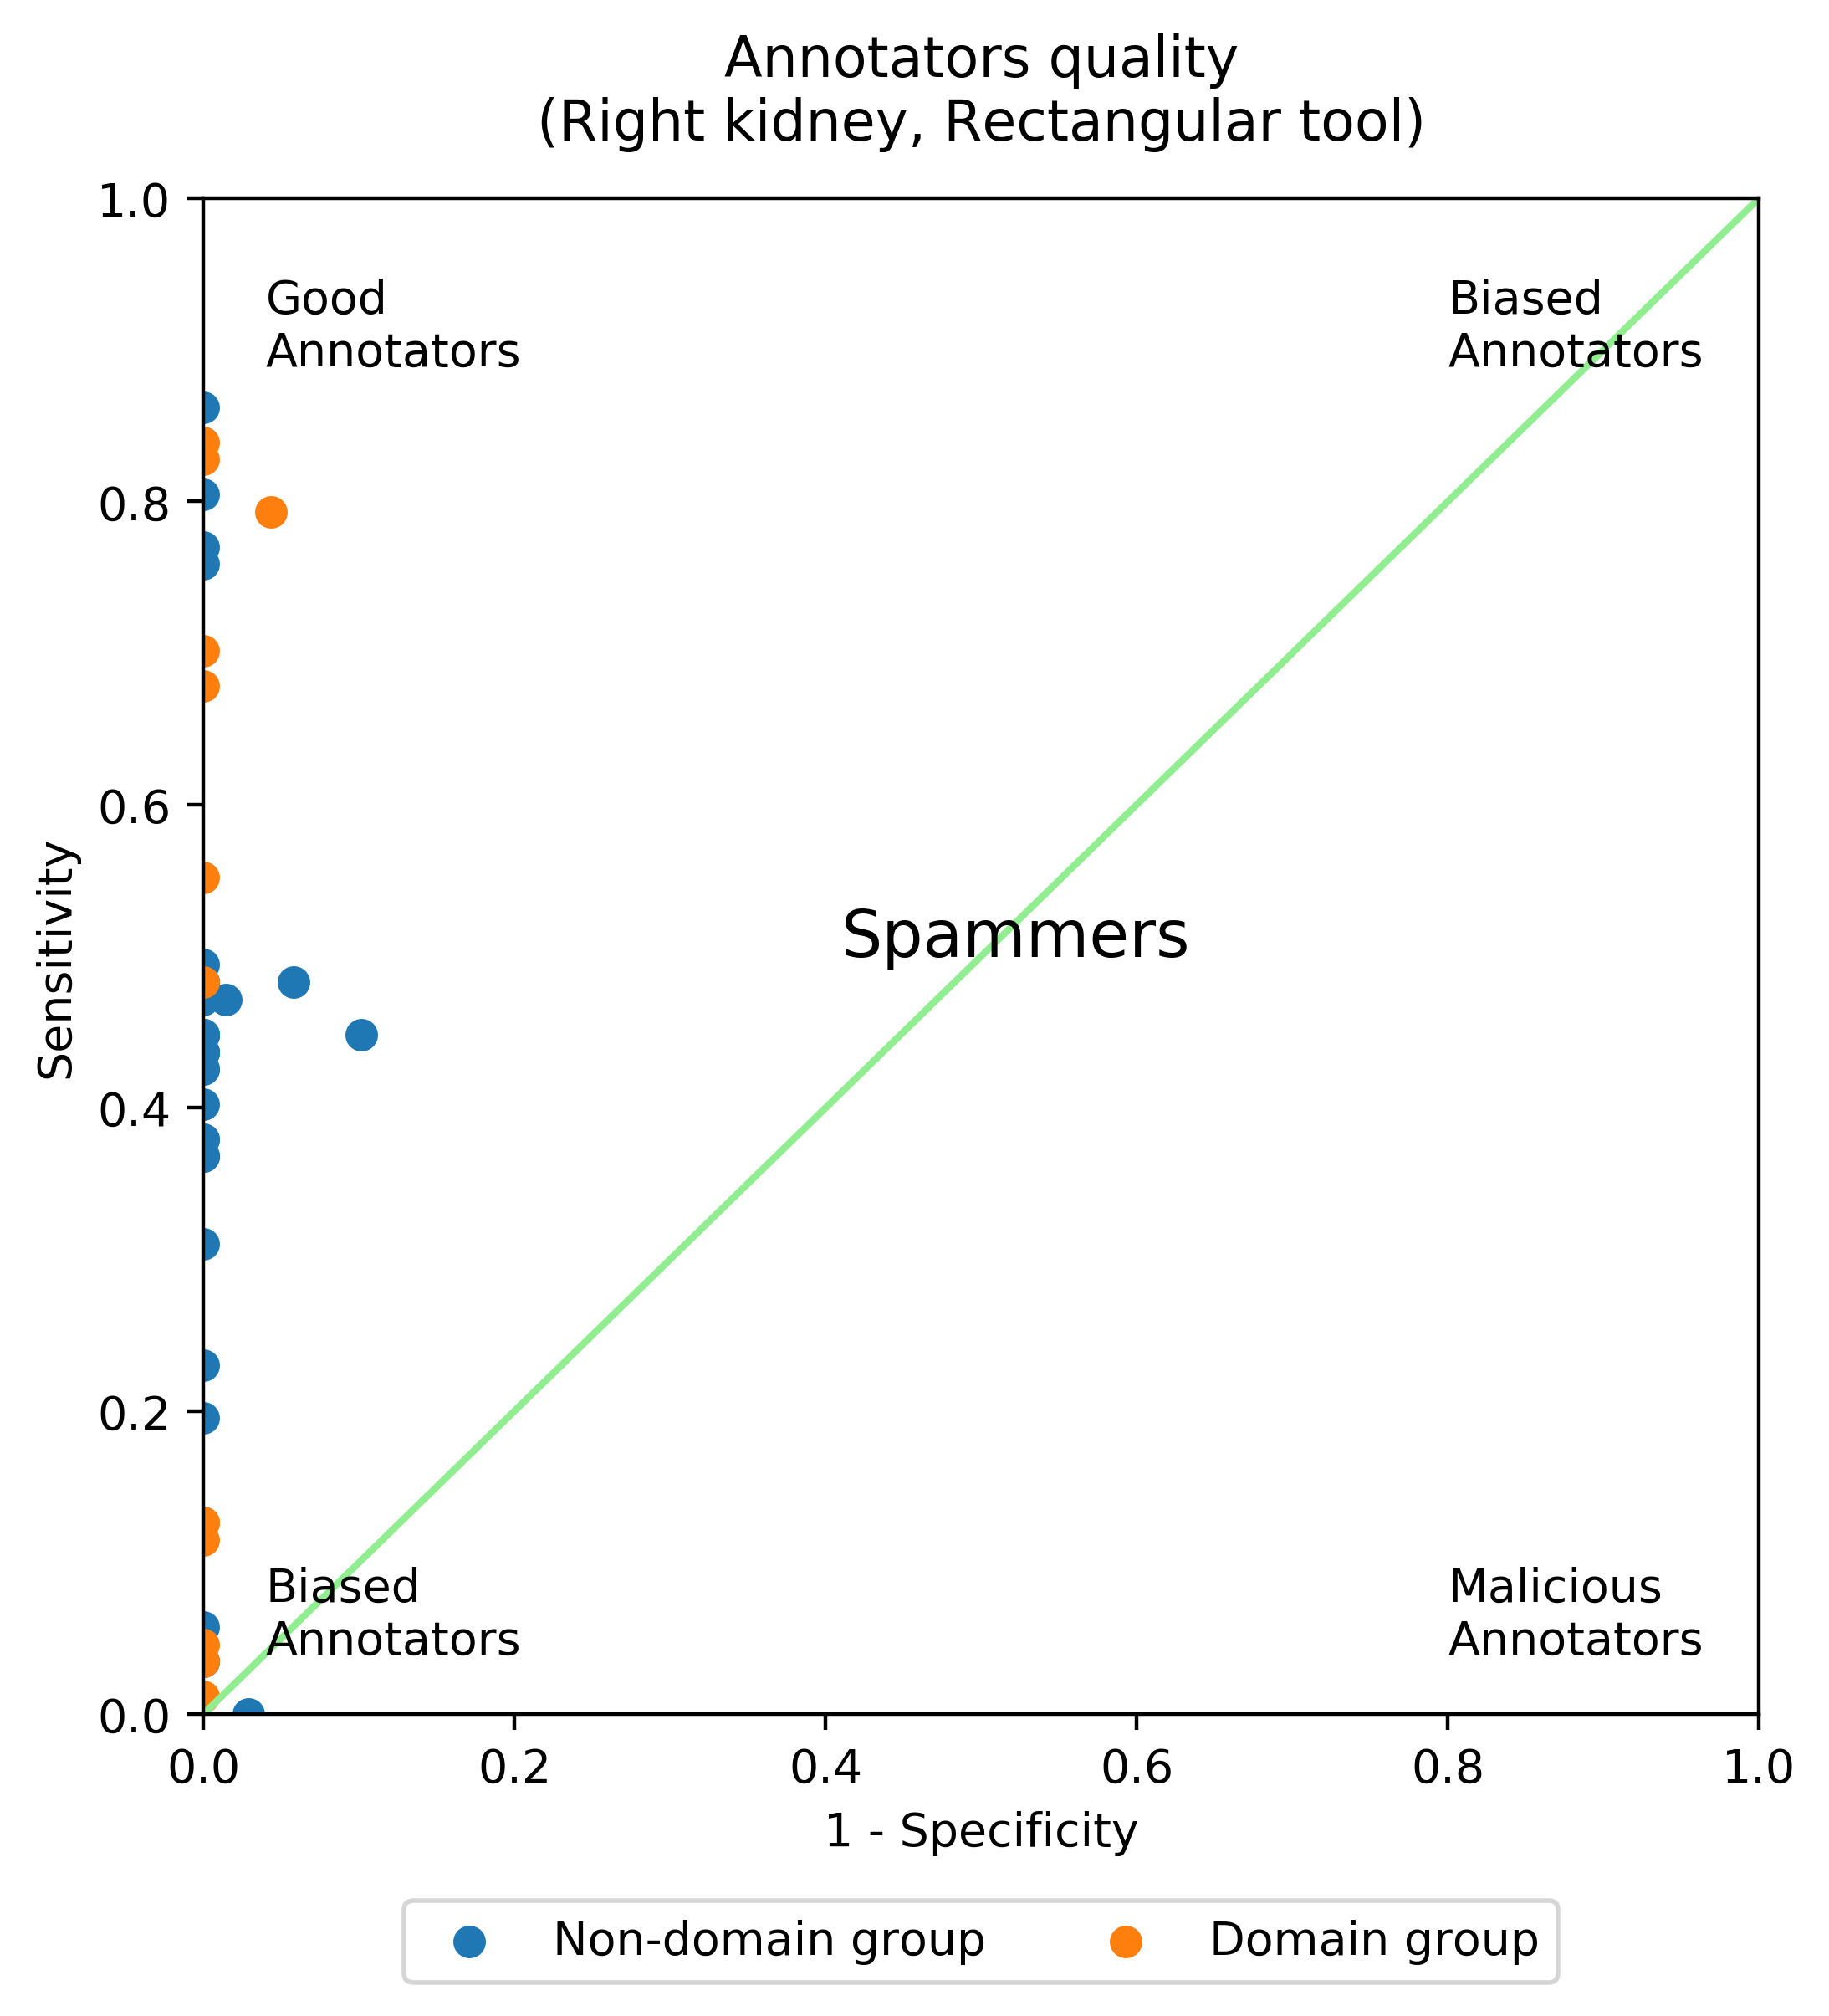

In [64]:
title = 'Annotators quality\n(Right kidney, Rectangular tool)'
legend = ['Non-domain group', 'Domain group']
plot_sensitivity_specificity(eti_specificity, gumed_specificity, title, legend,
                   save='/Users/jakubpowierza/Downloads/poster_images/5.png')

## Wielokąty

In [65]:
mv_algorithm = MajorityVotingAlgorithm()
mv_generator = DataSetGenerator(algorithm)
query = models.ChainLabelElement.query.join(models.Label).join(models.User)
query = query.filter(models.Label.scan_id.in_(scans_ids))
expert_chain_label_elements = query.filter(models.User.last_name == 'EXPERT').all()
ground_truth_expert = mv_generator.generate(expert_chain_label_elements)

In [66]:
query = models.ChainLabelElement.query.join(models.Label).join(models.User)
query = query.filter(models.Label.scan_id.in_(scans_ids))
chain_label_elements = query.filter(models.User.last_name.in_(['ETI', 'GUMED'])).all()

In [67]:
chain_label_elements = [s for s in chain_label_elements if s.slice_index < len(s.label.scan.slices)]
ground_truth_chain = generator.generate(chain_label_elements)

In [68]:
users = set(element.label.owner for element in chain_label_elements)
users_specificity, users_sensitivity, users_scores = \
    compute_specificity_and_sensitivity_for_users(algorithm, users,
                                                  chain_label_elements,
                                                  ground_truth_chain)

In [69]:
gumed_user_ids = [user.id for user in users if user.last_name == 'GUMED']
eti_user_ids = [user.id for user in users if user.last_name == 'ETI']
gumed_specificity = [users_specificity[u_id] for u_id in gumed_user_ids]
gumed_sensitivity = [users_sensitivity[u_id] for u_id in gumed_user_ids]
eti_specificity = [users_specificity[u_id] for u_id in eti_user_ids]
eti_sensitivity = [users_sensitivity[u_id] for u_id in eti_user_ids]

/Users/jakubpowierza/Projects/MedTagger/backend/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


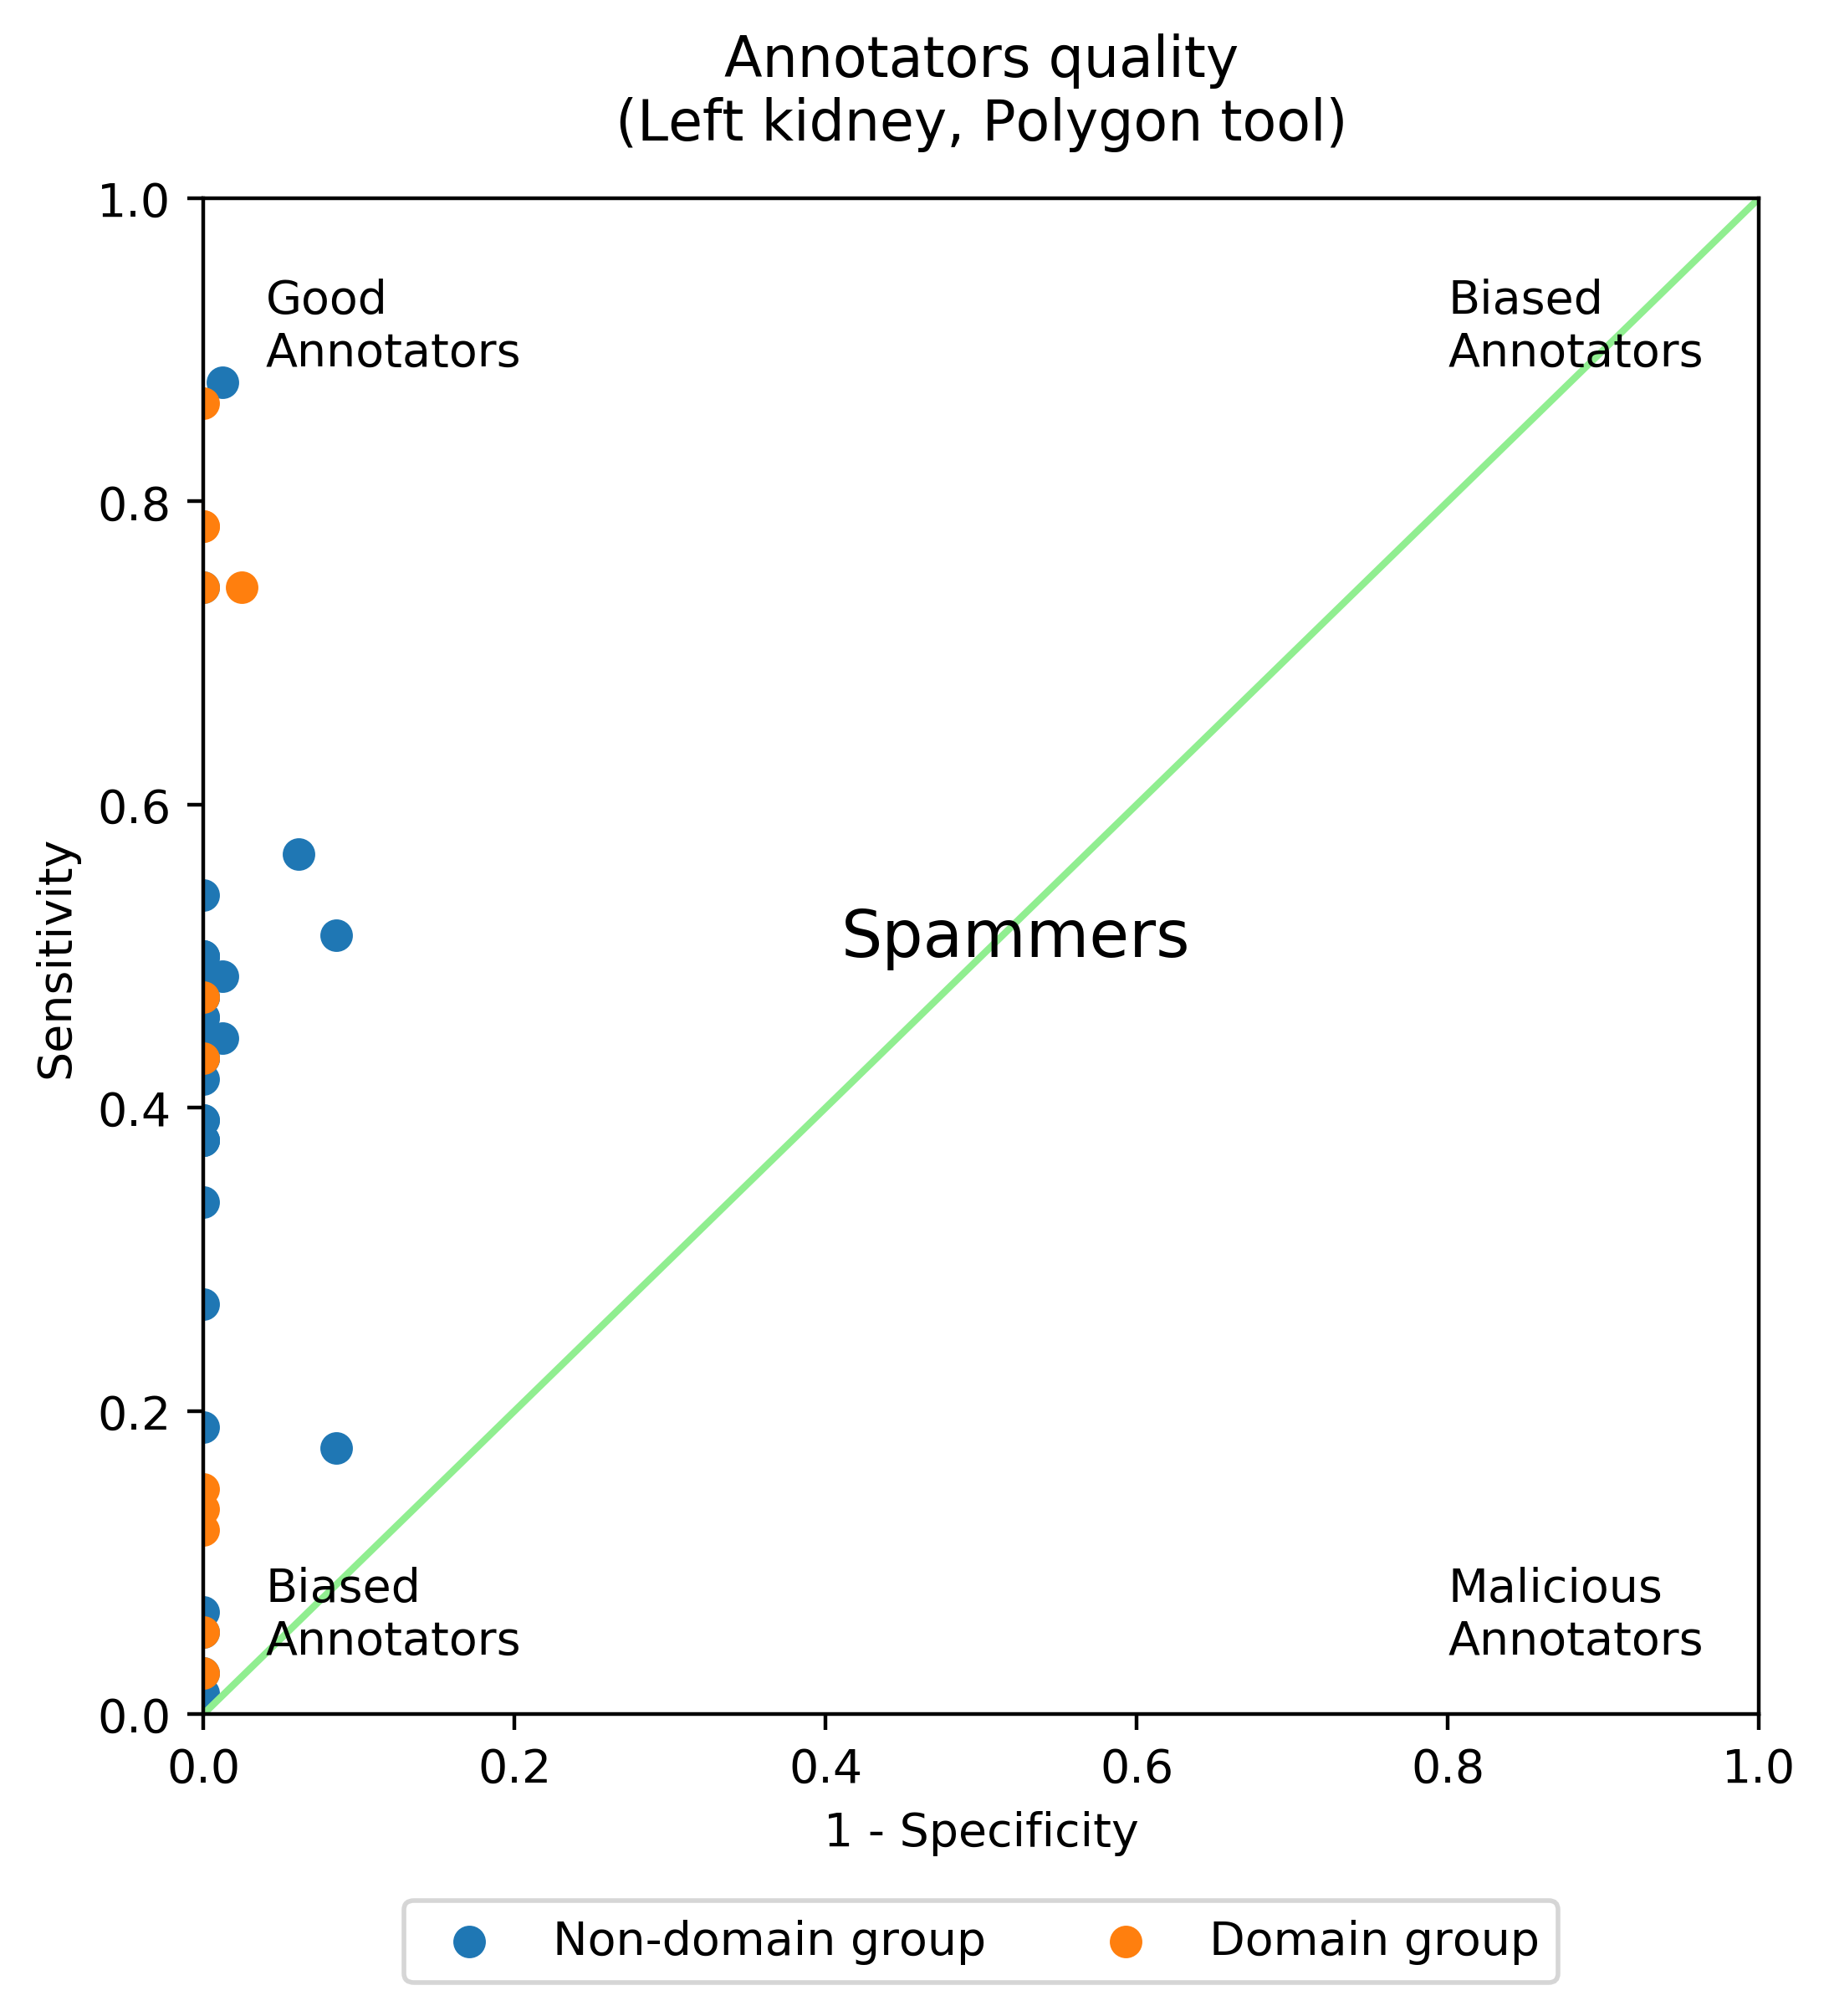

In [70]:
title = 'Annotators quality\n(Left kidney, Polygon tool)'
legend = ['Non-domain group', 'Domain group']
plot_sensitivity_specificity(eti_specificity, gumed_specificity, title, legend,
                   save='/Users/jakubpowierza/Downloads/poster_images/6.png')

# 5.1.5. Analiza wpływu czasu pracy na jakość

In [71]:
from medtagger.database import models
from medtagger.ground_truth.algorithms.majority_voting import MajorityVotingAlgorithm
from medtagger.ground_truth.algorithms.gaussian_mixture_models import GaussianMixtureModelsAlgorithm
from medtagger.ground_truth.algorithms.k_means import KMeansAlgorithm
from medtagger.ground_truth.algorithms.dbscan import DBSCANAlgorithm
from medtagger.ground_truth.parsers.rectangle import RectangleLabelElementParser
from medtagger.ground_truth.generator import DataSetGenerator
from medtagger.ground_truth.quality import figures
from medtagger.ground_truth.quality.user_specificity_sensitivity import \
    compute_specificity_and_sensitivity_for_users

In [72]:
SCAN_IDS = [
    '03647f36-d874-480b-aaec-c2c3b9d80092',
    '40761156-99db-4647-9b72-8e449e6cb54c',
    'b750320e-5664-4eff-b4c7-49e4f43ce6ca',
    '8b5d264d-bc2f-458f-ba68-2a987d55deae',
    '7985ea16-d5a4-4bda-92db-43a3cc074216'
]
scans = models.Scan.query.all()
scans_ids = {scan.id for scan in scans}

In [73]:
algorithm = MajorityVotingAlgorithm()
# algorithm = GaussianMixtureModelsAlgorithm()
# algorithm = KMeansAlgorithm()
# algorithm = DBSCANAlgorithm()
generator = DataSetGenerator(algorithm)

## Prostokąty

In [74]:
mv_algorithm = MajorityVotingAlgorithm()
mv_generator = DataSetGenerator(mv_algorithm)
query = models.RectangularLabelElement.query.join(models.Label).join(models.User)
query = query.filter(models.Label.scan_id.in_(scans_ids))
expert_rectangular_label_elements = query.filter(models.User.last_name == 'EXPERT').all()
ground_truth_expert = mv_generator.generate(expert_rectangular_label_elements)

In [75]:
query = models.RectangularLabelElement.query.join(models.Label).join(models.User)
query = query.filter(models.Label.scan_id.in_(scans_ids))
rectangular_label_elements = query.filter(models.User.last_name.in_(['ETI', 'GUMED'])).all()

In [76]:
rectangular_label_elements = [s for s in rectangular_label_elements if s.slice_index < len(s.label.scan.slices)]
ground_truth_rectangles = generator.generate(rectangular_label_elements)

In [77]:
users = set(element.label.owner for element in rectangular_label_elements)
users_specificity, users_sensitivity, users_scores = \
    compute_specificity_and_sensitivity_for_users(algorithm, users,
                                                  rectangular_label_elements,
                                                  ground_truth_rectangles)

In [78]:
# Dla Dawida
gumed_user_ids_and_emails = [(user.id, user.email) for user in users if user.last_name == 'GUMED']
eti_user_ids_and_emails = [(user.id, user.email) for user in users if user.last_name == 'ETI']

In [79]:
# Dla Dawida
scans_ids = {label_element.label.scan_id for label_element in rectangular_label_elements}
query = models.Label.query.with_entities(models.Label.owner_id, func.avg(models.Label.labeling_time))
query = query.filter(models.Label.scan_id.in_(scans_ids))
query = query.group_by(models.Label.owner_id)
labeling_time_for_user_id = dict(query.all())

In [80]:
# Dla Dawida
for u_id, u_email in eti_user_ids_and_emails + gumed_user_ids_and_emails:
    n_labels = len([elem for elem in rectangular_label_elements if elem.label.owner_id == u_id])
    n_empty = sum([int(label.comment == 'This is an empty Label') for label in models.Label.query.all()
                   if label.owner_id == u_id])
    print(u_email, '\t', n_labels, '\t', n_empty, '\t', labeling_time_for_user_id[u_id], '\t', users_scores[u_id])

059@ETI 	 32 	 2 	 176.1518 	 0.1352886775003303
096@ETI 	 33 	 1 	 229.648 	 0.14387633769322242
100@ETI 	 17 	 3 	 114.6346 	 0.03818205839608935
034@ETI 	 33 	 1 	 133.5984 	 0.14387633769322242
002@ETI 	 39 	 1 	 184.564 	 0.2009512485136742
042@ETI 	 34 	 1 	 160.2244 	 0.1352886775003303
090@ETI 	 71 	 0 	 173.7076 	 0.6473774606949401
004@ETI 	 41 	 1 	 220.335 	 0.22209010437310078
066@ETI 	 71 	 0 	 206.6088 	 0.5930770247060375
051@ETI 	 38 	 1 	 129.4738 	 0.19077817413132525
024@ETI 	 43 	 1 	 204.7024 	 0.24428590302549869
058@ETI 	 37 	 1 	 236.8278 	 0.18086933544721895
095@ETI 	 38 	 1 	 166.3862 	 0.19077817413132525
054@ETI 	 67 	 0 	 213.3754 	 0.5755053507728893
041@ETI 	 38 	 1 	 135.2302 	 0.19077817413132525
036@ETI 	 39 	 1 	 270.8534 	 0.2009512485136742
091@ETI 	 5 	 0 	 98.335 	 0.0033029462280354123
097@ETI 	 36 	 1 	 147.8658 	 0.16184436517373502
047@ETI 	 48 	 2 	 169.6814 	 0.12028868124658311
053@ETI 	 39 	 1 	 192.8692 	 0.2009512485136742
033@ETI 	 37

In [81]:
gumed_user_ids = [user.id for user in users if user.last_name == 'GUMED']
eti_user_ids = [user.id for user in users if user.last_name == 'ETI']
gumed_score = {u_id: users_scores[u_id] for u_id in gumed_user_ids}
eti_score = {u_id: users_scores[u_id] for u_id in eti_user_ids}

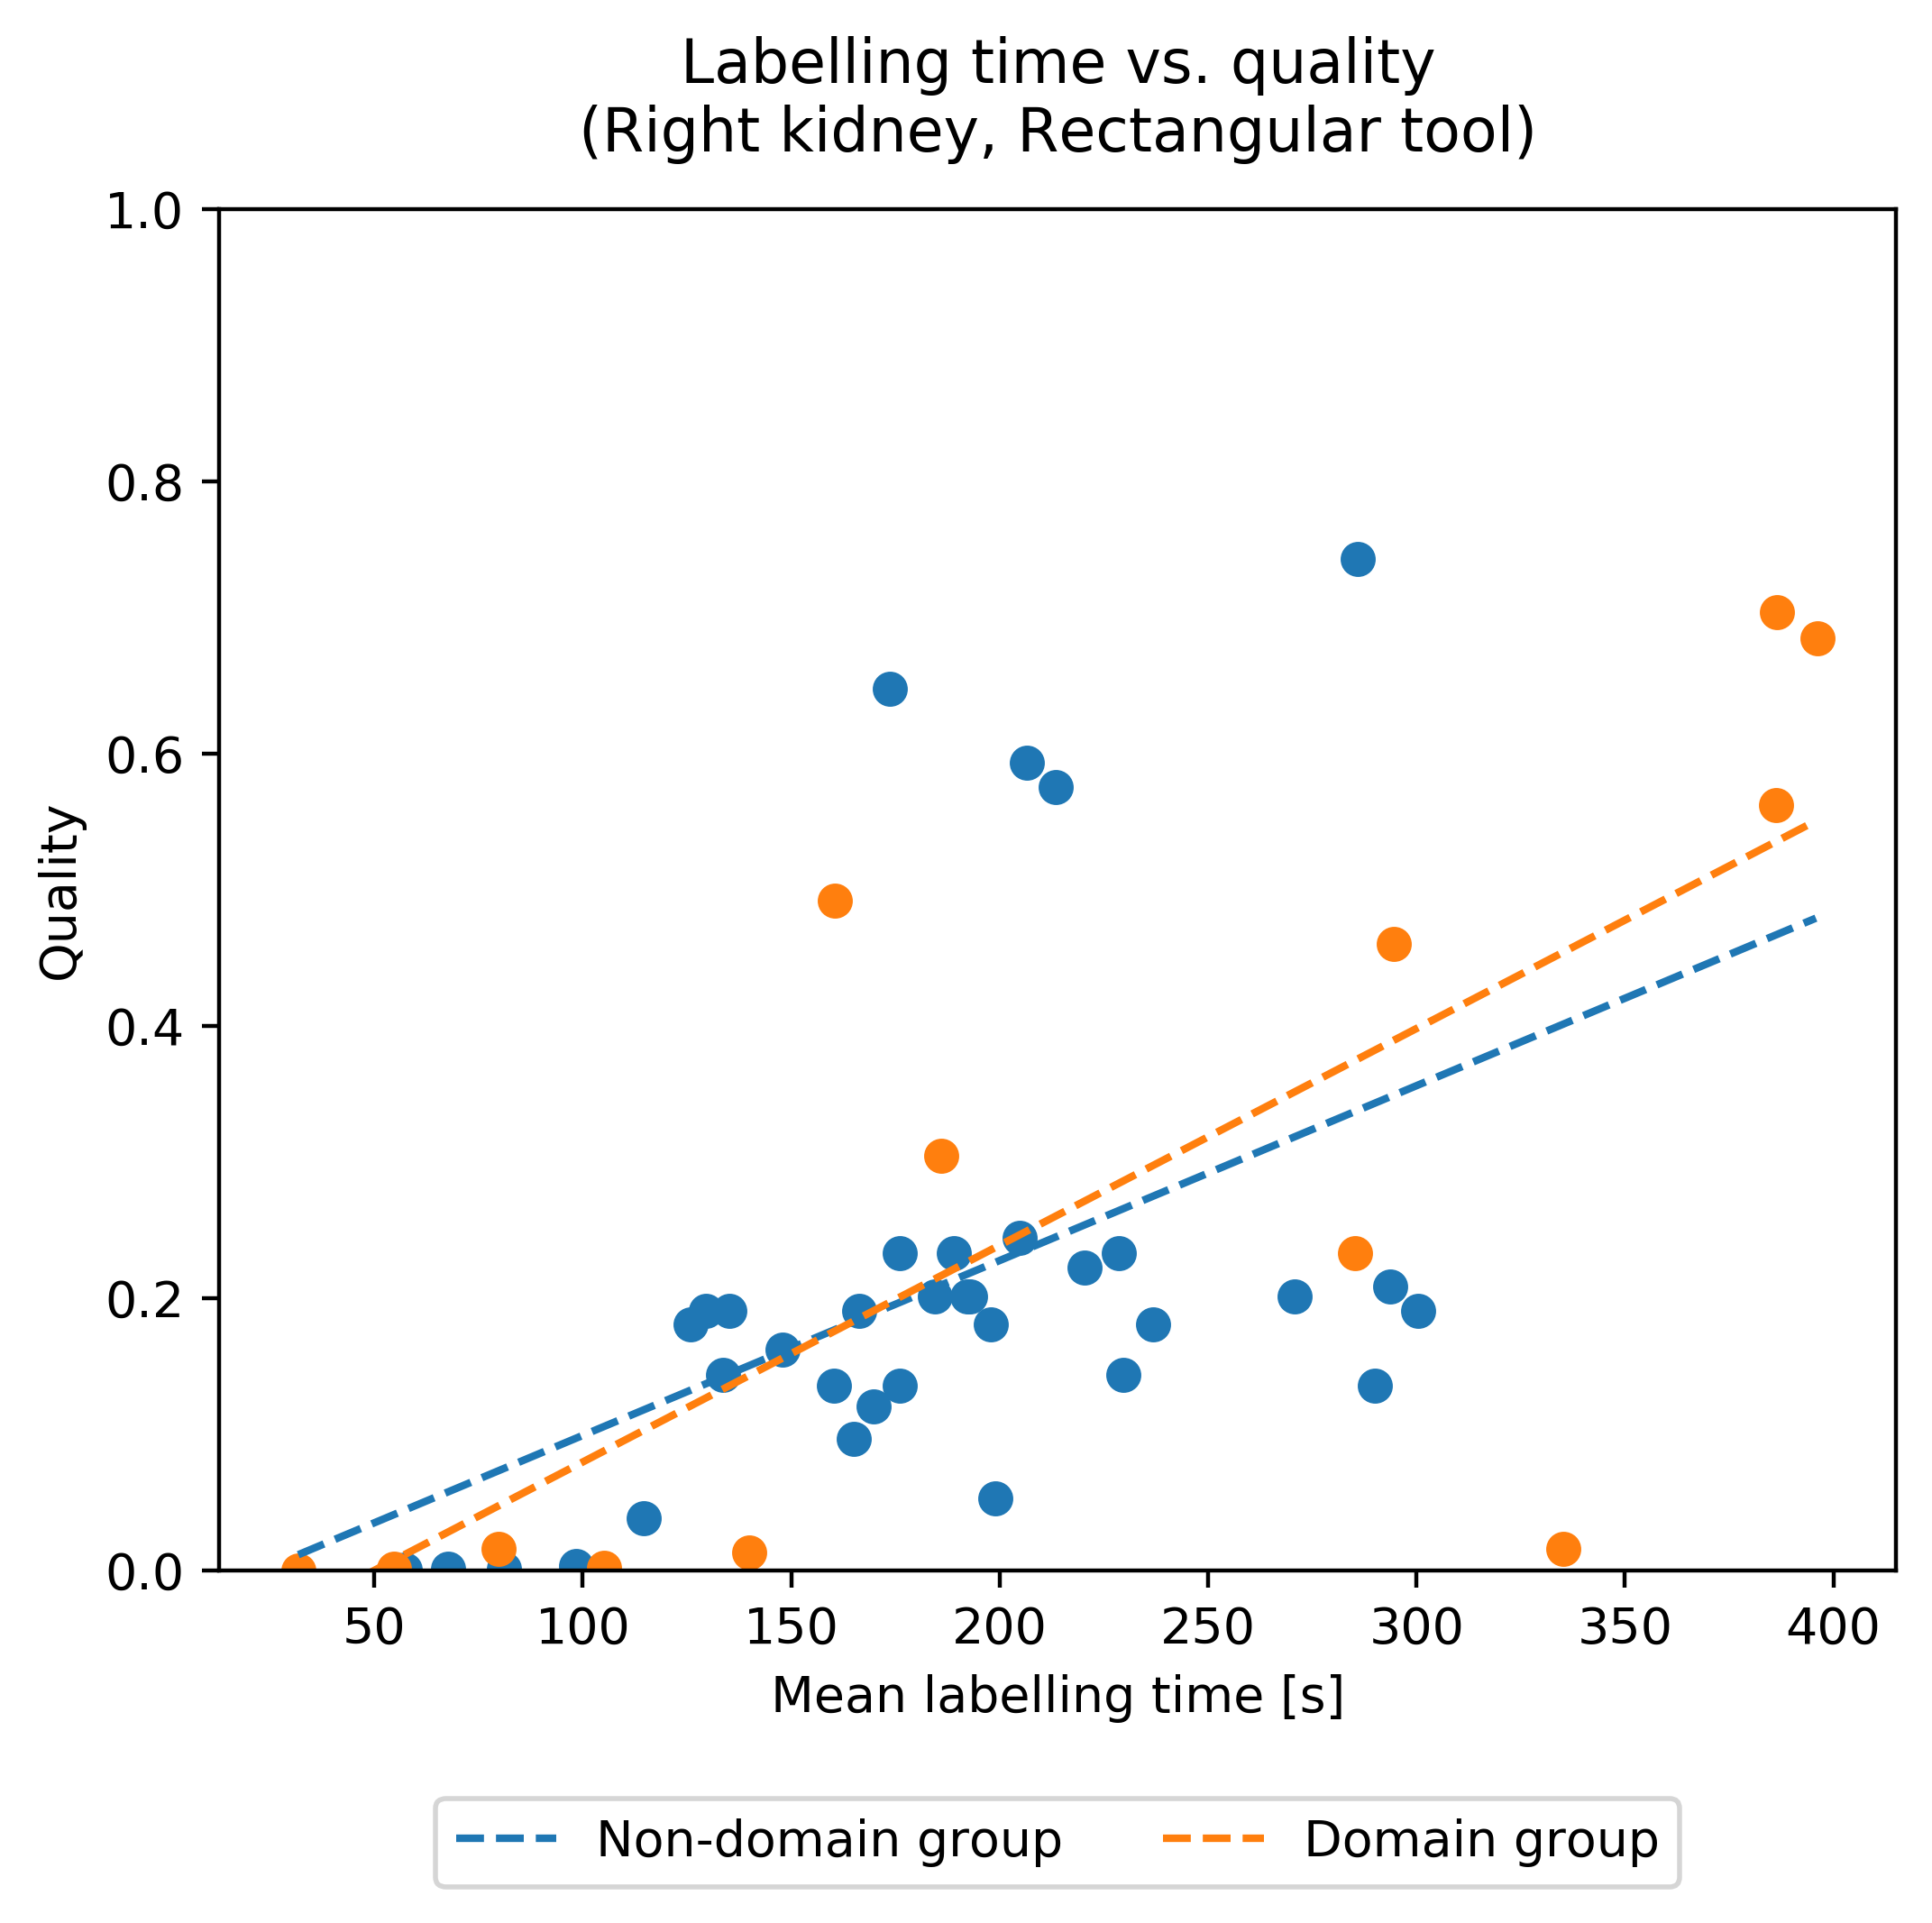

In [82]:
title = 'Labelling time vs. quality\n(Right kidney, Rectangular tool)'
legend = ['Non-domain group', 'Domain group']
plot_mean_labeling_time_vs_score(rectangular_label_elements, eti_score, gumed_score, title, legend,
                   save='/Users/jakubpowierza/Downloads/poster_images/7.png')

## Wielokąty

In [83]:
mv_algorithm = MajorityVotingAlgorithm()
mv_generator = DataSetGenerator(mv_algorithm)
query = models.ChainLabelElement.query.join(models.Label).join(models.User)
query = query.filter(models.Label.scan_id.in_(scans_ids))
expert_chain_label_elements = query.filter(models.User.last_name == 'EXPERT').all()
ground_truth_expert = mv_generator.generate(expert_chain_label_elements)

In [84]:
query = models.ChainLabelElement.query.join(models.Label).join(models.User)
query = query.filter(models.Label.scan_id.in_(scans_ids))
chain_label_elements = query.filter(models.User.last_name.in_(['ETI', 'GUMED'])).all()

In [85]:
chain_label_elements = [s for s in chain_label_elements if s.slice_index < len(s.label.scan.slices)]
ground_truth_chain = generator.generate(chain_label_elements)

In [86]:
users = set(element.label.owner for element in chain_label_elements)
users_specificity, users_sensitivity, users_scores = \
    compute_specificity_and_sensitivity_for_users(algorithm, users,
                                                  chain_label_elements,
                                                  ground_truth_chain)

In [87]:
# Dla Dawida
gumed_user_ids_and_emails = [(user.id, user.email) for user in users if user.last_name == 'GUMED']
eti_user_ids_and_emails = [(user.id, user.email) for user in users if user.last_name == 'ETI']

In [88]:
# Dla Dawida
scans_ids = {label_element.label.scan_id for label_element in chain_label_elements}
query = models.Label.query.with_entities(models.Label.owner_id, func.avg(models.Label.labeling_time))
query = query.filter(models.Label.scan_id.in_(scans_ids))
query = query.group_by(models.Label.owner_id)
labeling_time_for_user_id = dict(query.all())

In [89]:
# Dla Dawida
for u_id, u_email in eti_user_ids_and_emails + gumed_user_ids_and_emails:
    n_labels = len([elem for elem in chain_label_elements if elem.label.owner_id == u_id])
    n_empty = sum([int(label.comment == 'This is an empty Label') for label in models.Label.query.all()
                   if label.owner_id == u_id])
    print(u_email, '\t', n_labels, '\t', n_empty, '\t', labeling_time_for_user_id[u_id], '\t', users_scores[u_id])

059@ETI 	 31 	 2 	 176.1518 	 0.17549306062819572
096@ETI 	 28 	 1 	 229.648 	 0.14317019722425137
100@ETI 	 15 	 3 	 114.6346 	 0.03579254930606284
034@ETI 	 28 	 1 	 133.5984 	 0.14317019722425137
002@ETI 	 35 	 1 	 184.564 	 0.18699780861943027
042@ETI 	 30 	 1 	 160.2244 	 0.15357925493060628
090@ETI 	 55 	 0 	 173.7076 	 0.5524105186267347
004@ETI 	 37 	 1 	 220.335 	 0.25
066@ETI 	 39 	 0 	 206.6088 	 0.2249522984727254
051@ETI 	 28 	 1 	 129.4738 	 0.14317019722425137
024@ETI 	 33 	 1 	 204.7024 	 0.19886778670562463
058@ETI 	 33 	 1 	 236.8278 	 0.19886778670562463
095@ETI 	 35 	 1 	 166.3862 	 0.22370343316289268
054@ETI 	 40 	 0 	 213.3754 	 0.2921840759678598
041@ETI 	 34 	 1 	 135.2302 	 0.19886778670562463
036@ETI 	 33 	 1 	 270.8534 	 0.19886778670562463
091@ETI 	 5 	 0 	 98.335 	 0.004565376186997806
097@ETI 	 33 	 1 	 147.8658 	 0.18699780861943027
047@ETI 	 21 	 2 	 169.6814 	 0.008155863952767364
053@ETI 	 37 	 1 	 192.8692 	 0.25
033@ETI 	 34 	 1 	 197.8442 	 0.21110

In [90]:
gumed_user_ids = [user.id for user in users if user.last_name == 'GUMED']
eti_user_ids = [user.id for user in users if user.last_name == 'ETI']
gumed_score = {u_id: users_scores[u_id] for u_id in gumed_user_ids}
eti_score = {u_id: users_scores[u_id] for u_id in eti_user_ids}

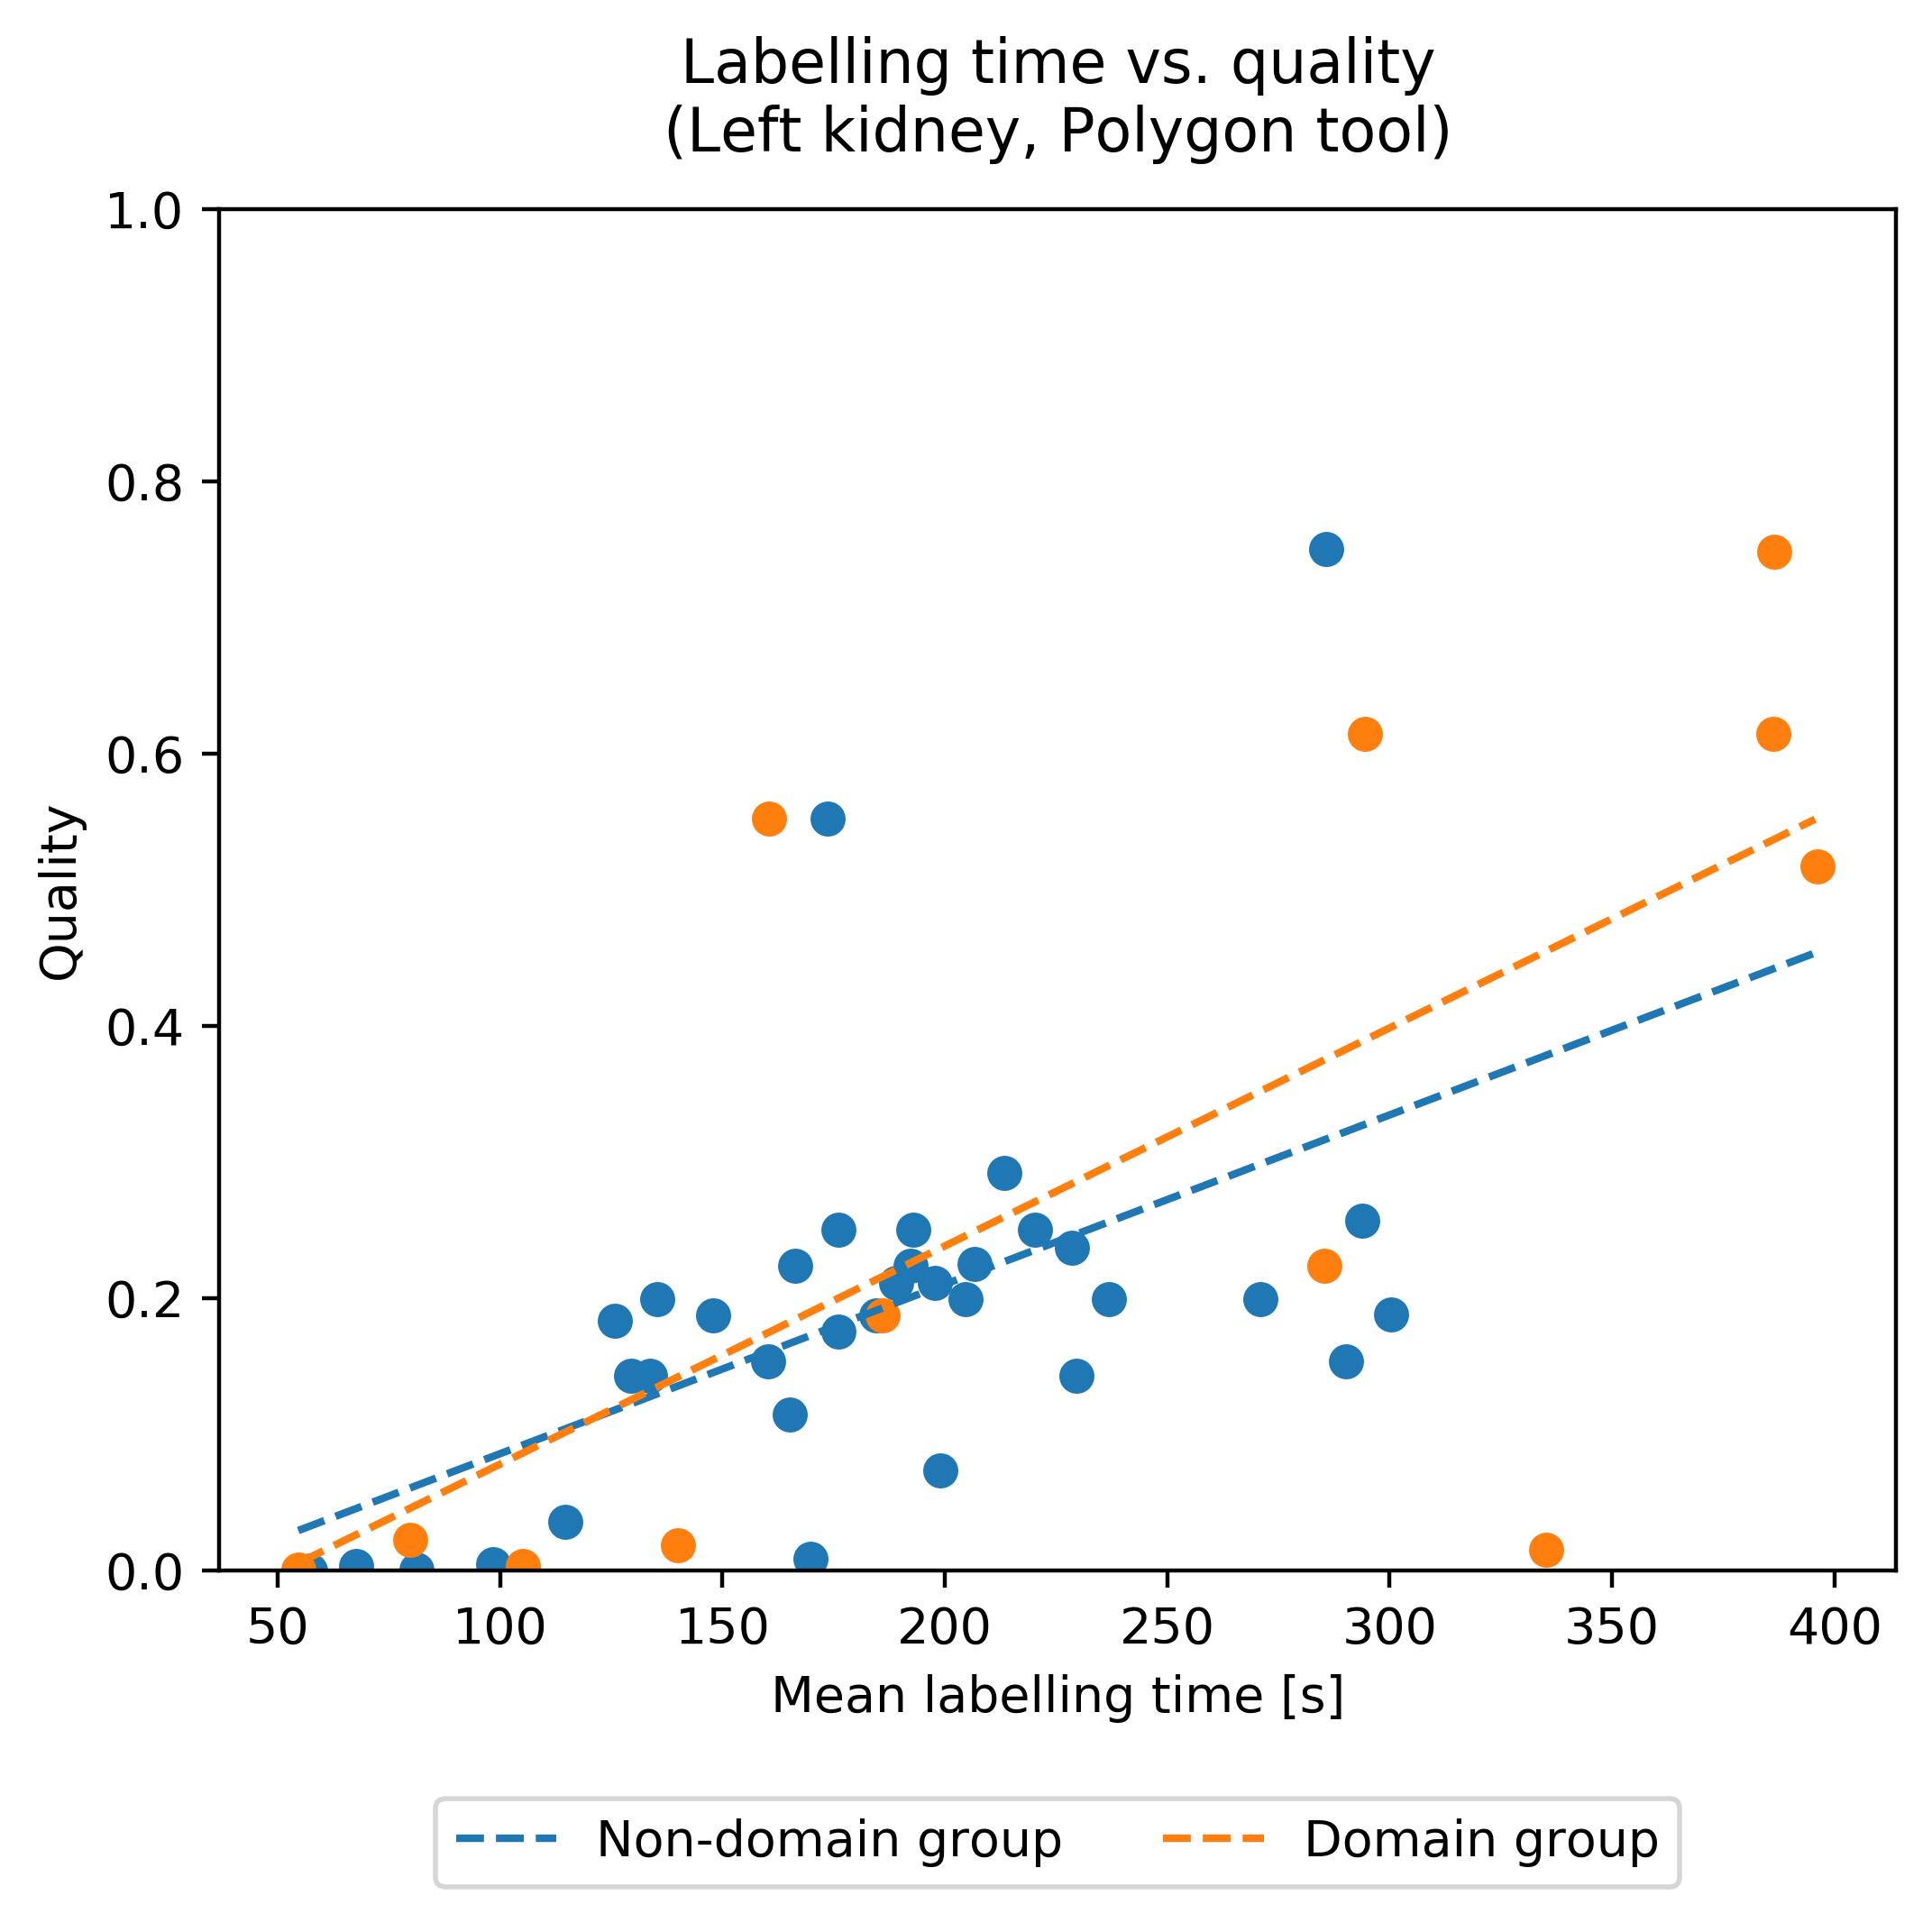

In [91]:
title = 'Labelling time vs. quality\n(Left kidney, Polygon tool)'
legend = ['Non-domain group', 'Domain group']
plot_mean_labeling_time_vs_score(chain_label_elements, eti_score, gumed_score, title, legend,
                   save='/Users/jakubpowierza/Downloads/poster_images/8.png')

## Pomijanie etykietowania

In [92]:
from io import StringIO
import pandas as pd

input_csv = StringIO('''
UserID	ScanID	IoU	Time	Skipped
003@GUMED	03647f36-d874-480b-aaec-c2c3b9d80092	0,00%	34.626	FALSE
003@GUMED	40761156-99db-4647-9b72-8e449e6cb54c	0,00%	36.085	FALSE
003@GUMED	b750320e-5664-4eff-b4c7-49e4f43ce6ca	8,26%	50.956	FALSE
003@GUMED	8b5d264d-bc2f-458f-ba68-2a987d55deae	7,81%	99.026	FALSE
003@GUMED	7985ea16-d5a4-4bda-92db-43a3cc074216	0,15%	52.447	FALSE
030@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	80,92%	217.304	FALSE
030@ETI	40761156-99db-4647-9b72-8e449e6cb54c	70,54%	619.482	FALSE
030@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	57,73%	419.76	FALSE
030@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	58,07%	127.57	FALSE
030@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	0,00%	84.813	FALSE
057@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	68,61%	166.037	FALSE
057@ETI	40761156-99db-4647-9b72-8e449e6cb54c	84,68%	510.42	FALSE
057@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	75,38%	146.688	FALSE
057@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	58,20%	163.125	FALSE
057@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	27,00%	156.931	FALSE
058@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	76,60%	350.146	FALSE
058@ETI	40761156-99db-4647-9b72-8e449e6cb54c	84,28%	118.227	FALSE
058@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	72,46%	175.686	FALSE
058@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	69,95%	485.249	FALSE
058@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	0,00%	54.831	TRUE
071@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	85,69%	384.87	FALSE
071@ETI	40761156-99db-4647-9b72-8e449e6cb54c	83,74%	201.626	FALSE
071@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	66,75%	144.661	FALSE
071@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	64,78%	143.798	FALSE
071@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	0,00%	5.298	TRUE
053@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	81,14%	569.46	FALSE
053@ETI	40761156-99db-4647-9b72-8e449e6cb54c	77,21%	126.544	FALSE
053@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	74,19%	115.048	FALSE
053@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	76,96%	150.202	FALSE
053@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	0,00%	3.092	TRUE
024@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	69,65%	112.157	FALSE
024@ETI	40761156-99db-4647-9b72-8e449e6cb54c	61,28%	82.793	FALSE
024@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	57,06%	270.904	FALSE
024@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	61,30%	472.703	FALSE
024@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	0,00%	84.955	TRUE
036@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	82,33%	538.674	FALSE
036@ETI	40761156-99db-4647-9b72-8e449e6cb54c	86,18%	181.408	FALSE
036@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	66,88%	348.775	FALSE
036@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	68,54%	189.888	FALSE
036@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	0,00%	95.522	TRUE
005@GUMED	03647f36-d874-480b-aaec-c2c3b9d80092	0,00%	0	FALSE
005@GUMED	40761156-99db-4647-9b72-8e449e6cb54c	0,00%	0	FALSE
005@GUMED	b750320e-5664-4eff-b4c7-49e4f43ce6ca	0,00%	0	FALSE
005@GUMED	8b5d264d-bc2f-458f-ba68-2a987d55deae	72,55%	633.052	FALSE
005@GUMED	7985ea16-d5a4-4bda-92db-43a3cc074216	0,00%	37.238	TRUE
032@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	41,81%	130.165	FALSE
032@ETI	40761156-99db-4647-9b72-8e449e6cb54c	64,36%	237.961	FALSE
032@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	41,03%	412.792	FALSE
032@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	40,86%	145.927	FALSE
032@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	0,00%	68.006	TRUE
051@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	82,78%	130.704	FALSE
051@ETI	40761156-99db-4647-9b72-8e449e6cb54c	75,39%	109.409	FALSE
051@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	85,17%	73.505	FALSE
051@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	72,43%	299.904	FALSE
051@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	0,00%	33.847	TRUE
097@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	84,94%	386.947	FALSE
097@ETI	40761156-99db-4647-9b72-8e449e6cb54c	72,89%	91.224	FALSE
097@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	54,61%	90.521	FALSE
097@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	71,91%	112.828	FALSE
097@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	0,00%	57.809	TRUE
055@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	87,08%	365.318	FALSE
055@ETI	40761156-99db-4647-9b72-8e449e6cb54c	87,98%	86.574	FALSE
055@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	69,15%	106.276	FALSE
055@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	69,79%	131.034	FALSE
055@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	0,00%	256.267	TRUE
002@GUMED	03647f36-d874-480b-aaec-c2c3b9d80092	77,43%	163.655	FALSE
002@GUMED	40761156-99db-4647-9b72-8e449e6cb54c	77,37%	305.588	FALSE
002@GUMED	b750320e-5664-4eff-b4c7-49e4f43ce6ca	78,07%	82.955	FALSE
002@GUMED	8b5d264d-bc2f-458f-ba68-2a987d55deae	77,85%	73.791	FALSE
002@GUMED	7985ea16-d5a4-4bda-92db-43a3cc074216	74,27%	176.669	FALSE
034@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	73,27%	147.815	FALSE
034@ETI	40761156-99db-4647-9b72-8e449e6cb54c	73,66%	75.054	FALSE
034@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	74,74%	138.473	FALSE
034@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	64,34%	268.316	FALSE
034@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	0,00%	38.334	TRUE
048@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	3,65%	40.208	FALSE
048@ETI	40761156-99db-4647-9b72-8e449e6cb54c	0,00%	65.674	FALSE
048@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	7,93%	112.165	FALSE
048@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	5,16%	86.79	FALSE
048@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	0,00%	33.636	TRUE
016@GUMED	03647f36-d874-480b-aaec-c2c3b9d80092	0,00%	19.931	TRUE
016@GUMED	40761156-99db-4647-9b72-8e449e6cb54c	0,00%	6.436	TRUE
016@GUMED	b750320e-5664-4eff-b4c7-49e4f43ce6ca	63,13%	212.97	FALSE
016@GUMED	8b5d264d-bc2f-458f-ba68-2a987d55deae	0,00%	0	FALSE
016@GUMED	7985ea16-d5a4-4bda-92db-43a3cc074216	0,00%	0	FALSE
059@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	85,41%	327.977	FALSE
059@ETI	40761156-99db-4647-9b72-8e449e6cb54c	0,00%	68.679	TRUE
059@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	77,03%	255.345	FALSE
059@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	67,37%	205.552	FALSE
059@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	0,00%	23.206	TRUE
096@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	87,39%	214.132	FALSE
096@ETI	40761156-99db-4647-9b72-8e449e6cb54c	84,24%	605.32	FALSE
096@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	28,29%	150.029	FALSE
096@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	72,05%	153.731	FALSE
096@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	0,00%	25.028	TRUE
022@GUMED	03647f36-d874-480b-aaec-c2c3b9d80092	70,22%	230.301	FALSE
022@GUMED	40761156-99db-4647-9b72-8e449e6cb54c	70,74%	398.061	FALSE
022@GUMED	b750320e-5664-4eff-b4c7-49e4f43ce6ca	73,11%	270.096	FALSE
022@GUMED	8b5d264d-bc2f-458f-ba68-2a987d55deae	76,16%	526.519	FALSE
022@GUMED	7985ea16-d5a4-4bda-92db-43a3cc074216	61,05%	506.218	FALSE
038@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	0,00%	3.227	TRUE
038@ETI	40761156-99db-4647-9b72-8e449e6cb54c	7,96%	87.024	FALSE
038@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	0,00%	101.007	FALSE
038@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	0,00%	83.536	FALSE
038@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	0,00%	11.899	TRUE
004@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	79,88%	601.496	FALSE
004@ETI	40761156-99db-4647-9b72-8e449e6cb54c	74,04%	100.237	FALSE
004@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	62,53%	240.326	FALSE
004@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	70,60%	151.873	FALSE
004@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	0,00%	7.743	TRUE
052@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	8,48%	35.564	FALSE
052@ETI	40761156-99db-4647-9b72-8e449e6cb54c	0,00%	41.525	FALSE
052@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	0,00%	47.549	FALSE
052@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	8,53%	34.702	FALSE
052@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	3,31%	246.316	FALSE
054@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	86,67%	501.043	FALSE
054@ETI	40761156-99db-4647-9b72-8e449e6cb54c	77,93%	102.084	FALSE
054@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	71,39%	73.563	FALSE
054@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	70,78%	86.614	FALSE
054@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	68,50%	303.573	FALSE
006@GUMED	03647f36-d874-480b-aaec-c2c3b9d80092	82,78%	210.96	FALSE
006@GUMED	40761156-99db-4647-9b72-8e449e6cb54c	68,34%	255	FALSE
006@GUMED	b750320e-5664-4eff-b4c7-49e4f43ce6ca	60,65%	516.93	FALSE
006@GUMED	8b5d264d-bc2f-458f-ba68-2a987d55deae	78,36%	202.143	FALSE
006@GUMED	7985ea16-d5a4-4bda-92db-43a3cc074216	73,17%	795.668	FALSE
095@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	83,26%	218.441	FALSE
095@ETI	40761156-99db-4647-9b72-8e449e6cb54c	88,83%	83.244	FALSE
095@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	83,84%	339.491	FALSE
095@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	80,98%	184.031	FALSE
095@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	0,00%	6.724	TRUE
047@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	54,03%	303.388	FALSE
047@ETI	40761156-99db-4647-9b72-8e449e6cb54c	42,56%	409.478	FALSE
047@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	0,00%	3.796	TRUE
047@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	0,00%	2.576	TRUE
047@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	40,58%	129.169	FALSE
039@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	81,16%	158.263	FALSE
039@ETI	40761156-99db-4647-9b72-8e449e6cb54c	75,80%	178.843	FALSE
039@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	62,12%	180.617	FALSE
039@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	72,06%	404.448	FALSE
039@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	0,00%	39.484	TRUE
001@GUMED	03647f36-d874-480b-aaec-c2c3b9d80092	0,00%	3.139	TRUE
001@GUMED	40761156-99db-4647-9b72-8e449e6cb54c	0,00%	16.846	TRUE
001@GUMED	b750320e-5664-4eff-b4c7-49e4f43ce6ca	5,47%	52.129	FALSE
001@GUMED	8b5d264d-bc2f-458f-ba68-2a987d55deae	0,00%	38.737	TRUE
001@GUMED	7985ea16-d5a4-4bda-92db-43a3cc074216	0,00%	48.104	TRUE
098@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	79,07%	259.765	FALSE
098@ETI	40761156-99db-4647-9b72-8e449e6cb54c	73,06%	46.977	FALSE
098@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	65,41%	90.439	FALSE
098@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	63,48%	93.071	FALSE
098@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	0,00%	138.613	FALSE
019@GUMED	03647f36-d874-480b-aaec-c2c3b9d80092	79,65%	270.817	FALSE
019@GUMED	40761156-99db-4647-9b72-8e449e6cb54c	76,78%	533.756	FALSE
019@GUMED	b750320e-5664-4eff-b4c7-49e4f43ce6ca	80,31%	298.85	FALSE
019@GUMED	8b5d264d-bc2f-458f-ba68-2a987d55deae	73,01%	313.738	FALSE
019@GUMED	7985ea16-d5a4-4bda-92db-43a3cc074216	70,31%	514.568	FALSE
015@GUMED	03647f36-d874-480b-aaec-c2c3b9d80092	72,67%	475.051	FALSE
015@GUMED	40761156-99db-4647-9b72-8e449e6cb54c	75,97%	139.782	FALSE
015@GUMED	b750320e-5664-4eff-b4c7-49e4f43ce6ca	76,82%	311.482	FALSE
015@GUMED	8b5d264d-bc2f-458f-ba68-2a987d55deae	69,22%	128.608	FALSE
015@GUMED	7985ea16-d5a4-4bda-92db-43a3cc074216	57,30%	417.656	FALSE
064@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	0,00%	62.097	TRUE
064@ETI	40761156-99db-4647-9b72-8e449e6cb54c	86,40%	203.642	FALSE
064@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	84,31%	168.732	FALSE
064@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	83,20%	195.153	FALSE
064@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	0,00%	195.629	TRUE
002@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	81,78%	159.703	FALSE
002@ETI	40761156-99db-4647-9b72-8e449e6cb54c	79,42%	151.649	FALSE
002@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	74,16%	312.339	FALSE
002@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	74,88%	160.59	FALSE
002@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	0,00%	138.539	TRUE
043@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	74,37%	207.434	FALSE
043@ETI	40761156-99db-4647-9b72-8e449e6cb54c	70,63%	129.745	FALSE
043@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	70,90%	156.968	FALSE
043@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	67,95%	686.926	FALSE
043@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	61,74%	247.881	FALSE
042@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	74,22%	108.596	FALSE
042@ETI	40761156-99db-4647-9b72-8e449e6cb54c	62,84%	405.592	FALSE
042@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	54,26%	98.089	FALSE
042@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	60,79%	171.492	FALSE
042@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	0,00%	17.353	TRUE
017@GUMED	03647f36-d874-480b-aaec-c2c3b9d80092	65,33%	229.617	FALSE
017@GUMED	40761156-99db-4647-9b72-8e449e6cb54c	68,95%	121.738	FALSE
017@GUMED	b750320e-5664-4eff-b4c7-49e4f43ce6ca	0,00%	15.207	TRUE
017@GUMED	8b5d264d-bc2f-458f-ba68-2a987d55deae	0,00%	76.386	TRUE
017@GUMED	7985ea16-d5a4-4bda-92db-43a3cc074216	69,97%	487.232	FALSE
091@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	7,46%	45.924	FALSE
091@ETI	40761156-99db-4647-9b72-8e449e6cb54c	11,81%	53.294	FALSE
091@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	7,72%	29.975	FALSE
091@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	7,81%	238.468	FALSE
091@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	3,04%	124.014	FALSE
035@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	87,62%	346.202	FALSE
035@ETI	40761156-99db-4647-9b72-8e449e6cb54c	91,59%	342.056	FALSE
035@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	19,48%	403.25	FALSE
035@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	70,52%	237.884	FALSE
035@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	0,00%	121.15	TRUE
018@GUMED	03647f36-d874-480b-aaec-c2c3b9d80092	7,80%	47	FALSE
018@GUMED	40761156-99db-4647-9b72-8e449e6cb54c	0,00%	94.579	FALSE
018@GUMED	b750320e-5664-4eff-b4c7-49e4f43ce6ca	9,15%	89.461	FALSE
018@GUMED	8b5d264d-bc2f-458f-ba68-2a987d55deae	3,22%	43.71	FALSE
018@GUMED	7985ea16-d5a4-4bda-92db-43a3cc074216	2,20%	251.112	FALSE
100@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	0,00%	29.689	TRUE
100@ETI	40761156-99db-4647-9b72-8e449e6cb54c	87,71%	130.43	FALSE
100@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	0,00%	6.552	TRUE
100@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	65,09%	405.535	FALSE
100@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	0,00%	0.967	TRUE
020@GUMED	03647f36-d874-480b-aaec-c2c3b9d80092	62,45%	175.119	FALSE
020@GUMED	40761156-99db-4647-9b72-8e449e6cb54c	63,22%	191.691	FALSE
020@GUMED	b750320e-5664-4eff-b4c7-49e4f43ce6ca	64,22%	639.169	FALSE
020@GUMED	8b5d264d-bc2f-458f-ba68-2a987d55deae	75,96%	178.666	FALSE
020@GUMED	7985ea16-d5a4-4bda-92db-43a3cc074216	13,00%	241.92	FALSE
066@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	82,50%	476.182	FALSE
066@ETI	40761156-99db-4647-9b72-8e449e6cb54c	75,89%	147.987	FALSE
066@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	71,92%	158.476	FALSE
066@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	64,34%	126.32	FALSE
066@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	47,84%	124.079	FALSE
008@GUMED	03647f36-d874-480b-aaec-c2c3b9d80092	15,78%	137.029	FALSE
008@GUMED	40761156-99db-4647-9b72-8e449e6cb54c	38,70%	106.45	FALSE
008@GUMED	b750320e-5664-4eff-b4c7-49e4f43ce6ca	16,67%	109.082	FALSE
008@GUMED	8b5d264d-bc2f-458f-ba68-2a987d55deae	17,48%	238.053	FALSE
008@GUMED	7985ea16-d5a4-4bda-92db-43a3cc074216	3,17%	108.79	FALSE
033@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	77,34%	291.439	FALSE
033@ETI	40761156-99db-4647-9b72-8e449e6cb54c	50,46%	153.014	FALSE
033@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	70,14%	361.213	FALSE
033@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	72,72%	157.171	FALSE
033@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	0,00%	26.384	TRUE
090@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	79,09%	101.455	FALSE
090@ETI	40761156-99db-4647-9b72-8e449e6cb54c	76,37%	69.46	FALSE
090@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	61,74%	110.676	FALSE
090@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	72,33%	280.738	FALSE
090@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	71,92%	306.209	FALSE
040@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	79,64%	303.481	FALSE
040@ETI	40761156-99db-4647-9b72-8e449e6cb54c	83,97%	202.628	FALSE
040@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	66,65%	381.6	FALSE
040@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	69,78%	220.839	FALSE
040@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	0,00%	393.267	TRUE
041@ETI	03647f36-d874-480b-aaec-c2c3b9d80092	81,80%	117.823	FALSE
041@ETI	40761156-99db-4647-9b72-8e449e6cb54c	87,36%	295.281	FALSE
041@ETI	b750320e-5664-4eff-b4c7-49e4f43ce6ca	72,48%	116.461	FALSE
041@ETI	8b5d264d-bc2f-458f-ba68-2a987d55deae	80,26%	105.464	FALSE
041@ETI	7985ea16-d5a4-4bda-92db-43a3cc074216	0,00%	41.122	TRUE
''')
df = pd.read_csv(input_csv, sep='\t')

In [93]:
eti_skipped = df[df['UserID'].str.contains('ETI')][df['Skipped']]
gumed_skipped = df[df['UserID'].str.contains('GUMED')][df['Skipped']]

/Users/jakubpowierza/Projects/MedTagger/backend/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/jakubpowierza/Projects/MedTagger/backend/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [94]:
SCAN_IDS = [
    '03647f36-d874-480b-aaec-c2c3b9d80092',
    '40761156-99db-4647-9b72-8e449e6cb54c',
    'b750320e-5664-4eff-b4c7-49e4f43ce6ca',
    '8b5d264d-bc2f-458f-ba68-2a987d55deae',
    '7985ea16-d5a4-4bda-92db-43a3cc074216',
]

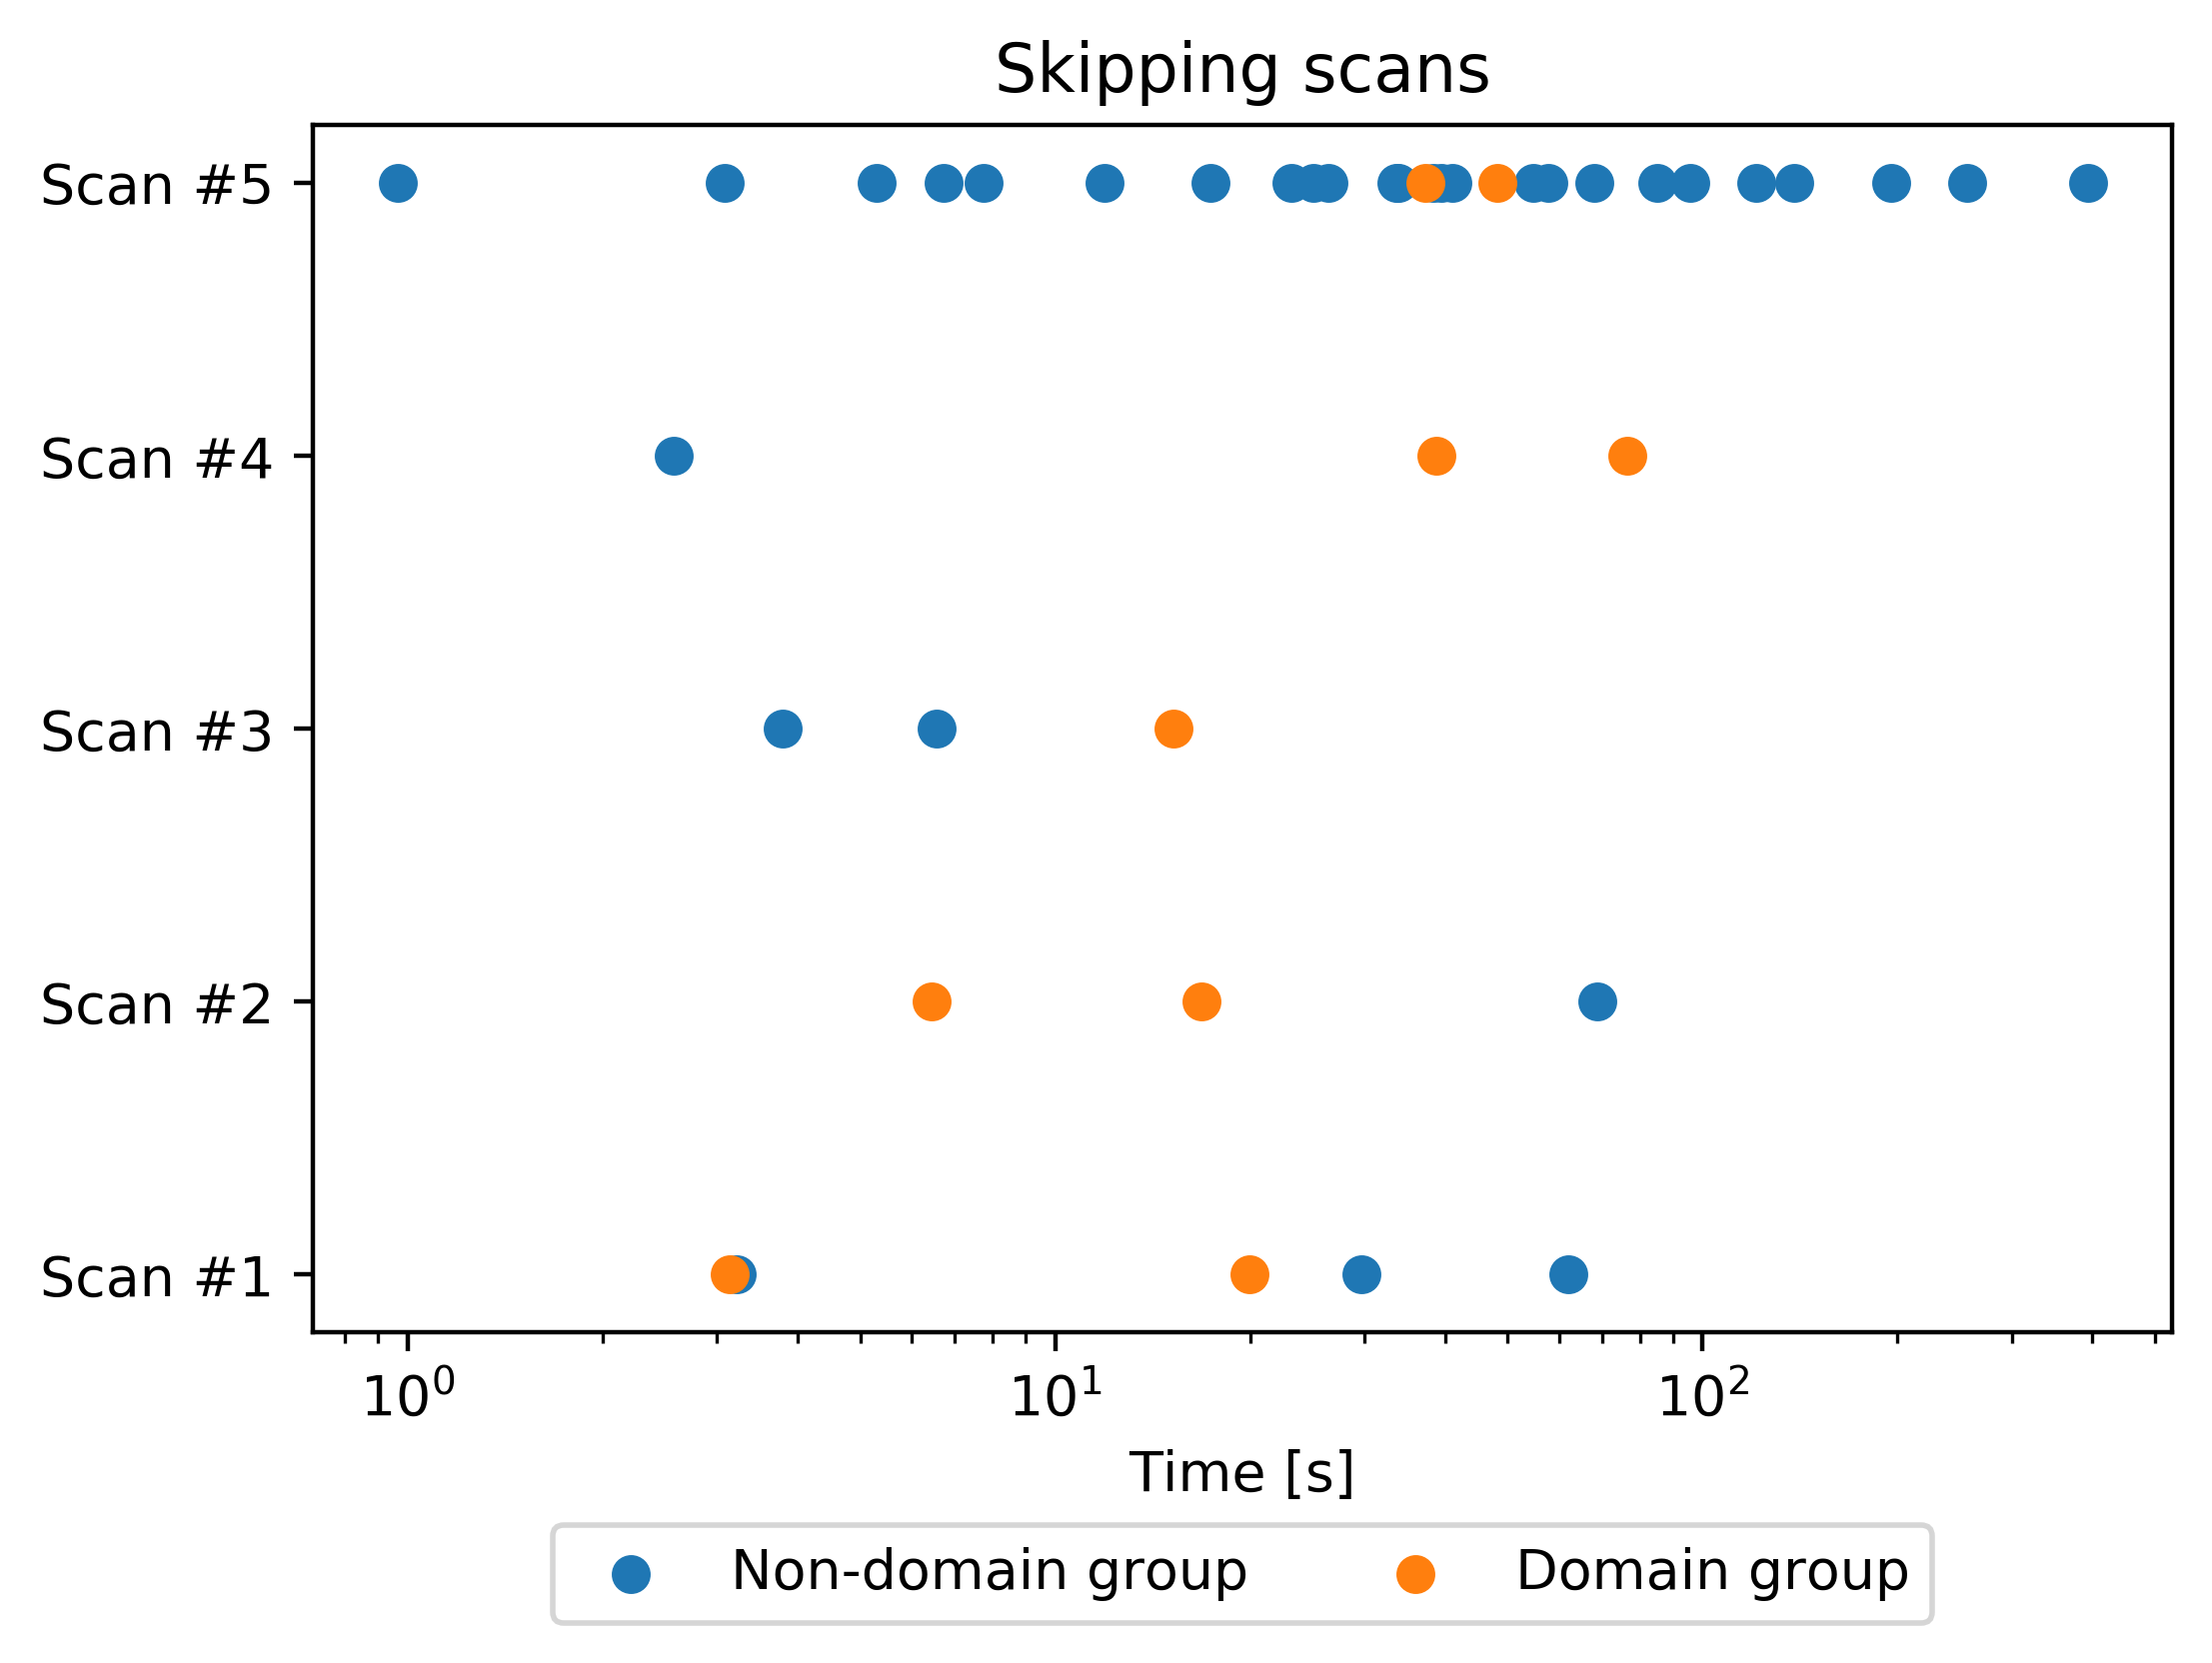

In [95]:
plt.figure(figsize=[6, 4], dpi=400)
ax = plt.subplot(111)

eti_per_scan_x = []
eti_per_scan_y = []
gumed_per_scan_x = []
gumed_per_scan_y = []

for idx, scan_id in enumerate(SCAN_IDS):
    eti = list(eti_skipped[eti_skipped['ScanID'] == scan_id]['Time'].astype(float))
    eti_per_scan_x += eti
    eti_per_scan_y += ['Scan #' + str(idx+1)] * len(eti)
    
    gumed = list(gumed_skipped[gumed_skipped['ScanID'] == scan_id]['Time'].astype(float))
    gumed_per_scan_x += gumed
    gumed_per_scan_y += ['Scan #' + str(idx+1)] * len(gumed)

ax.scatter(eti_per_scan_x, eti_per_scan_y)
ax.scatter(gumed_per_scan_x, gumed_per_scan_y)

ax.set_title('Skipping scans')
ax.set_xlabel('Time [s]')
ax.set_xscale('log')

lgd = ax.legend(['Non-domain group', 'Domain group'], ncol=3, loc='center', bbox_to_anchor=(0.5, -0.2))

plt.savefig('/Users/jakubpowierza/Downloads/poster_images/11.png',
            bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()